In [1]:
import keras
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
from keras.callbacks import ModelCheckpoint, EarlyStopping
# %reload_ext mermaid
# import IPython
# IPython.load_ipython_extensions(["nb-mermaid/nb-mermaid"]);

Using TensorFlow backend.


In [2]:
import tensorflow  as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D,Reshape, Dropout, Dense, GlobalAveragePooling2D, \
BatchNormalization, Input, Flatten, MaxPooling2D, UpSampling2D,Lambda
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adadelta, SGD, Adam
from keras.utils import to_categorical
import keras.backend as K

In [3]:
tf_config = tf.ConfigProto(allow_soft_placement=False)
tf_config.gpu_options.allow_growth = True
s = tf.Session(config=tf_config)
K.set_session(s)

In [4]:
csv_data = pd.read_csv('15features.csv')

In [5]:
display(csv_data.head()), csv_data.shape

,imagename,pen_pressure,letter_spacing,size,dimension,is_lowercase,is_continuous,slantness,tilt,entry_stroke_a,staff_of_a,formation_n,staff_of_d,exit_stroke_d,word_formation,constancy
0,0968c_num1.png,2,2,2,1,2,2,3,2,1,2,2,3,2,2,1
1,0809c_num2.png,2,2,2,2,2,2,3,1,1,2,2,3,1,2,2
2,0237b_num6.png,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2
3,0069b_num2.png,2,2,2,1,2,2,1,1,1,1,1,1,1,1,1
4,0966c_num4.png,2,2,2,2,2,2,2,1,1,2,2,2,2,2,2


(None, (13570, 16))

In [6]:
train_path = 'unseen-dataset/TrainingSet/'
train_images = os.listdir(train_path)
len(train_images)
val_path = 'unseen-dataset/ValidationSet/'
val_images = os.listdir(val_path)
len(val_images)

888

In [7]:
input_img = Input(shape=(64, 64, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded')(x)
# encoded = GlobalAveragePooling2D()(x)

# encoder = Model(input_img, encoded)
# encoder.summary()
# print(encoded.shape)
# encoded = Flatten()(x)
# encoded = Dense(8*8*8)(encoded)
# # model = Model(input_img,encoded)
# # print(model.summary())
# # at this point the representation is (4, 4, 8) i.e. 128-dimensional
# r = Reshape(target_shape=(8,8,8))(encoded)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='output')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
__________

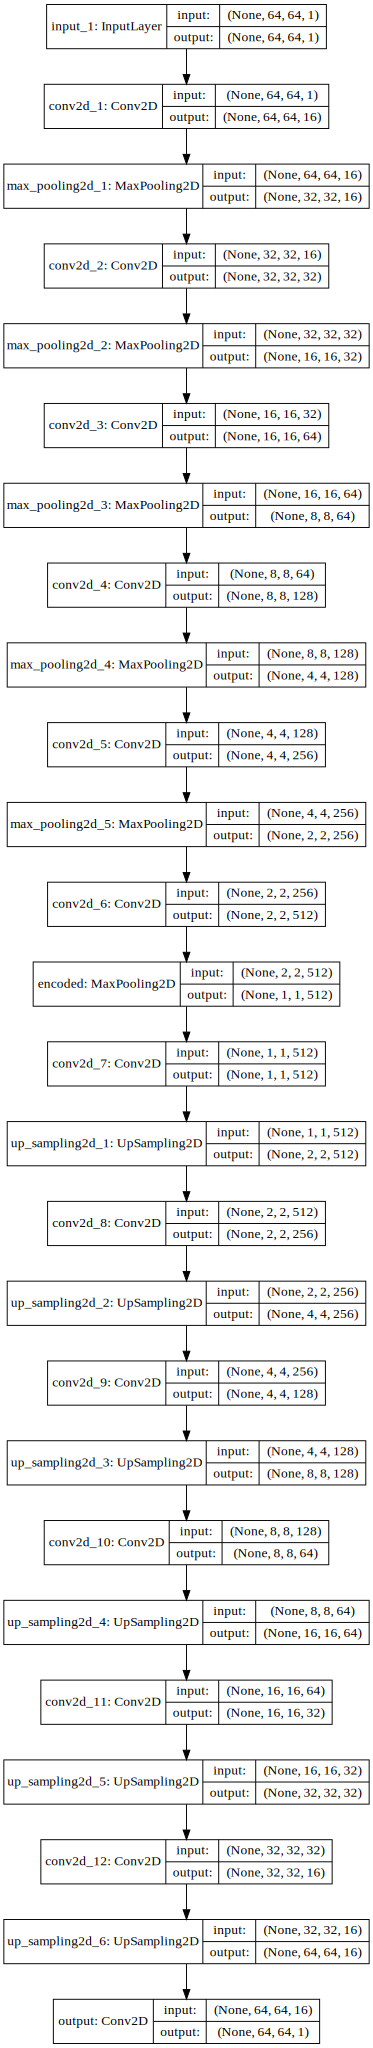

In [8]:

SVG(model_to_dot(autoencoder, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [9]:

def datagen(batch_size,image_path,list_of_writers, hshift = (-64,64) ,vis=False):
    counter = 0
    
    
    while True:
        counter = 0
        # for writer in unique_writers:
        #     print(identitycounter*100/stop_at, end='\r')
        w_ids,ids = [],[]
        writer_indexes = np.random.randint(0,len(list_of_writers),batch_size)
        x,y,writers = [],[],[]
        for writer_index in writer_indexes:
#             class_vectors = []
            writer = list_of_writers[writer_index]
#             print(writer)
#             writer_samples = list(images[images['image'].str.match(writer)]['image'])
#             print('writer:',writer,', writer_samples:',writer_samples)
#             if len(writer_samples) == 0:
#                 continue
#             writer_sample_index = np.random.randint(0,len(writer_samples))

#             #     unique_writers_count[writer] = len(writer_samples)
# #             print('writer_sample_index:',writer_sample_index)
#             csv_writer = writer_samples[writer_sample_index][:5]

    
            loaded_image = cv2.imread(os.path.join(image_path,writer),0)
            rand = np.random.randint(hshift[0],hshift[1])
            loaded_image_shifted=np.roll(axis=0,a=loaded_image,shift=rand)
#             loaded_image = np.expand_dims(loaded_image,-1)
#             loaded_image_shifted = np.expand_dims(loaded_image_shifted,-1)
#             print('csv_writer:', csv_writer, ', writer:', writer)
#             display(csv_data[csv_data['ImageId'].str.match(csv_writer)])
#             csv_discreete_features = csv_data[csv_data['ImageId'].str.match(csv_writer)].iloc[0].values[2:]
#             print(csv_writer, writer_samples[writer_sample_index])
#             print(csv_writer,csv_discreete_features)
#             for i in range(1,9):
#                 print(csv_discreete_features[i-1],end=',')
#             f_1_out.append(csv_discreete_features[0])
#             f_2_out.append(csv_discreete_features[1])
#             f_3_out.append(csv_discreete_features[2])
#             f_4_out.append(csv_discreete_features[3])
#             f_5_out.append(csv_discreete_features[4])
#             f_6_out.append(csv_discreete_features[5])
#             f_7_out.append(csv_discreete_features[6])
#             f_8_out.append(csv_discreete_features[7])
#                 class_vectors.append(to_categorical(csv_discreete_features[i-1],num_classes=feature_lengths['f'+str(i)]))
#             print("\n",len(class_vectors))
#             print('\n-----------')
            
#             print("++++++++++++++++++++++[",counter,"]+++++++++++++++++++++++")
        #     imgcounter = 0
        #     for sample in writer_samples:
        #         imagepath = os.path.join(image_path,sample)
        #         raw_img = cv2.imread(imagepath)
        #         imgcounter+=1
        #     imgcounter=0
        #     identitycounter += 1
            x.append(255.0-loaded_image_shifted.reshape((64,64,1)))
            y.append(255.0-loaded_image.reshape((64,64,1)))
            w_ids.append(writer[:4])
            writers.append(writer)
            ids.append(writer_index)
            
            counter+=1
#             print('counter:', counter, end='\r')
        if counter <= batch_size:
            if vis== True:
                yield np.array(x)/255.0,[np.array(w_ids),np.array(writers)]
            else:
                yield np.array(x)/255.0,np.array(y)/255.0
                    

In [10]:
# # unique_writers_count
# f_count = {}
train_list_of_writers = train_images
val_list_of_writers = val_images
batch_size = 64

tg = datagen(batch_size,train_path,train_list_of_writers, hshift = (-64,64))
vg = datagen(batch_size,val_path,val_list_of_writers, hshift = (-64,64))
# test_g = datagen(4,val_list_of_writers, hshift = (-12,12))

In [11]:
# images
for i in range(10):
    inputs,y = next(tg)
inputs.shape , y.shape#, o[0].shape #, o[1].shape,o[2].shape,o[3].shape,o[4].shape,o[5].shape,o[6].shape,o[7].shape

((64, 64, 64, 1), (64, 64, 64, 1))

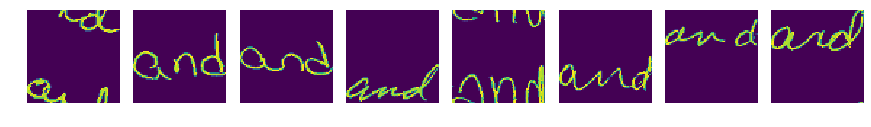

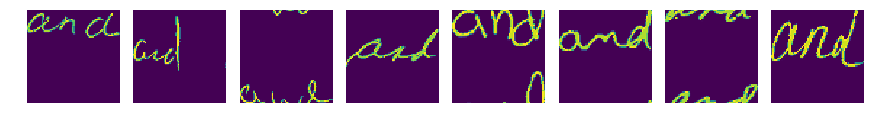

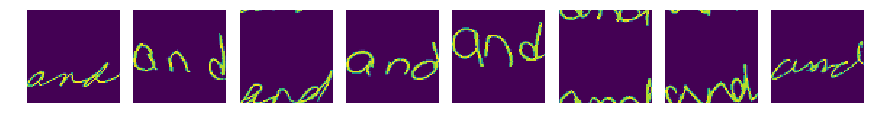

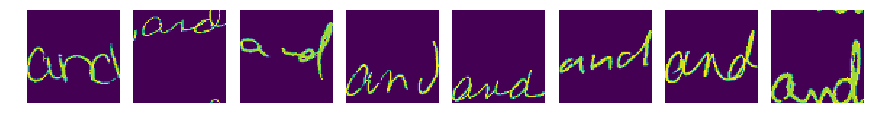

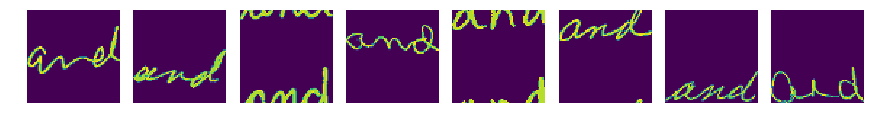

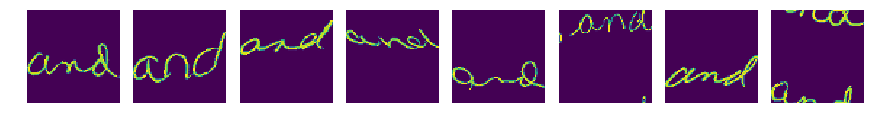

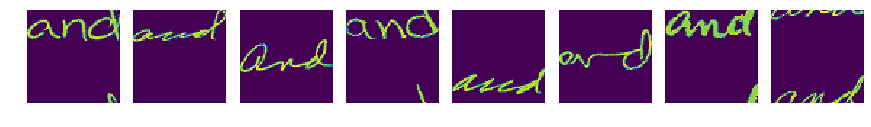

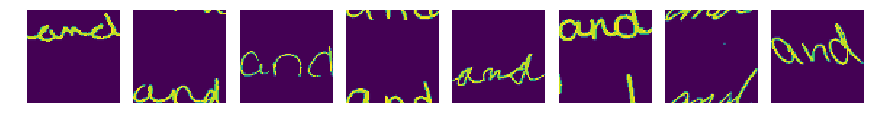

In [12]:
for r in range(8):
    f,ax = plt.subplots(1,8)
    f.subplots_adjust(hspace = .00, wspace=.15)
    f.set_size_inches(15,5)
    for c in range (8):
        ax[c].imshow(inputs[c+r*8].reshape((64,64)))
        ax[c].axis('off')

In [13]:
mc = ModelCheckpoint(filepath='simple_ae_maxpool_Unseen_weights_v1.h5', monitor='val_loss',period=1,save_best_only=True,save_weights_only=True,mode='auto',verbose=3)
es = EarlyStopping(patience=10000, monitor='val_loss', min_delta=0.0005, mode='auto')
autoencoder.load_weights('simple_ae_maxpool_less_weights_v3.h5')

In [14]:
EPOCHS = 50000

hist = autoencoder.fit_generator(tg, callbacks=[mc,es]
                                    , epochs=EPOCHS
                                    , steps_per_epoch = 1
                                    , validation_data = vg
                                    , validation_steps = 1
                                    , verbose = 3
                                    
                                   )

Epoch 1/50000

Epoch 00001: val_loss improved from inf to 0.13579, saving model to simple_ae_maxpool_Unseen_weights_v1.h5
Epoch 2/50000

Epoch 00002: val_loss improved from 0.13579 to 0.10829, saving model to simple_ae_maxpool_Unseen_weights_v1.h5
Epoch 3/50000

Epoch 00003: val_loss did not improve from 0.10829
Epoch 4/50000

Epoch 00004: val_loss did not improve from 0.10829
Epoch 5/50000

Epoch 00005: val_loss did not improve from 0.10829
Epoch 6/50000

Epoch 00006: val_loss did not improve from 0.10829
Epoch 7/50000

Epoch 00007: val_loss did not improve from 0.10829
Epoch 8/50000

Epoch 00008: val_loss improved from 0.10829 to 0.10410, saving model to simple_ae_maxpool_Unseen_weights_v1.h5
Epoch 9/50000

Epoch 00009: val_loss did not improve from 0.10410
Epoch 10/50000

Epoch 00010: val_loss did not improve from 0.10410
Epoch 11/50000

Epoch 00011: val_loss did not improve from 0.10410
Epoch 12/50000

Epoch 00012: val_loss did not improve from 0.10410
Epoch 13/50000

Epoch 00013: 


Epoch 00116: val_loss did not improve from 0.09847
Epoch 117/50000

Epoch 00117: val_loss did not improve from 0.09847
Epoch 118/50000

Epoch 00118: val_loss did not improve from 0.09847
Epoch 119/50000

Epoch 00119: val_loss did not improve from 0.09847
Epoch 120/50000

Epoch 00120: val_loss did not improve from 0.09847
Epoch 121/50000

Epoch 00121: val_loss did not improve from 0.09847
Epoch 122/50000

Epoch 00122: val_loss did not improve from 0.09847
Epoch 123/50000

Epoch 00123: val_loss did not improve from 0.09847
Epoch 124/50000

Epoch 00124: val_loss did not improve from 0.09847
Epoch 125/50000

Epoch 00125: val_loss did not improve from 0.09847
Epoch 126/50000

Epoch 00126: val_loss did not improve from 0.09847
Epoch 127/50000

Epoch 00127: val_loss did not improve from 0.09847
Epoch 128/50000

Epoch 00128: val_loss did not improve from 0.09847
Epoch 129/50000

Epoch 00129: val_loss did not improve from 0.09847
Epoch 130/50000

Epoch 00130: val_loss did not improve from 0.09


Epoch 00242: val_loss did not improve from 0.09847
Epoch 243/50000

Epoch 00243: val_loss did not improve from 0.09847
Epoch 244/50000

Epoch 00244: val_loss did not improve from 0.09847
Epoch 245/50000

Epoch 00245: val_loss did not improve from 0.09847
Epoch 246/50000

Epoch 00246: val_loss did not improve from 0.09847
Epoch 247/50000

Epoch 00247: val_loss did not improve from 0.09847
Epoch 248/50000

Epoch 00248: val_loss did not improve from 0.09847
Epoch 249/50000

Epoch 00249: val_loss did not improve from 0.09847
Epoch 250/50000

Epoch 00250: val_loss did not improve from 0.09847
Epoch 251/50000

Epoch 00251: val_loss did not improve from 0.09847
Epoch 252/50000

Epoch 00252: val_loss did not improve from 0.09847
Epoch 253/50000

Epoch 00253: val_loss did not improve from 0.09847
Epoch 254/50000

Epoch 00254: val_loss did not improve from 0.09847
Epoch 255/50000

Epoch 00255: val_loss did not improve from 0.09847
Epoch 256/50000

Epoch 00256: val_loss did not improve from 0.09


Epoch 00368: val_loss did not improve from 0.09847
Epoch 369/50000

Epoch 00369: val_loss did not improve from 0.09847
Epoch 370/50000

Epoch 00370: val_loss did not improve from 0.09847
Epoch 371/50000

Epoch 00371: val_loss improved from 0.09847 to 0.09785, saving model to simple_ae_maxpool_Unseen_weights_v1.h5
Epoch 372/50000

Epoch 00372: val_loss did not improve from 0.09785
Epoch 373/50000

Epoch 00373: val_loss did not improve from 0.09785
Epoch 374/50000

Epoch 00374: val_loss did not improve from 0.09785
Epoch 375/50000

Epoch 00375: val_loss did not improve from 0.09785
Epoch 376/50000

Epoch 00376: val_loss did not improve from 0.09785
Epoch 377/50000

Epoch 00377: val_loss did not improve from 0.09785
Epoch 378/50000

Epoch 00378: val_loss did not improve from 0.09785
Epoch 379/50000

Epoch 00379: val_loss did not improve from 0.09785
Epoch 380/50000

Epoch 00380: val_loss did not improve from 0.09785
Epoch 381/50000

Epoch 00381: val_loss did not improve from 0.09785
Epoc


Epoch 00494: val_loss did not improve from 0.09763
Epoch 495/50000

Epoch 00495: val_loss did not improve from 0.09763
Epoch 496/50000

Epoch 00496: val_loss did not improve from 0.09763
Epoch 497/50000

Epoch 00497: val_loss did not improve from 0.09763
Epoch 498/50000

Epoch 00498: val_loss did not improve from 0.09763
Epoch 499/50000

Epoch 00499: val_loss did not improve from 0.09763
Epoch 500/50000

Epoch 00500: val_loss did not improve from 0.09763
Epoch 501/50000

Epoch 00501: val_loss did not improve from 0.09763
Epoch 502/50000

Epoch 00502: val_loss did not improve from 0.09763
Epoch 503/50000

Epoch 00503: val_loss did not improve from 0.09763
Epoch 504/50000

Epoch 00504: val_loss did not improve from 0.09763
Epoch 505/50000

Epoch 00505: val_loss did not improve from 0.09763
Epoch 506/50000

Epoch 00506: val_loss did not improve from 0.09763
Epoch 507/50000

Epoch 00507: val_loss did not improve from 0.09763
Epoch 508/50000

Epoch 00508: val_loss did not improve from 0.09


Epoch 00620: val_loss did not improve from 0.09763
Epoch 621/50000

Epoch 00621: val_loss did not improve from 0.09763
Epoch 622/50000

Epoch 00622: val_loss did not improve from 0.09763
Epoch 623/50000

Epoch 00623: val_loss did not improve from 0.09763
Epoch 624/50000

Epoch 00624: val_loss did not improve from 0.09763
Epoch 625/50000

Epoch 00625: val_loss did not improve from 0.09763
Epoch 626/50000

Epoch 00626: val_loss did not improve from 0.09763
Epoch 627/50000

Epoch 00627: val_loss did not improve from 0.09763
Epoch 628/50000

Epoch 00628: val_loss did not improve from 0.09763
Epoch 629/50000

Epoch 00629: val_loss did not improve from 0.09763
Epoch 630/50000

Epoch 00630: val_loss did not improve from 0.09763
Epoch 631/50000

Epoch 00631: val_loss did not improve from 0.09763
Epoch 632/50000

Epoch 00632: val_loss did not improve from 0.09763
Epoch 633/50000

Epoch 00633: val_loss did not improve from 0.09763
Epoch 634/50000

Epoch 00634: val_loss did not improve from 0.09


Epoch 00744: val_loss did not improve from 0.09763
Epoch 745/50000

Epoch 00745: val_loss did not improve from 0.09763
Epoch 746/50000

Epoch 00746: val_loss did not improve from 0.09763
Epoch 747/50000

Epoch 00747: val_loss did not improve from 0.09763
Epoch 748/50000

Epoch 00748: val_loss did not improve from 0.09763
Epoch 749/50000

Epoch 00749: val_loss did not improve from 0.09763
Epoch 750/50000

Epoch 00750: val_loss did not improve from 0.09763
Epoch 751/50000

Epoch 00751: val_loss did not improve from 0.09763
Epoch 752/50000

Epoch 00752: val_loss did not improve from 0.09763
Epoch 753/50000

Epoch 00753: val_loss improved from 0.09763 to 0.09760, saving model to simple_ae_maxpool_Unseen_weights_v1.h5
Epoch 754/50000

Epoch 00754: val_loss did not improve from 0.09760
Epoch 755/50000

Epoch 00755: val_loss improved from 0.09760 to 0.09599, saving model to simple_ae_maxpool_Unseen_weights_v1.h5
Epoch 756/50000

Epoch 00756: val_loss did not improve from 0.09599
Epoch 757/50


Epoch 00863: val_loss did not improve from 0.09599
Epoch 864/50000

Epoch 00864: val_loss did not improve from 0.09599
Epoch 865/50000

Epoch 00865: val_loss did not improve from 0.09599
Epoch 866/50000

Epoch 00866: val_loss did not improve from 0.09599
Epoch 867/50000

Epoch 00867: val_loss did not improve from 0.09599
Epoch 868/50000

Epoch 00868: val_loss did not improve from 0.09599
Epoch 869/50000

Epoch 00869: val_loss did not improve from 0.09599
Epoch 870/50000

Epoch 00870: val_loss did not improve from 0.09599
Epoch 871/50000

Epoch 00871: val_loss did not improve from 0.09599
Epoch 872/50000

Epoch 00872: val_loss did not improve from 0.09599
Epoch 873/50000

Epoch 00873: val_loss did not improve from 0.09599
Epoch 874/50000

Epoch 00874: val_loss did not improve from 0.09599
Epoch 875/50000

Epoch 00875: val_loss did not improve from 0.09599
Epoch 876/50000

Epoch 00876: val_loss did not improve from 0.09599
Epoch 877/50000

Epoch 00877: val_loss did not improve from 0.09


Epoch 00989: val_loss did not improve from 0.09599
Epoch 990/50000

Epoch 00990: val_loss did not improve from 0.09599
Epoch 991/50000

Epoch 00991: val_loss did not improve from 0.09599
Epoch 992/50000

Epoch 00992: val_loss did not improve from 0.09599
Epoch 993/50000

Epoch 00993: val_loss did not improve from 0.09599
Epoch 994/50000

Epoch 00994: val_loss did not improve from 0.09599
Epoch 995/50000

Epoch 00995: val_loss did not improve from 0.09599
Epoch 996/50000

Epoch 00996: val_loss did not improve from 0.09599
Epoch 997/50000

Epoch 00997: val_loss did not improve from 0.09599
Epoch 998/50000

Epoch 00998: val_loss did not improve from 0.09599
Epoch 999/50000

Epoch 00999: val_loss did not improve from 0.09599
Epoch 1000/50000

Epoch 01000: val_loss did not improve from 0.09599
Epoch 1001/50000

Epoch 01001: val_loss did not improve from 0.09599
Epoch 1002/50000

Epoch 01002: val_loss did not improve from 0.09599
Epoch 1003/50000

Epoch 01003: val_loss did not improve from 


Epoch 01110: val_loss did not improve from 0.09562
Epoch 1111/50000

Epoch 01111: val_loss did not improve from 0.09562
Epoch 1112/50000

Epoch 01112: val_loss did not improve from 0.09562
Epoch 1113/50000

Epoch 01113: val_loss did not improve from 0.09562
Epoch 1114/50000

Epoch 01114: val_loss did not improve from 0.09562
Epoch 1115/50000

Epoch 01115: val_loss did not improve from 0.09562
Epoch 1116/50000

Epoch 01116: val_loss did not improve from 0.09562
Epoch 1117/50000

Epoch 01117: val_loss did not improve from 0.09562
Epoch 1118/50000

Epoch 01118: val_loss did not improve from 0.09562
Epoch 1119/50000

Epoch 01119: val_loss did not improve from 0.09562
Epoch 1120/50000

Epoch 01120: val_loss did not improve from 0.09562
Epoch 1121/50000

Epoch 01121: val_loss did not improve from 0.09562
Epoch 1122/50000

Epoch 01122: val_loss did not improve from 0.09562
Epoch 1123/50000

Epoch 01123: val_loss did not improve from 0.09562
Epoch 1124/50000

Epoch 01124: val_loss did not imp


Epoch 01235: val_loss did not improve from 0.09562
Epoch 1236/50000

Epoch 01236: val_loss did not improve from 0.09562
Epoch 1237/50000

Epoch 01237: val_loss did not improve from 0.09562
Epoch 1238/50000

Epoch 01238: val_loss did not improve from 0.09562
Epoch 1239/50000

Epoch 01239: val_loss did not improve from 0.09562
Epoch 1240/50000

Epoch 01240: val_loss did not improve from 0.09562
Epoch 1241/50000

Epoch 01241: val_loss did not improve from 0.09562
Epoch 1242/50000

Epoch 01242: val_loss did not improve from 0.09562
Epoch 1243/50000

Epoch 01243: val_loss did not improve from 0.09562
Epoch 1244/50000

Epoch 01244: val_loss did not improve from 0.09562
Epoch 1245/50000

Epoch 01245: val_loss did not improve from 0.09562
Epoch 1246/50000

Epoch 01246: val_loss did not improve from 0.09562
Epoch 1247/50000

Epoch 01247: val_loss did not improve from 0.09562
Epoch 1248/50000

Epoch 01248: val_loss did not improve from 0.09562
Epoch 1249/50000

Epoch 01249: val_loss did not imp


Epoch 01358: val_loss did not improve from 0.09562
Epoch 1359/50000

Epoch 01359: val_loss did not improve from 0.09562
Epoch 1360/50000

Epoch 01360: val_loss did not improve from 0.09562
Epoch 1361/50000

Epoch 01361: val_loss did not improve from 0.09562
Epoch 1362/50000

Epoch 01362: val_loss did not improve from 0.09562
Epoch 1363/50000

Epoch 01363: val_loss did not improve from 0.09562
Epoch 1364/50000

Epoch 01364: val_loss did not improve from 0.09562
Epoch 1365/50000

Epoch 01365: val_loss did not improve from 0.09562
Epoch 1366/50000

Epoch 01366: val_loss did not improve from 0.09562
Epoch 1367/50000

Epoch 01367: val_loss did not improve from 0.09562
Epoch 1368/50000

Epoch 01368: val_loss did not improve from 0.09562
Epoch 1369/50000

Epoch 01369: val_loss did not improve from 0.09562
Epoch 1370/50000

Epoch 01370: val_loss did not improve from 0.09562
Epoch 1371/50000

Epoch 01371: val_loss did not improve from 0.09562
Epoch 1372/50000

Epoch 01372: val_loss did not imp


Epoch 01483: val_loss did not improve from 0.09562
Epoch 1484/50000

Epoch 01484: val_loss did not improve from 0.09562
Epoch 1485/50000

Epoch 01485: val_loss did not improve from 0.09562
Epoch 1486/50000

Epoch 01486: val_loss did not improve from 0.09562
Epoch 1487/50000

Epoch 01487: val_loss did not improve from 0.09562
Epoch 1488/50000

Epoch 01488: val_loss did not improve from 0.09562
Epoch 1489/50000

Epoch 01489: val_loss did not improve from 0.09562
Epoch 1490/50000

Epoch 01490: val_loss did not improve from 0.09562
Epoch 1491/50000

Epoch 01491: val_loss did not improve from 0.09562
Epoch 1492/50000

Epoch 01492: val_loss did not improve from 0.09562
Epoch 1493/50000

Epoch 01493: val_loss did not improve from 0.09562
Epoch 1494/50000

Epoch 01494: val_loss did not improve from 0.09562
Epoch 1495/50000

Epoch 01495: val_loss did not improve from 0.09562
Epoch 1496/50000

Epoch 01496: val_loss did not improve from 0.09562
Epoch 1497/50000

Epoch 01497: val_loss did not imp


Epoch 01609: val_loss did not improve from 0.09562
Epoch 1610/50000

Epoch 01610: val_loss did not improve from 0.09562
Epoch 1611/50000

Epoch 01611: val_loss did not improve from 0.09562
Epoch 1612/50000

Epoch 01612: val_loss did not improve from 0.09562
Epoch 1613/50000

Epoch 01613: val_loss did not improve from 0.09562
Epoch 1614/50000

Epoch 01614: val_loss did not improve from 0.09562
Epoch 1615/50000

Epoch 01615: val_loss did not improve from 0.09562
Epoch 1616/50000

Epoch 01616: val_loss did not improve from 0.09562
Epoch 1617/50000

Epoch 01617: val_loss did not improve from 0.09562
Epoch 1618/50000

Epoch 01618: val_loss did not improve from 0.09562
Epoch 1619/50000

Epoch 01619: val_loss did not improve from 0.09562
Epoch 1620/50000

Epoch 01620: val_loss did not improve from 0.09562
Epoch 1621/50000

Epoch 01621: val_loss did not improve from 0.09562
Epoch 1622/50000

Epoch 01622: val_loss did not improve from 0.09562
Epoch 1623/50000

Epoch 01623: val_loss did not imp


Epoch 01734: val_loss did not improve from 0.09343
Epoch 1735/50000

Epoch 01735: val_loss did not improve from 0.09343
Epoch 1736/50000

Epoch 01736: val_loss did not improve from 0.09343
Epoch 1737/50000

Epoch 01737: val_loss did not improve from 0.09343
Epoch 1738/50000

Epoch 01738: val_loss did not improve from 0.09343
Epoch 1739/50000

Epoch 01739: val_loss did not improve from 0.09343
Epoch 1740/50000

Epoch 01740: val_loss did not improve from 0.09343
Epoch 1741/50000

Epoch 01741: val_loss did not improve from 0.09343
Epoch 1742/50000

Epoch 01742: val_loss did not improve from 0.09343
Epoch 1743/50000

Epoch 01743: val_loss did not improve from 0.09343
Epoch 1744/50000

Epoch 01744: val_loss did not improve from 0.09343
Epoch 1745/50000

Epoch 01745: val_loss did not improve from 0.09343
Epoch 1746/50000

Epoch 01746: val_loss did not improve from 0.09343
Epoch 1747/50000

Epoch 01747: val_loss did not improve from 0.09343
Epoch 1748/50000

Epoch 01748: val_loss did not imp


Epoch 01860: val_loss did not improve from 0.09343
Epoch 1861/50000

Epoch 01861: val_loss did not improve from 0.09343
Epoch 1862/50000

Epoch 01862: val_loss did not improve from 0.09343
Epoch 1863/50000

Epoch 01863: val_loss did not improve from 0.09343
Epoch 1864/50000

Epoch 01864: val_loss did not improve from 0.09343
Epoch 1865/50000

Epoch 01865: val_loss did not improve from 0.09343
Epoch 1866/50000

Epoch 01866: val_loss did not improve from 0.09343
Epoch 1867/50000

Epoch 01867: val_loss did not improve from 0.09343
Epoch 1868/50000

Epoch 01868: val_loss did not improve from 0.09343
Epoch 1869/50000

Epoch 01869: val_loss did not improve from 0.09343
Epoch 1870/50000

Epoch 01870: val_loss did not improve from 0.09343
Epoch 1871/50000

Epoch 01871: val_loss did not improve from 0.09343
Epoch 1872/50000

Epoch 01872: val_loss did not improve from 0.09343
Epoch 1873/50000

Epoch 01873: val_loss did not improve from 0.09343
Epoch 1874/50000

Epoch 01874: val_loss did not imp


Epoch 01984: val_loss did not improve from 0.09342
Epoch 1985/50000

Epoch 01985: val_loss did not improve from 0.09342
Epoch 1986/50000

Epoch 01986: val_loss did not improve from 0.09342
Epoch 1987/50000

Epoch 01987: val_loss did not improve from 0.09342
Epoch 1988/50000

Epoch 01988: val_loss did not improve from 0.09342
Epoch 1989/50000

Epoch 01989: val_loss did not improve from 0.09342
Epoch 1990/50000

Epoch 01990: val_loss did not improve from 0.09342
Epoch 1991/50000

Epoch 01991: val_loss did not improve from 0.09342
Epoch 1992/50000

Epoch 01992: val_loss did not improve from 0.09342
Epoch 1993/50000

Epoch 01993: val_loss did not improve from 0.09342
Epoch 1994/50000

Epoch 01994: val_loss did not improve from 0.09342
Epoch 1995/50000

Epoch 01995: val_loss did not improve from 0.09342
Epoch 1996/50000

Epoch 01996: val_loss did not improve from 0.09342
Epoch 1997/50000

Epoch 01997: val_loss did not improve from 0.09342
Epoch 1998/50000

Epoch 01998: val_loss did not imp


Epoch 02110: val_loss did not improve from 0.09342
Epoch 2111/50000

Epoch 02111: val_loss did not improve from 0.09342
Epoch 2112/50000

Epoch 02112: val_loss did not improve from 0.09342
Epoch 2113/50000

Epoch 02113: val_loss did not improve from 0.09342
Epoch 2114/50000

Epoch 02114: val_loss did not improve from 0.09342
Epoch 2115/50000

Epoch 02115: val_loss did not improve from 0.09342
Epoch 2116/50000

Epoch 02116: val_loss did not improve from 0.09342
Epoch 2117/50000

Epoch 02117: val_loss did not improve from 0.09342
Epoch 2118/50000

Epoch 02118: val_loss did not improve from 0.09342
Epoch 2119/50000

Epoch 02119: val_loss did not improve from 0.09342
Epoch 2120/50000

Epoch 02120: val_loss did not improve from 0.09342
Epoch 2121/50000

Epoch 02121: val_loss did not improve from 0.09342
Epoch 2122/50000

Epoch 02122: val_loss did not improve from 0.09342
Epoch 2123/50000

Epoch 02123: val_loss did not improve from 0.09342
Epoch 2124/50000

Epoch 02124: val_loss did not imp


Epoch 02236: val_loss did not improve from 0.09342
Epoch 2237/50000

Epoch 02237: val_loss did not improve from 0.09342
Epoch 2238/50000

Epoch 02238: val_loss did not improve from 0.09342
Epoch 2239/50000

Epoch 02239: val_loss did not improve from 0.09342
Epoch 2240/50000

Epoch 02240: val_loss did not improve from 0.09342
Epoch 2241/50000

Epoch 02241: val_loss did not improve from 0.09342
Epoch 2242/50000

Epoch 02242: val_loss did not improve from 0.09342
Epoch 2243/50000

Epoch 02243: val_loss did not improve from 0.09342
Epoch 2244/50000

Epoch 02244: val_loss did not improve from 0.09342
Epoch 2245/50000

Epoch 02245: val_loss did not improve from 0.09342
Epoch 2246/50000

Epoch 02246: val_loss did not improve from 0.09342
Epoch 2247/50000

Epoch 02247: val_loss did not improve from 0.09342
Epoch 2248/50000

Epoch 02248: val_loss did not improve from 0.09342
Epoch 2249/50000

Epoch 02249: val_loss did not improve from 0.09342
Epoch 2250/50000

Epoch 02250: val_loss did not imp


Epoch 02362: val_loss did not improve from 0.09342
Epoch 2363/50000

Epoch 02363: val_loss did not improve from 0.09342
Epoch 2364/50000

Epoch 02364: val_loss did not improve from 0.09342
Epoch 2365/50000

Epoch 02365: val_loss did not improve from 0.09342
Epoch 2366/50000

Epoch 02366: val_loss did not improve from 0.09342
Epoch 2367/50000

Epoch 02367: val_loss did not improve from 0.09342
Epoch 2368/50000

Epoch 02368: val_loss did not improve from 0.09342
Epoch 2369/50000

Epoch 02369: val_loss did not improve from 0.09342
Epoch 2370/50000

Epoch 02370: val_loss did not improve from 0.09342
Epoch 2371/50000

Epoch 02371: val_loss did not improve from 0.09342
Epoch 2372/50000

Epoch 02372: val_loss did not improve from 0.09342
Epoch 2373/50000

Epoch 02373: val_loss did not improve from 0.09342
Epoch 2374/50000

Epoch 02374: val_loss did not improve from 0.09342
Epoch 2375/50000

Epoch 02375: val_loss did not improve from 0.09342
Epoch 2376/50000

Epoch 02376: val_loss did not imp


Epoch 02488: val_loss did not improve from 0.09342
Epoch 2489/50000

Epoch 02489: val_loss did not improve from 0.09342
Epoch 2490/50000

Epoch 02490: val_loss did not improve from 0.09342
Epoch 2491/50000

Epoch 02491: val_loss did not improve from 0.09342
Epoch 2492/50000

Epoch 02492: val_loss did not improve from 0.09342
Epoch 2493/50000

Epoch 02493: val_loss did not improve from 0.09342
Epoch 2494/50000

Epoch 02494: val_loss did not improve from 0.09342
Epoch 2495/50000

Epoch 02495: val_loss did not improve from 0.09342
Epoch 2496/50000

Epoch 02496: val_loss did not improve from 0.09342
Epoch 2497/50000

Epoch 02497: val_loss did not improve from 0.09342
Epoch 2498/50000

Epoch 02498: val_loss did not improve from 0.09342
Epoch 2499/50000

Epoch 02499: val_loss did not improve from 0.09342
Epoch 2500/50000

Epoch 02500: val_loss did not improve from 0.09342
Epoch 2501/50000

Epoch 02501: val_loss did not improve from 0.09342
Epoch 2502/50000

Epoch 02502: val_loss did not imp


Epoch 02614: val_loss did not improve from 0.09342
Epoch 2615/50000

Epoch 02615: val_loss did not improve from 0.09342
Epoch 2616/50000

Epoch 02616: val_loss did not improve from 0.09342
Epoch 2617/50000

Epoch 02617: val_loss did not improve from 0.09342
Epoch 2618/50000

Epoch 02618: val_loss did not improve from 0.09342
Epoch 2619/50000

Epoch 02619: val_loss did not improve from 0.09342
Epoch 2620/50000

Epoch 02620: val_loss did not improve from 0.09342
Epoch 2621/50000

Epoch 02621: val_loss did not improve from 0.09342
Epoch 2622/50000

Epoch 02622: val_loss did not improve from 0.09342
Epoch 2623/50000

Epoch 02623: val_loss did not improve from 0.09342
Epoch 2624/50000

Epoch 02624: val_loss did not improve from 0.09342
Epoch 2625/50000

Epoch 02625: val_loss did not improve from 0.09342
Epoch 2626/50000

Epoch 02626: val_loss did not improve from 0.09342
Epoch 2627/50000

Epoch 02627: val_loss did not improve from 0.09342
Epoch 2628/50000

Epoch 02628: val_loss did not imp


Epoch 02740: val_loss did not improve from 0.09342
Epoch 2741/50000

Epoch 02741: val_loss did not improve from 0.09342
Epoch 2742/50000

Epoch 02742: val_loss did not improve from 0.09342
Epoch 2743/50000

Epoch 02743: val_loss did not improve from 0.09342
Epoch 2744/50000

Epoch 02744: val_loss did not improve from 0.09342
Epoch 2745/50000

Epoch 02745: val_loss did not improve from 0.09342
Epoch 2746/50000

Epoch 02746: val_loss did not improve from 0.09342
Epoch 2747/50000

Epoch 02747: val_loss did not improve from 0.09342
Epoch 2748/50000

Epoch 02748: val_loss did not improve from 0.09342
Epoch 2749/50000

Epoch 02749: val_loss did not improve from 0.09342
Epoch 2750/50000

Epoch 02750: val_loss did not improve from 0.09342
Epoch 2751/50000

Epoch 02751: val_loss did not improve from 0.09342
Epoch 2752/50000

Epoch 02752: val_loss did not improve from 0.09342
Epoch 2753/50000

Epoch 02753: val_loss did not improve from 0.09342
Epoch 2754/50000

Epoch 02754: val_loss did not imp


Epoch 02866: val_loss did not improve from 0.09342
Epoch 2867/50000

Epoch 02867: val_loss did not improve from 0.09342
Epoch 2868/50000

Epoch 02868: val_loss did not improve from 0.09342
Epoch 2869/50000

Epoch 02869: val_loss did not improve from 0.09342
Epoch 2870/50000

Epoch 02870: val_loss did not improve from 0.09342
Epoch 2871/50000

Epoch 02871: val_loss did not improve from 0.09342
Epoch 2872/50000

Epoch 02872: val_loss did not improve from 0.09342
Epoch 2873/50000

Epoch 02873: val_loss did not improve from 0.09342
Epoch 2874/50000

Epoch 02874: val_loss did not improve from 0.09342
Epoch 2875/50000

Epoch 02875: val_loss did not improve from 0.09342
Epoch 2876/50000

Epoch 02876: val_loss did not improve from 0.09342
Epoch 2877/50000

Epoch 02877: val_loss did not improve from 0.09342
Epoch 2878/50000

Epoch 02878: val_loss did not improve from 0.09342
Epoch 2879/50000

Epoch 02879: val_loss did not improve from 0.09342
Epoch 2880/50000

Epoch 02880: val_loss did not imp


Epoch 02990: val_loss did not improve from 0.09085
Epoch 2991/50000

Epoch 02991: val_loss did not improve from 0.09085
Epoch 2992/50000

Epoch 02992: val_loss did not improve from 0.09085
Epoch 2993/50000

Epoch 02993: val_loss did not improve from 0.09085
Epoch 2994/50000

Epoch 02994: val_loss did not improve from 0.09085
Epoch 2995/50000

Epoch 02995: val_loss did not improve from 0.09085
Epoch 2996/50000

Epoch 02996: val_loss did not improve from 0.09085
Epoch 2997/50000

Epoch 02997: val_loss did not improve from 0.09085
Epoch 2998/50000

Epoch 02998: val_loss did not improve from 0.09085
Epoch 2999/50000

Epoch 02999: val_loss did not improve from 0.09085
Epoch 3000/50000

Epoch 03000: val_loss did not improve from 0.09085
Epoch 3001/50000

Epoch 03001: val_loss did not improve from 0.09085
Epoch 3002/50000

Epoch 03002: val_loss did not improve from 0.09085
Epoch 3003/50000

Epoch 03003: val_loss did not improve from 0.09085
Epoch 3004/50000

Epoch 03004: val_loss did not imp


Epoch 03116: val_loss did not improve from 0.09085
Epoch 3117/50000

Epoch 03117: val_loss did not improve from 0.09085
Epoch 3118/50000

Epoch 03118: val_loss did not improve from 0.09085
Epoch 3119/50000

Epoch 03119: val_loss did not improve from 0.09085
Epoch 3120/50000

Epoch 03120: val_loss did not improve from 0.09085
Epoch 3121/50000

Epoch 03121: val_loss did not improve from 0.09085
Epoch 3122/50000

Epoch 03122: val_loss did not improve from 0.09085
Epoch 3123/50000

Epoch 03123: val_loss did not improve from 0.09085
Epoch 3124/50000

Epoch 03124: val_loss did not improve from 0.09085
Epoch 3125/50000

Epoch 03125: val_loss did not improve from 0.09085
Epoch 3126/50000

Epoch 03126: val_loss did not improve from 0.09085
Epoch 3127/50000

Epoch 03127: val_loss did not improve from 0.09085
Epoch 3128/50000

Epoch 03128: val_loss did not improve from 0.09085
Epoch 3129/50000

Epoch 03129: val_loss did not improve from 0.09085
Epoch 3130/50000

Epoch 03130: val_loss did not imp


Epoch 03242: val_loss did not improve from 0.09085
Epoch 3243/50000

Epoch 03243: val_loss did not improve from 0.09085
Epoch 3244/50000

Epoch 03244: val_loss did not improve from 0.09085
Epoch 3245/50000

Epoch 03245: val_loss did not improve from 0.09085
Epoch 3246/50000

Epoch 03246: val_loss did not improve from 0.09085
Epoch 3247/50000

Epoch 03247: val_loss did not improve from 0.09085
Epoch 3248/50000

Epoch 03248: val_loss did not improve from 0.09085
Epoch 3249/50000

Epoch 03249: val_loss did not improve from 0.09085
Epoch 3250/50000

Epoch 03250: val_loss did not improve from 0.09085
Epoch 3251/50000

Epoch 03251: val_loss did not improve from 0.09085
Epoch 3252/50000

Epoch 03252: val_loss did not improve from 0.09085
Epoch 3253/50000

Epoch 03253: val_loss did not improve from 0.09085
Epoch 3254/50000

Epoch 03254: val_loss did not improve from 0.09085
Epoch 3255/50000

Epoch 03255: val_loss did not improve from 0.09085
Epoch 3256/50000

Epoch 03256: val_loss did not imp


Epoch 03368: val_loss did not improve from 0.09085
Epoch 3369/50000

Epoch 03369: val_loss did not improve from 0.09085
Epoch 3370/50000

Epoch 03370: val_loss did not improve from 0.09085
Epoch 3371/50000

Epoch 03371: val_loss did not improve from 0.09085
Epoch 3372/50000

Epoch 03372: val_loss did not improve from 0.09085
Epoch 3373/50000

Epoch 03373: val_loss did not improve from 0.09085
Epoch 3374/50000

Epoch 03374: val_loss did not improve from 0.09085
Epoch 3375/50000

Epoch 03375: val_loss did not improve from 0.09085
Epoch 3376/50000

Epoch 03376: val_loss did not improve from 0.09085
Epoch 3377/50000

Epoch 03377: val_loss did not improve from 0.09085
Epoch 3378/50000

Epoch 03378: val_loss did not improve from 0.09085
Epoch 3379/50000

Epoch 03379: val_loss did not improve from 0.09085
Epoch 3380/50000

Epoch 03380: val_loss did not improve from 0.09085
Epoch 3381/50000

Epoch 03381: val_loss did not improve from 0.09085
Epoch 3382/50000

Epoch 03382: val_loss did not imp


Epoch 03493: val_loss did not improve from 0.09085
Epoch 3494/50000

Epoch 03494: val_loss did not improve from 0.09085
Epoch 3495/50000

Epoch 03495: val_loss did not improve from 0.09085
Epoch 3496/50000

Epoch 03496: val_loss did not improve from 0.09085
Epoch 3497/50000

Epoch 03497: val_loss did not improve from 0.09085
Epoch 3498/50000

Epoch 03498: val_loss did not improve from 0.09085
Epoch 3499/50000

Epoch 03499: val_loss did not improve from 0.09085
Epoch 3500/50000

Epoch 03500: val_loss did not improve from 0.09085
Epoch 3501/50000

Epoch 03501: val_loss did not improve from 0.09085
Epoch 3502/50000

Epoch 03502: val_loss did not improve from 0.09085
Epoch 3503/50000

Epoch 03503: val_loss did not improve from 0.09085
Epoch 3504/50000

Epoch 03504: val_loss did not improve from 0.09085
Epoch 3505/50000

Epoch 03505: val_loss did not improve from 0.09085
Epoch 3506/50000

Epoch 03506: val_loss did not improve from 0.09085
Epoch 3507/50000

Epoch 03507: val_loss did not imp


Epoch 03618: val_loss did not improve from 0.09085
Epoch 3619/50000

Epoch 03619: val_loss did not improve from 0.09085
Epoch 3620/50000

Epoch 03620: val_loss did not improve from 0.09085
Epoch 3621/50000

Epoch 03621: val_loss did not improve from 0.09085
Epoch 3622/50000

Epoch 03622: val_loss did not improve from 0.09085
Epoch 3623/50000

Epoch 03623: val_loss did not improve from 0.09085
Epoch 3624/50000

Epoch 03624: val_loss did not improve from 0.09085
Epoch 3625/50000

Epoch 03625: val_loss did not improve from 0.09085
Epoch 3626/50000

Epoch 03626: val_loss did not improve from 0.09085
Epoch 3627/50000

Epoch 03627: val_loss did not improve from 0.09085
Epoch 3628/50000

Epoch 03628: val_loss did not improve from 0.09085
Epoch 3629/50000

Epoch 03629: val_loss did not improve from 0.09085
Epoch 3630/50000

Epoch 03630: val_loss did not improve from 0.09085
Epoch 3631/50000

Epoch 03631: val_loss did not improve from 0.09085
Epoch 3632/50000

Epoch 03632: val_loss did not imp


Epoch 03743: val_loss did not improve from 0.09085
Epoch 3744/50000

Epoch 03744: val_loss did not improve from 0.09085
Epoch 3745/50000

Epoch 03745: val_loss did not improve from 0.09085
Epoch 3746/50000

Epoch 03746: val_loss did not improve from 0.09085
Epoch 3747/50000

Epoch 03747: val_loss did not improve from 0.09085
Epoch 3748/50000

Epoch 03748: val_loss did not improve from 0.09085
Epoch 3749/50000

Epoch 03749: val_loss did not improve from 0.09085
Epoch 3750/50000

Epoch 03750: val_loss did not improve from 0.09085
Epoch 3751/50000

Epoch 03751: val_loss did not improve from 0.09085
Epoch 3752/50000

Epoch 03752: val_loss did not improve from 0.09085
Epoch 3753/50000

Epoch 03753: val_loss did not improve from 0.09085
Epoch 3754/50000

Epoch 03754: val_loss did not improve from 0.09085
Epoch 3755/50000

Epoch 03755: val_loss did not improve from 0.09085
Epoch 3756/50000

Epoch 03756: val_loss did not improve from 0.09085
Epoch 3757/50000

Epoch 03757: val_loss did not imp


Epoch 03869: val_loss did not improve from 0.09085
Epoch 3870/50000

Epoch 03870: val_loss did not improve from 0.09085
Epoch 3871/50000

Epoch 03871: val_loss did not improve from 0.09085
Epoch 3872/50000

Epoch 03872: val_loss did not improve from 0.09085
Epoch 3873/50000

Epoch 03873: val_loss did not improve from 0.09085
Epoch 3874/50000

Epoch 03874: val_loss did not improve from 0.09085
Epoch 3875/50000

Epoch 03875: val_loss did not improve from 0.09085
Epoch 3876/50000

Epoch 03876: val_loss did not improve from 0.09085
Epoch 3877/50000

Epoch 03877: val_loss did not improve from 0.09085
Epoch 3878/50000

Epoch 03878: val_loss did not improve from 0.09085
Epoch 3879/50000

Epoch 03879: val_loss did not improve from 0.09085
Epoch 3880/50000

Epoch 03880: val_loss did not improve from 0.09085
Epoch 3881/50000

Epoch 03881: val_loss did not improve from 0.09085
Epoch 3882/50000

Epoch 03882: val_loss did not improve from 0.09085
Epoch 3883/50000

Epoch 03883: val_loss did not imp


Epoch 03994: val_loss did not improve from 0.09085
Epoch 3995/50000

Epoch 03995: val_loss did not improve from 0.09085
Epoch 3996/50000

Epoch 03996: val_loss did not improve from 0.09085
Epoch 3997/50000

Epoch 03997: val_loss did not improve from 0.09085
Epoch 3998/50000

Epoch 03998: val_loss did not improve from 0.09085
Epoch 3999/50000

Epoch 03999: val_loss did not improve from 0.09085
Epoch 4000/50000

Epoch 04000: val_loss did not improve from 0.09085
Epoch 4001/50000

Epoch 04001: val_loss did not improve from 0.09085
Epoch 4002/50000

Epoch 04002: val_loss did not improve from 0.09085
Epoch 4003/50000

Epoch 04003: val_loss did not improve from 0.09085
Epoch 4004/50000

Epoch 04004: val_loss did not improve from 0.09085
Epoch 4005/50000

Epoch 04005: val_loss did not improve from 0.09085
Epoch 4006/50000

Epoch 04006: val_loss did not improve from 0.09085
Epoch 4007/50000

Epoch 04007: val_loss did not improve from 0.09085
Epoch 4008/50000

Epoch 04008: val_loss did not imp


Epoch 04120: val_loss did not improve from 0.09085
Epoch 4121/50000

Epoch 04121: val_loss did not improve from 0.09085
Epoch 4122/50000

Epoch 04122: val_loss did not improve from 0.09085
Epoch 4123/50000

Epoch 04123: val_loss did not improve from 0.09085
Epoch 4124/50000

Epoch 04124: val_loss did not improve from 0.09085
Epoch 4125/50000

Epoch 04125: val_loss did not improve from 0.09085
Epoch 4126/50000

Epoch 04126: val_loss did not improve from 0.09085
Epoch 4127/50000

Epoch 04127: val_loss did not improve from 0.09085
Epoch 4128/50000

Epoch 04128: val_loss did not improve from 0.09085
Epoch 4129/50000

Epoch 04129: val_loss did not improve from 0.09085
Epoch 4130/50000

Epoch 04130: val_loss did not improve from 0.09085
Epoch 4131/50000

Epoch 04131: val_loss did not improve from 0.09085
Epoch 4132/50000

Epoch 04132: val_loss did not improve from 0.09085
Epoch 4133/50000

Epoch 04133: val_loss did not improve from 0.09085
Epoch 4134/50000

Epoch 04134: val_loss did not imp


Epoch 04246: val_loss did not improve from 0.09085
Epoch 4247/50000

Epoch 04247: val_loss did not improve from 0.09085
Epoch 4248/50000

Epoch 04248: val_loss did not improve from 0.09085
Epoch 4249/50000

Epoch 04249: val_loss did not improve from 0.09085
Epoch 4250/50000

Epoch 04250: val_loss did not improve from 0.09085
Epoch 4251/50000

Epoch 04251: val_loss did not improve from 0.09085
Epoch 4252/50000

Epoch 04252: val_loss did not improve from 0.09085
Epoch 4253/50000

Epoch 04253: val_loss did not improve from 0.09085
Epoch 4254/50000

Epoch 04254: val_loss did not improve from 0.09085
Epoch 4255/50000

Epoch 04255: val_loss did not improve from 0.09085
Epoch 4256/50000

Epoch 04256: val_loss did not improve from 0.09085
Epoch 4257/50000

Epoch 04257: val_loss did not improve from 0.09085
Epoch 4258/50000

Epoch 04258: val_loss did not improve from 0.09085
Epoch 4259/50000

Epoch 04259: val_loss did not improve from 0.09085
Epoch 4260/50000

Epoch 04260: val_loss did not imp


Epoch 04372: val_loss did not improve from 0.09085
Epoch 4373/50000

Epoch 04373: val_loss did not improve from 0.09085
Epoch 4374/50000

Epoch 04374: val_loss did not improve from 0.09085
Epoch 4375/50000

Epoch 04375: val_loss did not improve from 0.09085
Epoch 4376/50000

Epoch 04376: val_loss did not improve from 0.09085
Epoch 4377/50000

Epoch 04377: val_loss did not improve from 0.09085
Epoch 4378/50000

Epoch 04378: val_loss did not improve from 0.09085
Epoch 4379/50000

Epoch 04379: val_loss did not improve from 0.09085
Epoch 4380/50000

Epoch 04380: val_loss did not improve from 0.09085
Epoch 4381/50000

Epoch 04381: val_loss did not improve from 0.09085
Epoch 4382/50000

Epoch 04382: val_loss did not improve from 0.09085
Epoch 4383/50000

Epoch 04383: val_loss did not improve from 0.09085
Epoch 4384/50000

Epoch 04384: val_loss did not improve from 0.09085
Epoch 4385/50000

Epoch 04385: val_loss did not improve from 0.09085
Epoch 4386/50000

Epoch 04386: val_loss did not imp


Epoch 04498: val_loss did not improve from 0.09085
Epoch 4499/50000

Epoch 04499: val_loss did not improve from 0.09085
Epoch 4500/50000

Epoch 04500: val_loss did not improve from 0.09085
Epoch 4501/50000

Epoch 04501: val_loss did not improve from 0.09085
Epoch 4502/50000

Epoch 04502: val_loss did not improve from 0.09085
Epoch 4503/50000

Epoch 04503: val_loss did not improve from 0.09085
Epoch 4504/50000

Epoch 04504: val_loss did not improve from 0.09085
Epoch 4505/50000

Epoch 04505: val_loss did not improve from 0.09085
Epoch 4506/50000

Epoch 04506: val_loss did not improve from 0.09085
Epoch 4507/50000

Epoch 04507: val_loss did not improve from 0.09085
Epoch 4508/50000

Epoch 04508: val_loss did not improve from 0.09085
Epoch 4509/50000

Epoch 04509: val_loss did not improve from 0.09085
Epoch 4510/50000

Epoch 04510: val_loss did not improve from 0.09085
Epoch 4511/50000

Epoch 04511: val_loss did not improve from 0.09085
Epoch 4512/50000

Epoch 04512: val_loss did not imp


Epoch 04624: val_loss did not improve from 0.09085
Epoch 4625/50000

Epoch 04625: val_loss did not improve from 0.09085
Epoch 4626/50000

Epoch 04626: val_loss did not improve from 0.09085
Epoch 4627/50000

Epoch 04627: val_loss did not improve from 0.09085
Epoch 4628/50000

Epoch 04628: val_loss did not improve from 0.09085
Epoch 4629/50000

Epoch 04629: val_loss did not improve from 0.09085
Epoch 4630/50000

Epoch 04630: val_loss did not improve from 0.09085
Epoch 4631/50000

Epoch 04631: val_loss did not improve from 0.09085
Epoch 4632/50000

Epoch 04632: val_loss did not improve from 0.09085
Epoch 4633/50000

Epoch 04633: val_loss did not improve from 0.09085
Epoch 4634/50000

Epoch 04634: val_loss did not improve from 0.09085
Epoch 4635/50000

Epoch 04635: val_loss did not improve from 0.09085
Epoch 4636/50000

Epoch 04636: val_loss did not improve from 0.09085
Epoch 4637/50000

Epoch 04637: val_loss did not improve from 0.09085
Epoch 4638/50000

Epoch 04638: val_loss did not imp


Epoch 04748: val_loss did not improve from 0.09085
Epoch 4749/50000

Epoch 04749: val_loss did not improve from 0.09085
Epoch 4750/50000

Epoch 04750: val_loss did not improve from 0.09085
Epoch 4751/50000

Epoch 04751: val_loss did not improve from 0.09085
Epoch 4752/50000

Epoch 04752: val_loss did not improve from 0.09085
Epoch 4753/50000

Epoch 04753: val_loss did not improve from 0.09085
Epoch 4754/50000

Epoch 04754: val_loss did not improve from 0.09085
Epoch 4755/50000

Epoch 04755: val_loss did not improve from 0.09085
Epoch 4756/50000

Epoch 04756: val_loss did not improve from 0.09085
Epoch 4757/50000

Epoch 04757: val_loss did not improve from 0.09085
Epoch 4758/50000

Epoch 04758: val_loss did not improve from 0.09085
Epoch 4759/50000

Epoch 04759: val_loss did not improve from 0.09085
Epoch 4760/50000

Epoch 04760: val_loss did not improve from 0.09085
Epoch 4761/50000

Epoch 04761: val_loss did not improve from 0.09085
Epoch 4762/50000

Epoch 04762: val_loss did not imp


Epoch 04874: val_loss did not improve from 0.09085
Epoch 4875/50000

Epoch 04875: val_loss did not improve from 0.09085
Epoch 4876/50000

Epoch 04876: val_loss did not improve from 0.09085
Epoch 4877/50000

Epoch 04877: val_loss did not improve from 0.09085
Epoch 4878/50000

Epoch 04878: val_loss did not improve from 0.09085
Epoch 4879/50000

Epoch 04879: val_loss did not improve from 0.09085
Epoch 4880/50000

Epoch 04880: val_loss did not improve from 0.09085
Epoch 4881/50000

Epoch 04881: val_loss did not improve from 0.09085
Epoch 4882/50000

Epoch 04882: val_loss did not improve from 0.09085
Epoch 4883/50000

Epoch 04883: val_loss did not improve from 0.09085
Epoch 4884/50000

Epoch 04884: val_loss did not improve from 0.09085
Epoch 4885/50000

Epoch 04885: val_loss did not improve from 0.09085
Epoch 4886/50000

Epoch 04886: val_loss did not improve from 0.09085
Epoch 4887/50000

Epoch 04887: val_loss did not improve from 0.09085
Epoch 4888/50000

Epoch 04888: val_loss did not imp


Epoch 04998: val_loss did not improve from 0.09085
Epoch 4999/50000

Epoch 04999: val_loss did not improve from 0.09085
Epoch 5000/50000

Epoch 05000: val_loss did not improve from 0.09085
Epoch 5001/50000

Epoch 05001: val_loss did not improve from 0.09085
Epoch 5002/50000

Epoch 05002: val_loss did not improve from 0.09085
Epoch 5003/50000

Epoch 05003: val_loss did not improve from 0.09085
Epoch 5004/50000

Epoch 05004: val_loss did not improve from 0.09085
Epoch 5005/50000

Epoch 05005: val_loss did not improve from 0.09085
Epoch 5006/50000

Epoch 05006: val_loss did not improve from 0.09085
Epoch 5007/50000

Epoch 05007: val_loss did not improve from 0.09085
Epoch 5008/50000

Epoch 05008: val_loss did not improve from 0.09085
Epoch 5009/50000

Epoch 05009: val_loss did not improve from 0.09085
Epoch 5010/50000

Epoch 05010: val_loss did not improve from 0.09085
Epoch 5011/50000

Epoch 05011: val_loss did not improve from 0.09085
Epoch 5012/50000

Epoch 05012: val_loss did not imp


Epoch 05124: val_loss did not improve from 0.09085
Epoch 5125/50000

Epoch 05125: val_loss did not improve from 0.09085
Epoch 5126/50000

Epoch 05126: val_loss did not improve from 0.09085
Epoch 5127/50000

Epoch 05127: val_loss did not improve from 0.09085
Epoch 5128/50000

Epoch 05128: val_loss did not improve from 0.09085
Epoch 5129/50000

Epoch 05129: val_loss did not improve from 0.09085
Epoch 5130/50000

Epoch 05130: val_loss did not improve from 0.09085
Epoch 5131/50000

Epoch 05131: val_loss did not improve from 0.09085
Epoch 5132/50000

Epoch 05132: val_loss did not improve from 0.09085
Epoch 5133/50000

Epoch 05133: val_loss did not improve from 0.09085
Epoch 5134/50000

Epoch 05134: val_loss did not improve from 0.09085
Epoch 5135/50000

Epoch 05135: val_loss did not improve from 0.09085
Epoch 5136/50000

Epoch 05136: val_loss did not improve from 0.09085
Epoch 5137/50000

Epoch 05137: val_loss did not improve from 0.09085
Epoch 5138/50000

Epoch 05138: val_loss did not imp


Epoch 05250: val_loss did not improve from 0.09085
Epoch 5251/50000

Epoch 05251: val_loss did not improve from 0.09085
Epoch 5252/50000

Epoch 05252: val_loss did not improve from 0.09085
Epoch 5253/50000

Epoch 05253: val_loss did not improve from 0.09085
Epoch 5254/50000

Epoch 05254: val_loss did not improve from 0.09085
Epoch 5255/50000

Epoch 05255: val_loss did not improve from 0.09085
Epoch 5256/50000

Epoch 05256: val_loss did not improve from 0.09085
Epoch 5257/50000

Epoch 05257: val_loss did not improve from 0.09085
Epoch 5258/50000

Epoch 05258: val_loss did not improve from 0.09085
Epoch 5259/50000

Epoch 05259: val_loss did not improve from 0.09085
Epoch 5260/50000

Epoch 05260: val_loss did not improve from 0.09085
Epoch 5261/50000

Epoch 05261: val_loss did not improve from 0.09085
Epoch 5262/50000

Epoch 05262: val_loss did not improve from 0.09085
Epoch 5263/50000

Epoch 05263: val_loss did not improve from 0.09085
Epoch 5264/50000

Epoch 05264: val_loss did not imp


Epoch 05376: val_loss did not improve from 0.09085
Epoch 5377/50000

Epoch 05377: val_loss did not improve from 0.09085
Epoch 5378/50000

Epoch 05378: val_loss did not improve from 0.09085
Epoch 5379/50000

Epoch 05379: val_loss did not improve from 0.09085
Epoch 5380/50000

Epoch 05380: val_loss did not improve from 0.09085
Epoch 5381/50000

Epoch 05381: val_loss did not improve from 0.09085
Epoch 5382/50000

Epoch 05382: val_loss did not improve from 0.09085
Epoch 5383/50000

Epoch 05383: val_loss did not improve from 0.09085
Epoch 5384/50000

Epoch 05384: val_loss did not improve from 0.09085
Epoch 5385/50000

Epoch 05385: val_loss did not improve from 0.09085
Epoch 5386/50000

Epoch 05386: val_loss did not improve from 0.09085
Epoch 5387/50000

Epoch 05387: val_loss did not improve from 0.09085
Epoch 5388/50000

Epoch 05388: val_loss did not improve from 0.09085
Epoch 5389/50000

Epoch 05389: val_loss did not improve from 0.09085
Epoch 5390/50000

Epoch 05390: val_loss did not imp


Epoch 05502: val_loss did not improve from 0.09085
Epoch 5503/50000

Epoch 05503: val_loss did not improve from 0.09085
Epoch 5504/50000

Epoch 05504: val_loss did not improve from 0.09085
Epoch 5505/50000

Epoch 05505: val_loss did not improve from 0.09085
Epoch 5506/50000

Epoch 05506: val_loss did not improve from 0.09085
Epoch 5507/50000

Epoch 05507: val_loss did not improve from 0.09085
Epoch 5508/50000

Epoch 05508: val_loss did not improve from 0.09085
Epoch 5509/50000

Epoch 05509: val_loss did not improve from 0.09085
Epoch 5510/50000

Epoch 05510: val_loss did not improve from 0.09085
Epoch 5511/50000

Epoch 05511: val_loss did not improve from 0.09085
Epoch 5512/50000

Epoch 05512: val_loss did not improve from 0.09085
Epoch 5513/50000

Epoch 05513: val_loss did not improve from 0.09085
Epoch 5514/50000

Epoch 05514: val_loss did not improve from 0.09085
Epoch 5515/50000

Epoch 05515: val_loss did not improve from 0.09085
Epoch 5516/50000

Epoch 05516: val_loss did not imp


Epoch 05628: val_loss did not improve from 0.09085
Epoch 5629/50000

Epoch 05629: val_loss did not improve from 0.09085
Epoch 5630/50000

Epoch 05630: val_loss did not improve from 0.09085
Epoch 5631/50000

Epoch 05631: val_loss did not improve from 0.09085
Epoch 5632/50000

Epoch 05632: val_loss did not improve from 0.09085
Epoch 5633/50000

Epoch 05633: val_loss did not improve from 0.09085
Epoch 5634/50000

Epoch 05634: val_loss did not improve from 0.09085
Epoch 5635/50000

Epoch 05635: val_loss did not improve from 0.09085
Epoch 5636/50000

Epoch 05636: val_loss did not improve from 0.09085
Epoch 5637/50000

Epoch 05637: val_loss did not improve from 0.09085
Epoch 5638/50000

Epoch 05638: val_loss did not improve from 0.09085
Epoch 5639/50000

Epoch 05639: val_loss did not improve from 0.09085
Epoch 5640/50000

Epoch 05640: val_loss did not improve from 0.09085
Epoch 5641/50000

Epoch 05641: val_loss did not improve from 0.09085
Epoch 5642/50000

Epoch 05642: val_loss did not imp


Epoch 05754: val_loss did not improve from 0.09085
Epoch 5755/50000

Epoch 05755: val_loss did not improve from 0.09085
Epoch 5756/50000

Epoch 05756: val_loss did not improve from 0.09085
Epoch 5757/50000

Epoch 05757: val_loss did not improve from 0.09085
Epoch 5758/50000

Epoch 05758: val_loss did not improve from 0.09085
Epoch 5759/50000

Epoch 05759: val_loss did not improve from 0.09085
Epoch 5760/50000

Epoch 05760: val_loss did not improve from 0.09085
Epoch 5761/50000

Epoch 05761: val_loss did not improve from 0.09085
Epoch 5762/50000

Epoch 05762: val_loss did not improve from 0.09085
Epoch 5763/50000

Epoch 05763: val_loss did not improve from 0.09085
Epoch 5764/50000

Epoch 05764: val_loss did not improve from 0.09085
Epoch 5765/50000

Epoch 05765: val_loss did not improve from 0.09085
Epoch 5766/50000

Epoch 05766: val_loss did not improve from 0.09085
Epoch 5767/50000

Epoch 05767: val_loss did not improve from 0.09085
Epoch 5768/50000

Epoch 05768: val_loss did not imp


Epoch 05880: val_loss did not improve from 0.09085
Epoch 5881/50000

Epoch 05881: val_loss did not improve from 0.09085
Epoch 5882/50000

Epoch 05882: val_loss did not improve from 0.09085
Epoch 5883/50000

Epoch 05883: val_loss did not improve from 0.09085
Epoch 5884/50000

Epoch 05884: val_loss did not improve from 0.09085
Epoch 5885/50000

Epoch 05885: val_loss did not improve from 0.09085
Epoch 5886/50000

Epoch 05886: val_loss did not improve from 0.09085
Epoch 5887/50000

Epoch 05887: val_loss did not improve from 0.09085
Epoch 5888/50000

Epoch 05888: val_loss did not improve from 0.09085
Epoch 5889/50000

Epoch 05889: val_loss did not improve from 0.09085
Epoch 5890/50000

Epoch 05890: val_loss did not improve from 0.09085
Epoch 5891/50000

Epoch 05891: val_loss did not improve from 0.09085
Epoch 5892/50000

Epoch 05892: val_loss did not improve from 0.09085
Epoch 5893/50000

Epoch 05893: val_loss did not improve from 0.09085
Epoch 5894/50000

Epoch 05894: val_loss did not imp


Epoch 06006: val_loss did not improve from 0.09085
Epoch 6007/50000

Epoch 06007: val_loss did not improve from 0.09085
Epoch 6008/50000

Epoch 06008: val_loss did not improve from 0.09085
Epoch 6009/50000

Epoch 06009: val_loss did not improve from 0.09085
Epoch 6010/50000

Epoch 06010: val_loss did not improve from 0.09085
Epoch 6011/50000

Epoch 06011: val_loss did not improve from 0.09085
Epoch 6012/50000

Epoch 06012: val_loss did not improve from 0.09085
Epoch 6013/50000

Epoch 06013: val_loss did not improve from 0.09085
Epoch 6014/50000

Epoch 06014: val_loss did not improve from 0.09085
Epoch 6015/50000

Epoch 06015: val_loss did not improve from 0.09085
Epoch 6016/50000

Epoch 06016: val_loss did not improve from 0.09085
Epoch 6017/50000

Epoch 06017: val_loss did not improve from 0.09085
Epoch 6018/50000

Epoch 06018: val_loss did not improve from 0.09085
Epoch 6019/50000

Epoch 06019: val_loss did not improve from 0.09085
Epoch 6020/50000

Epoch 06020: val_loss did not imp


Epoch 06132: val_loss did not improve from 0.09085
Epoch 6133/50000

Epoch 06133: val_loss did not improve from 0.09085
Epoch 6134/50000

Epoch 06134: val_loss did not improve from 0.09085
Epoch 6135/50000

Epoch 06135: val_loss did not improve from 0.09085
Epoch 6136/50000

Epoch 06136: val_loss did not improve from 0.09085
Epoch 6137/50000

Epoch 06137: val_loss did not improve from 0.09085
Epoch 6138/50000

Epoch 06138: val_loss did not improve from 0.09085
Epoch 6139/50000

Epoch 06139: val_loss did not improve from 0.09085
Epoch 6140/50000

Epoch 06140: val_loss did not improve from 0.09085
Epoch 6141/50000

Epoch 06141: val_loss did not improve from 0.09085
Epoch 6142/50000

Epoch 06142: val_loss did not improve from 0.09085
Epoch 6143/50000

Epoch 06143: val_loss did not improve from 0.09085
Epoch 6144/50000

Epoch 06144: val_loss did not improve from 0.09085
Epoch 6145/50000

Epoch 06145: val_loss did not improve from 0.09085
Epoch 6146/50000

Epoch 06146: val_loss did not imp


Epoch 06258: val_loss did not improve from 0.09085
Epoch 6259/50000

Epoch 06259: val_loss did not improve from 0.09085
Epoch 6260/50000

Epoch 06260: val_loss did not improve from 0.09085
Epoch 6261/50000

Epoch 06261: val_loss did not improve from 0.09085
Epoch 6262/50000

Epoch 06262: val_loss did not improve from 0.09085
Epoch 6263/50000

Epoch 06263: val_loss did not improve from 0.09085
Epoch 6264/50000

Epoch 06264: val_loss did not improve from 0.09085
Epoch 6265/50000

Epoch 06265: val_loss did not improve from 0.09085
Epoch 6266/50000

Epoch 06266: val_loss did not improve from 0.09085
Epoch 6267/50000

Epoch 06267: val_loss did not improve from 0.09085
Epoch 6268/50000

Epoch 06268: val_loss did not improve from 0.09085
Epoch 6269/50000

Epoch 06269: val_loss did not improve from 0.09085
Epoch 6270/50000

Epoch 06270: val_loss did not improve from 0.09085
Epoch 6271/50000

Epoch 06271: val_loss did not improve from 0.09085
Epoch 6272/50000

Epoch 06272: val_loss did not imp


Epoch 06384: val_loss did not improve from 0.09085
Epoch 6385/50000

Epoch 06385: val_loss did not improve from 0.09085
Epoch 6386/50000

Epoch 06386: val_loss did not improve from 0.09085
Epoch 6387/50000

Epoch 06387: val_loss did not improve from 0.09085
Epoch 6388/50000

Epoch 06388: val_loss did not improve from 0.09085
Epoch 6389/50000

Epoch 06389: val_loss did not improve from 0.09085
Epoch 6390/50000

Epoch 06390: val_loss did not improve from 0.09085
Epoch 6391/50000

Epoch 06391: val_loss did not improve from 0.09085
Epoch 6392/50000

Epoch 06392: val_loss did not improve from 0.09085
Epoch 6393/50000

Epoch 06393: val_loss did not improve from 0.09085
Epoch 6394/50000

Epoch 06394: val_loss did not improve from 0.09085
Epoch 6395/50000

Epoch 06395: val_loss did not improve from 0.09085
Epoch 6396/50000

Epoch 06396: val_loss did not improve from 0.09085
Epoch 6397/50000

Epoch 06397: val_loss did not improve from 0.09085
Epoch 6398/50000

Epoch 06398: val_loss did not imp


Epoch 06510: val_loss did not improve from 0.09085
Epoch 6511/50000

Epoch 06511: val_loss did not improve from 0.09085
Epoch 6512/50000

Epoch 06512: val_loss did not improve from 0.09085
Epoch 6513/50000

Epoch 06513: val_loss did not improve from 0.09085
Epoch 6514/50000

Epoch 06514: val_loss did not improve from 0.09085
Epoch 6515/50000

Epoch 06515: val_loss did not improve from 0.09085
Epoch 6516/50000

Epoch 06516: val_loss did not improve from 0.09085
Epoch 6517/50000

Epoch 06517: val_loss did not improve from 0.09085
Epoch 6518/50000

Epoch 06518: val_loss did not improve from 0.09085
Epoch 6519/50000

Epoch 06519: val_loss did not improve from 0.09085
Epoch 6520/50000

Epoch 06520: val_loss did not improve from 0.09085
Epoch 6521/50000

Epoch 06521: val_loss did not improve from 0.09085
Epoch 6522/50000

Epoch 06522: val_loss did not improve from 0.09085
Epoch 6523/50000

Epoch 06523: val_loss did not improve from 0.09085
Epoch 6524/50000

Epoch 06524: val_loss did not imp


Epoch 06636: val_loss did not improve from 0.09085
Epoch 6637/50000

Epoch 06637: val_loss did not improve from 0.09085
Epoch 6638/50000

Epoch 06638: val_loss did not improve from 0.09085
Epoch 6639/50000

Epoch 06639: val_loss did not improve from 0.09085
Epoch 6640/50000

Epoch 06640: val_loss did not improve from 0.09085
Epoch 6641/50000

Epoch 06641: val_loss did not improve from 0.09085
Epoch 6642/50000

Epoch 06642: val_loss did not improve from 0.09085
Epoch 6643/50000

Epoch 06643: val_loss did not improve from 0.09085
Epoch 6644/50000

Epoch 06644: val_loss did not improve from 0.09085
Epoch 6645/50000

Epoch 06645: val_loss did not improve from 0.09085
Epoch 6646/50000

Epoch 06646: val_loss did not improve from 0.09085
Epoch 6647/50000

Epoch 06647: val_loss did not improve from 0.09085
Epoch 6648/50000

Epoch 06648: val_loss did not improve from 0.09085
Epoch 6649/50000

Epoch 06649: val_loss did not improve from 0.09085
Epoch 6650/50000

Epoch 06650: val_loss did not imp


Epoch 06762: val_loss did not improve from 0.09085
Epoch 6763/50000

Epoch 06763: val_loss did not improve from 0.09085
Epoch 6764/50000

Epoch 06764: val_loss did not improve from 0.09085
Epoch 6765/50000

Epoch 06765: val_loss did not improve from 0.09085
Epoch 6766/50000

Epoch 06766: val_loss did not improve from 0.09085
Epoch 6767/50000

Epoch 06767: val_loss did not improve from 0.09085
Epoch 6768/50000

Epoch 06768: val_loss did not improve from 0.09085
Epoch 6769/50000

Epoch 06769: val_loss did not improve from 0.09085
Epoch 6770/50000

Epoch 06770: val_loss did not improve from 0.09085
Epoch 6771/50000

Epoch 06771: val_loss did not improve from 0.09085
Epoch 6772/50000

Epoch 06772: val_loss did not improve from 0.09085
Epoch 6773/50000

Epoch 06773: val_loss did not improve from 0.09085
Epoch 6774/50000

Epoch 06774: val_loss did not improve from 0.09085
Epoch 6775/50000

Epoch 06775: val_loss did not improve from 0.09085
Epoch 6776/50000

Epoch 06776: val_loss did not imp


Epoch 06888: val_loss did not improve from 0.09085
Epoch 6889/50000

Epoch 06889: val_loss did not improve from 0.09085
Epoch 6890/50000

Epoch 06890: val_loss did not improve from 0.09085
Epoch 6891/50000

Epoch 06891: val_loss did not improve from 0.09085
Epoch 6892/50000

Epoch 06892: val_loss did not improve from 0.09085
Epoch 6893/50000

Epoch 06893: val_loss did not improve from 0.09085
Epoch 6894/50000

Epoch 06894: val_loss did not improve from 0.09085
Epoch 6895/50000

Epoch 06895: val_loss did not improve from 0.09085
Epoch 6896/50000

Epoch 06896: val_loss did not improve from 0.09085
Epoch 6897/50000

Epoch 06897: val_loss did not improve from 0.09085
Epoch 6898/50000

Epoch 06898: val_loss did not improve from 0.09085
Epoch 6899/50000

Epoch 06899: val_loss did not improve from 0.09085
Epoch 6900/50000

Epoch 06900: val_loss did not improve from 0.09085
Epoch 6901/50000

Epoch 06901: val_loss did not improve from 0.09085
Epoch 6902/50000

Epoch 06902: val_loss did not imp


Epoch 07014: val_loss did not improve from 0.09085
Epoch 7015/50000

Epoch 07015: val_loss did not improve from 0.09085
Epoch 7016/50000

Epoch 07016: val_loss did not improve from 0.09085
Epoch 7017/50000

Epoch 07017: val_loss did not improve from 0.09085
Epoch 7018/50000

Epoch 07018: val_loss did not improve from 0.09085
Epoch 7019/50000

Epoch 07019: val_loss did not improve from 0.09085
Epoch 7020/50000

Epoch 07020: val_loss did not improve from 0.09085
Epoch 7021/50000

Epoch 07021: val_loss did not improve from 0.09085
Epoch 7022/50000

Epoch 07022: val_loss did not improve from 0.09085
Epoch 7023/50000

Epoch 07023: val_loss did not improve from 0.09085
Epoch 7024/50000

Epoch 07024: val_loss did not improve from 0.09085
Epoch 7025/50000

Epoch 07025: val_loss did not improve from 0.09085
Epoch 7026/50000

Epoch 07026: val_loss did not improve from 0.09085
Epoch 7027/50000

Epoch 07027: val_loss did not improve from 0.09085
Epoch 7028/50000

Epoch 07028: val_loss did not imp


Epoch 07140: val_loss did not improve from 0.09085
Epoch 7141/50000

Epoch 07141: val_loss did not improve from 0.09085
Epoch 7142/50000

Epoch 07142: val_loss did not improve from 0.09085
Epoch 7143/50000

Epoch 07143: val_loss did not improve from 0.09085
Epoch 7144/50000

Epoch 07144: val_loss did not improve from 0.09085
Epoch 7145/50000

Epoch 07145: val_loss did not improve from 0.09085
Epoch 7146/50000

Epoch 07146: val_loss did not improve from 0.09085
Epoch 7147/50000

Epoch 07147: val_loss did not improve from 0.09085
Epoch 7148/50000

Epoch 07148: val_loss did not improve from 0.09085
Epoch 7149/50000

Epoch 07149: val_loss did not improve from 0.09085
Epoch 7150/50000

Epoch 07150: val_loss did not improve from 0.09085
Epoch 7151/50000

Epoch 07151: val_loss did not improve from 0.09085
Epoch 7152/50000

Epoch 07152: val_loss did not improve from 0.09085
Epoch 7153/50000

Epoch 07153: val_loss did not improve from 0.09085
Epoch 7154/50000

Epoch 07154: val_loss did not imp


Epoch 07266: val_loss did not improve from 0.09085
Epoch 7267/50000

Epoch 07267: val_loss did not improve from 0.09085
Epoch 7268/50000

Epoch 07268: val_loss did not improve from 0.09085
Epoch 7269/50000

Epoch 07269: val_loss did not improve from 0.09085
Epoch 7270/50000

Epoch 07270: val_loss did not improve from 0.09085
Epoch 7271/50000

Epoch 07271: val_loss did not improve from 0.09085
Epoch 7272/50000

Epoch 07272: val_loss did not improve from 0.09085
Epoch 7273/50000

Epoch 07273: val_loss did not improve from 0.09085
Epoch 7274/50000

Epoch 07274: val_loss did not improve from 0.09085
Epoch 7275/50000

Epoch 07275: val_loss did not improve from 0.09085
Epoch 7276/50000

Epoch 07276: val_loss did not improve from 0.09085
Epoch 7277/50000

Epoch 07277: val_loss did not improve from 0.09085
Epoch 7278/50000

Epoch 07278: val_loss did not improve from 0.09085
Epoch 7279/50000

Epoch 07279: val_loss did not improve from 0.09085
Epoch 7280/50000

Epoch 07280: val_loss did not imp


Epoch 07392: val_loss did not improve from 0.09085
Epoch 7393/50000

Epoch 07393: val_loss did not improve from 0.09085
Epoch 7394/50000

Epoch 07394: val_loss did not improve from 0.09085
Epoch 7395/50000

Epoch 07395: val_loss did not improve from 0.09085
Epoch 7396/50000

Epoch 07396: val_loss did not improve from 0.09085
Epoch 7397/50000

Epoch 07397: val_loss did not improve from 0.09085
Epoch 7398/50000

Epoch 07398: val_loss did not improve from 0.09085
Epoch 7399/50000

Epoch 07399: val_loss did not improve from 0.09085
Epoch 7400/50000

Epoch 07400: val_loss did not improve from 0.09085
Epoch 7401/50000

Epoch 07401: val_loss did not improve from 0.09085
Epoch 7402/50000

Epoch 07402: val_loss did not improve from 0.09085
Epoch 7403/50000

Epoch 07403: val_loss did not improve from 0.09085
Epoch 7404/50000

Epoch 07404: val_loss did not improve from 0.09085
Epoch 7405/50000

Epoch 07405: val_loss did not improve from 0.09085
Epoch 7406/50000

Epoch 07406: val_loss did not imp


Epoch 07517: val_loss did not improve from 0.09085
Epoch 7518/50000

Epoch 07518: val_loss did not improve from 0.09085
Epoch 7519/50000

Epoch 07519: val_loss did not improve from 0.09085
Epoch 7520/50000

Epoch 07520: val_loss did not improve from 0.09085
Epoch 7521/50000

Epoch 07521: val_loss did not improve from 0.09085
Epoch 7522/50000

Epoch 07522: val_loss did not improve from 0.09085
Epoch 7523/50000

Epoch 07523: val_loss did not improve from 0.09085
Epoch 7524/50000

Epoch 07524: val_loss did not improve from 0.09085
Epoch 7525/50000

Epoch 07525: val_loss did not improve from 0.09085
Epoch 7526/50000

Epoch 07526: val_loss did not improve from 0.09085
Epoch 7527/50000

Epoch 07527: val_loss did not improve from 0.09085
Epoch 7528/50000

Epoch 07528: val_loss did not improve from 0.09085
Epoch 7529/50000

Epoch 07529: val_loss did not improve from 0.09085
Epoch 7530/50000

Epoch 07530: val_loss did not improve from 0.09085
Epoch 7531/50000

Epoch 07531: val_loss did not imp


Epoch 07643: val_loss did not improve from 0.09085
Epoch 7644/50000

Epoch 07644: val_loss did not improve from 0.09085
Epoch 7645/50000

Epoch 07645: val_loss did not improve from 0.09085
Epoch 7646/50000

Epoch 07646: val_loss did not improve from 0.09085
Epoch 7647/50000

Epoch 07647: val_loss did not improve from 0.09085
Epoch 7648/50000

Epoch 07648: val_loss did not improve from 0.09085
Epoch 7649/50000

Epoch 07649: val_loss did not improve from 0.09085
Epoch 7650/50000

Epoch 07650: val_loss did not improve from 0.09085
Epoch 7651/50000

Epoch 07651: val_loss did not improve from 0.09085
Epoch 7652/50000

Epoch 07652: val_loss did not improve from 0.09085
Epoch 7653/50000

Epoch 07653: val_loss did not improve from 0.09085
Epoch 7654/50000

Epoch 07654: val_loss did not improve from 0.09085
Epoch 7655/50000

Epoch 07655: val_loss did not improve from 0.09085
Epoch 7656/50000

Epoch 07656: val_loss did not improve from 0.09085
Epoch 7657/50000

Epoch 07657: val_loss did not imp


Epoch 07768: val_loss did not improve from 0.09085
Epoch 7769/50000

Epoch 07769: val_loss did not improve from 0.09085
Epoch 7770/50000

Epoch 07770: val_loss did not improve from 0.09085
Epoch 7771/50000

Epoch 07771: val_loss did not improve from 0.09085
Epoch 7772/50000

Epoch 07772: val_loss did not improve from 0.09085
Epoch 7773/50000

Epoch 07773: val_loss did not improve from 0.09085
Epoch 7774/50000

Epoch 07774: val_loss did not improve from 0.09085
Epoch 7775/50000

Epoch 07775: val_loss did not improve from 0.09085
Epoch 7776/50000

Epoch 07776: val_loss did not improve from 0.09085
Epoch 7777/50000

Epoch 07777: val_loss did not improve from 0.09085
Epoch 7778/50000

Epoch 07778: val_loss did not improve from 0.09085
Epoch 7779/50000

Epoch 07779: val_loss did not improve from 0.09085
Epoch 7780/50000

Epoch 07780: val_loss did not improve from 0.09085
Epoch 7781/50000

Epoch 07781: val_loss did not improve from 0.09085
Epoch 7782/50000

Epoch 07782: val_loss did not imp


Epoch 07894: val_loss did not improve from 0.09085
Epoch 7895/50000

Epoch 07895: val_loss did not improve from 0.09085
Epoch 7896/50000

Epoch 07896: val_loss did not improve from 0.09085
Epoch 7897/50000

Epoch 07897: val_loss did not improve from 0.09085
Epoch 7898/50000

Epoch 07898: val_loss did not improve from 0.09085
Epoch 7899/50000

Epoch 07899: val_loss did not improve from 0.09085
Epoch 7900/50000

Epoch 07900: val_loss did not improve from 0.09085
Epoch 7901/50000

Epoch 07901: val_loss did not improve from 0.09085
Epoch 7902/50000

Epoch 07902: val_loss did not improve from 0.09085
Epoch 7903/50000

Epoch 07903: val_loss did not improve from 0.09085
Epoch 7904/50000

Epoch 07904: val_loss did not improve from 0.09085
Epoch 7905/50000

Epoch 07905: val_loss did not improve from 0.09085
Epoch 7906/50000

Epoch 07906: val_loss did not improve from 0.09085
Epoch 7907/50000

Epoch 07907: val_loss did not improve from 0.09085
Epoch 7908/50000

Epoch 07908: val_loss did not imp


Epoch 08020: val_loss did not improve from 0.09085
Epoch 8021/50000

Epoch 08021: val_loss did not improve from 0.09085
Epoch 8022/50000

Epoch 08022: val_loss did not improve from 0.09085
Epoch 8023/50000

Epoch 08023: val_loss did not improve from 0.09085
Epoch 8024/50000

Epoch 08024: val_loss did not improve from 0.09085
Epoch 8025/50000

Epoch 08025: val_loss did not improve from 0.09085
Epoch 8026/50000

Epoch 08026: val_loss did not improve from 0.09085
Epoch 8027/50000

Epoch 08027: val_loss did not improve from 0.09085
Epoch 8028/50000

Epoch 08028: val_loss did not improve from 0.09085
Epoch 8029/50000

Epoch 08029: val_loss did not improve from 0.09085
Epoch 8030/50000

Epoch 08030: val_loss did not improve from 0.09085
Epoch 8031/50000

Epoch 08031: val_loss did not improve from 0.09085
Epoch 8032/50000

Epoch 08032: val_loss did not improve from 0.09085
Epoch 8033/50000

Epoch 08033: val_loss did not improve from 0.09085
Epoch 8034/50000

Epoch 08034: val_loss did not imp


Epoch 08143: val_loss did not improve from 0.08988
Epoch 8144/50000

Epoch 08144: val_loss did not improve from 0.08988
Epoch 8145/50000

Epoch 08145: val_loss did not improve from 0.08988
Epoch 8146/50000

Epoch 08146: val_loss did not improve from 0.08988
Epoch 8147/50000

Epoch 08147: val_loss did not improve from 0.08988
Epoch 8148/50000

Epoch 08148: val_loss did not improve from 0.08988
Epoch 8149/50000

Epoch 08149: val_loss did not improve from 0.08988
Epoch 8150/50000

Epoch 08150: val_loss did not improve from 0.08988
Epoch 8151/50000

Epoch 08151: val_loss did not improve from 0.08988
Epoch 8152/50000

Epoch 08152: val_loss did not improve from 0.08988
Epoch 8153/50000

Epoch 08153: val_loss did not improve from 0.08988
Epoch 8154/50000

Epoch 08154: val_loss did not improve from 0.08988
Epoch 8155/50000

Epoch 08155: val_loss did not improve from 0.08988
Epoch 8156/50000

Epoch 08156: val_loss did not improve from 0.08988
Epoch 8157/50000

Epoch 08157: val_loss did not imp


Epoch 08268: val_loss did not improve from 0.08988
Epoch 8269/50000

Epoch 08269: val_loss did not improve from 0.08988
Epoch 8270/50000

Epoch 08270: val_loss did not improve from 0.08988
Epoch 8271/50000

Epoch 08271: val_loss did not improve from 0.08988
Epoch 8272/50000

Epoch 08272: val_loss did not improve from 0.08988
Epoch 8273/50000

Epoch 08273: val_loss did not improve from 0.08988
Epoch 8274/50000

Epoch 08274: val_loss did not improve from 0.08988
Epoch 8275/50000

Epoch 08275: val_loss did not improve from 0.08988
Epoch 8276/50000

Epoch 08276: val_loss did not improve from 0.08988
Epoch 8277/50000

Epoch 08277: val_loss did not improve from 0.08988
Epoch 8278/50000

Epoch 08278: val_loss did not improve from 0.08988
Epoch 8279/50000

Epoch 08279: val_loss did not improve from 0.08988
Epoch 8280/50000

Epoch 08280: val_loss did not improve from 0.08988
Epoch 8281/50000

Epoch 08281: val_loss did not improve from 0.08988
Epoch 8282/50000

Epoch 08282: val_loss did not imp


Epoch 08393: val_loss did not improve from 0.08988
Epoch 8394/50000

Epoch 08394: val_loss did not improve from 0.08988
Epoch 8395/50000

Epoch 08395: val_loss did not improve from 0.08988
Epoch 8396/50000

Epoch 08396: val_loss did not improve from 0.08988
Epoch 8397/50000

Epoch 08397: val_loss did not improve from 0.08988
Epoch 8398/50000

Epoch 08398: val_loss did not improve from 0.08988
Epoch 8399/50000

Epoch 08399: val_loss did not improve from 0.08988
Epoch 8400/50000

Epoch 08400: val_loss did not improve from 0.08988
Epoch 8401/50000

Epoch 08401: val_loss did not improve from 0.08988
Epoch 8402/50000

Epoch 08402: val_loss did not improve from 0.08988
Epoch 8403/50000

Epoch 08403: val_loss did not improve from 0.08988
Epoch 8404/50000

Epoch 08404: val_loss did not improve from 0.08988
Epoch 8405/50000

Epoch 08405: val_loss did not improve from 0.08988
Epoch 8406/50000

Epoch 08406: val_loss did not improve from 0.08988
Epoch 8407/50000

Epoch 08407: val_loss did not imp


Epoch 08518: val_loss did not improve from 0.08988
Epoch 8519/50000

Epoch 08519: val_loss did not improve from 0.08988
Epoch 8520/50000

Epoch 08520: val_loss did not improve from 0.08988
Epoch 8521/50000

Epoch 08521: val_loss did not improve from 0.08988
Epoch 8522/50000

Epoch 08522: val_loss did not improve from 0.08988
Epoch 8523/50000

Epoch 08523: val_loss did not improve from 0.08988
Epoch 8524/50000

Epoch 08524: val_loss did not improve from 0.08988
Epoch 8525/50000

Epoch 08525: val_loss did not improve from 0.08988
Epoch 8526/50000

Epoch 08526: val_loss did not improve from 0.08988
Epoch 8527/50000

Epoch 08527: val_loss did not improve from 0.08988
Epoch 8528/50000

Epoch 08528: val_loss did not improve from 0.08988
Epoch 8529/50000

Epoch 08529: val_loss did not improve from 0.08988
Epoch 8530/50000

Epoch 08530: val_loss did not improve from 0.08988
Epoch 8531/50000

Epoch 08531: val_loss did not improve from 0.08988
Epoch 8532/50000

Epoch 08532: val_loss did not imp


Epoch 08644: val_loss did not improve from 0.08988
Epoch 8645/50000

Epoch 08645: val_loss did not improve from 0.08988
Epoch 8646/50000

Epoch 08646: val_loss did not improve from 0.08988
Epoch 8647/50000

Epoch 08647: val_loss did not improve from 0.08988
Epoch 8648/50000

Epoch 08648: val_loss did not improve from 0.08988
Epoch 8649/50000

Epoch 08649: val_loss did not improve from 0.08988
Epoch 8650/50000

Epoch 08650: val_loss did not improve from 0.08988
Epoch 8651/50000

Epoch 08651: val_loss did not improve from 0.08988
Epoch 8652/50000

Epoch 08652: val_loss did not improve from 0.08988
Epoch 8653/50000

Epoch 08653: val_loss did not improve from 0.08988
Epoch 8654/50000

Epoch 08654: val_loss did not improve from 0.08988
Epoch 8655/50000

Epoch 08655: val_loss did not improve from 0.08988
Epoch 8656/50000

Epoch 08656: val_loss did not improve from 0.08988
Epoch 8657/50000

Epoch 08657: val_loss did not improve from 0.08988
Epoch 8658/50000

Epoch 08658: val_loss did not imp


Epoch 08770: val_loss did not improve from 0.08988
Epoch 8771/50000

Epoch 08771: val_loss did not improve from 0.08988
Epoch 8772/50000

Epoch 08772: val_loss did not improve from 0.08988
Epoch 8773/50000

Epoch 08773: val_loss did not improve from 0.08988
Epoch 8774/50000

Epoch 08774: val_loss did not improve from 0.08988
Epoch 8775/50000

Epoch 08775: val_loss did not improve from 0.08988
Epoch 8776/50000

Epoch 08776: val_loss did not improve from 0.08988
Epoch 8777/50000

Epoch 08777: val_loss did not improve from 0.08988
Epoch 8778/50000

Epoch 08778: val_loss did not improve from 0.08988
Epoch 8779/50000

Epoch 08779: val_loss did not improve from 0.08988
Epoch 8780/50000

Epoch 08780: val_loss did not improve from 0.08988
Epoch 8781/50000

Epoch 08781: val_loss did not improve from 0.08988
Epoch 8782/50000

Epoch 08782: val_loss did not improve from 0.08988
Epoch 8783/50000

Epoch 08783: val_loss did not improve from 0.08988
Epoch 8784/50000

Epoch 08784: val_loss did not imp


Epoch 08895: val_loss did not improve from 0.08988
Epoch 8896/50000

Epoch 08896: val_loss did not improve from 0.08988
Epoch 8897/50000

Epoch 08897: val_loss did not improve from 0.08988
Epoch 8898/50000

Epoch 08898: val_loss did not improve from 0.08988
Epoch 8899/50000

Epoch 08899: val_loss did not improve from 0.08988
Epoch 8900/50000

Epoch 08900: val_loss did not improve from 0.08988
Epoch 8901/50000

Epoch 08901: val_loss did not improve from 0.08988
Epoch 8902/50000

Epoch 08902: val_loss did not improve from 0.08988
Epoch 8903/50000

Epoch 08903: val_loss did not improve from 0.08988
Epoch 8904/50000

Epoch 08904: val_loss did not improve from 0.08988
Epoch 8905/50000

Epoch 08905: val_loss did not improve from 0.08988
Epoch 8906/50000

Epoch 08906: val_loss did not improve from 0.08988
Epoch 8907/50000

Epoch 08907: val_loss did not improve from 0.08988
Epoch 8908/50000

Epoch 08908: val_loss did not improve from 0.08988
Epoch 8909/50000

Epoch 08909: val_loss did not imp


Epoch 09020: val_loss did not improve from 0.08988
Epoch 9021/50000

Epoch 09021: val_loss did not improve from 0.08988
Epoch 9022/50000

Epoch 09022: val_loss did not improve from 0.08988
Epoch 9023/50000

Epoch 09023: val_loss did not improve from 0.08988
Epoch 9024/50000

Epoch 09024: val_loss did not improve from 0.08988
Epoch 9025/50000

Epoch 09025: val_loss did not improve from 0.08988
Epoch 9026/50000

Epoch 09026: val_loss did not improve from 0.08988
Epoch 9027/50000

Epoch 09027: val_loss did not improve from 0.08988
Epoch 9028/50000

Epoch 09028: val_loss did not improve from 0.08988
Epoch 9029/50000

Epoch 09029: val_loss did not improve from 0.08988
Epoch 9030/50000

Epoch 09030: val_loss did not improve from 0.08988
Epoch 9031/50000

Epoch 09031: val_loss did not improve from 0.08988
Epoch 9032/50000

Epoch 09032: val_loss did not improve from 0.08988
Epoch 9033/50000

Epoch 09033: val_loss did not improve from 0.08988
Epoch 9034/50000

Epoch 09034: val_loss did not imp


Epoch 09146: val_loss did not improve from 0.08988
Epoch 9147/50000

Epoch 09147: val_loss did not improve from 0.08988
Epoch 9148/50000

Epoch 09148: val_loss did not improve from 0.08988
Epoch 9149/50000

Epoch 09149: val_loss did not improve from 0.08988
Epoch 9150/50000

Epoch 09150: val_loss did not improve from 0.08988
Epoch 9151/50000

Epoch 09151: val_loss did not improve from 0.08988
Epoch 9152/50000

Epoch 09152: val_loss did not improve from 0.08988
Epoch 9153/50000

Epoch 09153: val_loss did not improve from 0.08988
Epoch 9154/50000

Epoch 09154: val_loss did not improve from 0.08988
Epoch 9155/50000

Epoch 09155: val_loss did not improve from 0.08988
Epoch 9156/50000

Epoch 09156: val_loss did not improve from 0.08988
Epoch 9157/50000

Epoch 09157: val_loss did not improve from 0.08988
Epoch 9158/50000

Epoch 09158: val_loss did not improve from 0.08988
Epoch 9159/50000

Epoch 09159: val_loss did not improve from 0.08988
Epoch 9160/50000

Epoch 09160: val_loss did not imp


Epoch 09272: val_loss did not improve from 0.08988
Epoch 9273/50000

Epoch 09273: val_loss did not improve from 0.08988
Epoch 9274/50000

Epoch 09274: val_loss did not improve from 0.08988
Epoch 9275/50000

Epoch 09275: val_loss did not improve from 0.08988
Epoch 9276/50000

Epoch 09276: val_loss did not improve from 0.08988
Epoch 9277/50000

Epoch 09277: val_loss did not improve from 0.08988
Epoch 9278/50000

Epoch 09278: val_loss did not improve from 0.08988
Epoch 9279/50000

Epoch 09279: val_loss did not improve from 0.08988
Epoch 9280/50000

Epoch 09280: val_loss did not improve from 0.08988
Epoch 9281/50000

Epoch 09281: val_loss did not improve from 0.08988
Epoch 9282/50000

Epoch 09282: val_loss did not improve from 0.08988
Epoch 9283/50000

Epoch 09283: val_loss did not improve from 0.08988
Epoch 9284/50000

Epoch 09284: val_loss did not improve from 0.08988
Epoch 9285/50000

Epoch 09285: val_loss did not improve from 0.08988
Epoch 9286/50000

Epoch 09286: val_loss did not imp


Epoch 09398: val_loss did not improve from 0.08988
Epoch 9399/50000

Epoch 09399: val_loss did not improve from 0.08988
Epoch 9400/50000

Epoch 09400: val_loss did not improve from 0.08988
Epoch 9401/50000

Epoch 09401: val_loss did not improve from 0.08988
Epoch 9402/50000

Epoch 09402: val_loss did not improve from 0.08988
Epoch 9403/50000

Epoch 09403: val_loss did not improve from 0.08988
Epoch 9404/50000

Epoch 09404: val_loss did not improve from 0.08988
Epoch 9405/50000

Epoch 09405: val_loss did not improve from 0.08988
Epoch 9406/50000

Epoch 09406: val_loss did not improve from 0.08988
Epoch 9407/50000

Epoch 09407: val_loss did not improve from 0.08988
Epoch 9408/50000

Epoch 09408: val_loss did not improve from 0.08988
Epoch 9409/50000

Epoch 09409: val_loss did not improve from 0.08988
Epoch 9410/50000

Epoch 09410: val_loss did not improve from 0.08988
Epoch 9411/50000

Epoch 09411: val_loss did not improve from 0.08988
Epoch 9412/50000

Epoch 09412: val_loss did not imp


Epoch 09523: val_loss did not improve from 0.08988
Epoch 9524/50000

Epoch 09524: val_loss did not improve from 0.08988
Epoch 9525/50000

Epoch 09525: val_loss did not improve from 0.08988
Epoch 9526/50000

Epoch 09526: val_loss did not improve from 0.08988
Epoch 9527/50000

Epoch 09527: val_loss did not improve from 0.08988
Epoch 9528/50000

Epoch 09528: val_loss did not improve from 0.08988
Epoch 9529/50000

Epoch 09529: val_loss did not improve from 0.08988
Epoch 9530/50000

Epoch 09530: val_loss did not improve from 0.08988
Epoch 9531/50000

Epoch 09531: val_loss did not improve from 0.08988
Epoch 9532/50000

Epoch 09532: val_loss did not improve from 0.08988
Epoch 9533/50000

Epoch 09533: val_loss did not improve from 0.08988
Epoch 9534/50000

Epoch 09534: val_loss did not improve from 0.08988
Epoch 9535/50000

Epoch 09535: val_loss did not improve from 0.08988
Epoch 9536/50000

Epoch 09536: val_loss did not improve from 0.08988
Epoch 9537/50000

Epoch 09537: val_loss did not imp


Epoch 09648: val_loss did not improve from 0.08988
Epoch 9649/50000

Epoch 09649: val_loss did not improve from 0.08988
Epoch 9650/50000

Epoch 09650: val_loss did not improve from 0.08988
Epoch 9651/50000

Epoch 09651: val_loss did not improve from 0.08988
Epoch 9652/50000

Epoch 09652: val_loss did not improve from 0.08988
Epoch 9653/50000

Epoch 09653: val_loss did not improve from 0.08988
Epoch 9654/50000

Epoch 09654: val_loss did not improve from 0.08988
Epoch 9655/50000

Epoch 09655: val_loss did not improve from 0.08988
Epoch 9656/50000

Epoch 09656: val_loss did not improve from 0.08988
Epoch 9657/50000

Epoch 09657: val_loss did not improve from 0.08988
Epoch 9658/50000

Epoch 09658: val_loss did not improve from 0.08988
Epoch 9659/50000

Epoch 09659: val_loss did not improve from 0.08988
Epoch 9660/50000

Epoch 09660: val_loss did not improve from 0.08988
Epoch 9661/50000

Epoch 09661: val_loss did not improve from 0.08988
Epoch 9662/50000

Epoch 09662: val_loss did not imp


Epoch 09774: val_loss did not improve from 0.08988
Epoch 9775/50000

Epoch 09775: val_loss did not improve from 0.08988
Epoch 9776/50000

Epoch 09776: val_loss did not improve from 0.08988
Epoch 9777/50000

Epoch 09777: val_loss did not improve from 0.08988
Epoch 9778/50000

Epoch 09778: val_loss did not improve from 0.08988
Epoch 9779/50000

Epoch 09779: val_loss did not improve from 0.08988
Epoch 9780/50000

Epoch 09780: val_loss did not improve from 0.08988
Epoch 9781/50000

Epoch 09781: val_loss did not improve from 0.08988
Epoch 9782/50000

Epoch 09782: val_loss did not improve from 0.08988
Epoch 9783/50000

Epoch 09783: val_loss did not improve from 0.08988
Epoch 9784/50000

Epoch 09784: val_loss did not improve from 0.08988
Epoch 9785/50000

Epoch 09785: val_loss did not improve from 0.08988
Epoch 9786/50000

Epoch 09786: val_loss did not improve from 0.08988
Epoch 9787/50000

Epoch 09787: val_loss did not improve from 0.08988
Epoch 9788/50000

Epoch 09788: val_loss did not imp


Epoch 09900: val_loss did not improve from 0.08988
Epoch 9901/50000

Epoch 09901: val_loss did not improve from 0.08988
Epoch 9902/50000

Epoch 09902: val_loss did not improve from 0.08988
Epoch 9903/50000

Epoch 09903: val_loss did not improve from 0.08988
Epoch 9904/50000

Epoch 09904: val_loss did not improve from 0.08988
Epoch 9905/50000

Epoch 09905: val_loss did not improve from 0.08988
Epoch 9906/50000

Epoch 09906: val_loss did not improve from 0.08988
Epoch 9907/50000

Epoch 09907: val_loss did not improve from 0.08988
Epoch 9908/50000

Epoch 09908: val_loss did not improve from 0.08988
Epoch 9909/50000

Epoch 09909: val_loss did not improve from 0.08988
Epoch 9910/50000

Epoch 09910: val_loss did not improve from 0.08988
Epoch 9911/50000

Epoch 09911: val_loss did not improve from 0.08988
Epoch 9912/50000

Epoch 09912: val_loss did not improve from 0.08988
Epoch 9913/50000

Epoch 09913: val_loss did not improve from 0.08988
Epoch 9914/50000

Epoch 09914: val_loss did not imp


Epoch 10026: val_loss did not improve from 0.08988
Epoch 10027/50000

Epoch 10027: val_loss did not improve from 0.08988
Epoch 10028/50000

Epoch 10028: val_loss did not improve from 0.08988
Epoch 10029/50000

Epoch 10029: val_loss did not improve from 0.08988
Epoch 10030/50000

Epoch 10030: val_loss did not improve from 0.08988
Epoch 10031/50000

Epoch 10031: val_loss did not improve from 0.08988
Epoch 10032/50000

Epoch 10032: val_loss did not improve from 0.08988
Epoch 10033/50000

Epoch 10033: val_loss did not improve from 0.08988
Epoch 10034/50000

Epoch 10034: val_loss did not improve from 0.08988
Epoch 10035/50000

Epoch 10035: val_loss did not improve from 0.08988
Epoch 10036/50000

Epoch 10036: val_loss did not improve from 0.08988
Epoch 10037/50000

Epoch 10037: val_loss did not improve from 0.08988
Epoch 10038/50000

Epoch 10038: val_loss did not improve from 0.08988
Epoch 10039/50000

Epoch 10039: val_loss did not improve from 0.08988
Epoch 10040/50000

Epoch 10040: val_lo


Epoch 10151: val_loss did not improve from 0.08988
Epoch 10152/50000

Epoch 10152: val_loss did not improve from 0.08988
Epoch 10153/50000

Epoch 10153: val_loss did not improve from 0.08988
Epoch 10154/50000

Epoch 10154: val_loss did not improve from 0.08988
Epoch 10155/50000

Epoch 10155: val_loss did not improve from 0.08988
Epoch 10156/50000

Epoch 10156: val_loss did not improve from 0.08988
Epoch 10157/50000

Epoch 10157: val_loss did not improve from 0.08988
Epoch 10158/50000

Epoch 10158: val_loss did not improve from 0.08988
Epoch 10159/50000

Epoch 10159: val_loss did not improve from 0.08988
Epoch 10160/50000

Epoch 10160: val_loss did not improve from 0.08988
Epoch 10161/50000

Epoch 10161: val_loss did not improve from 0.08988
Epoch 10162/50000

Epoch 10162: val_loss did not improve from 0.08988
Epoch 10163/50000

Epoch 10163: val_loss did not improve from 0.08988
Epoch 10164/50000

Epoch 10164: val_loss did not improve from 0.08988
Epoch 10165/50000

Epoch 10165: val_lo


Epoch 10277: val_loss did not improve from 0.08988
Epoch 10278/50000

Epoch 10278: val_loss did not improve from 0.08988
Epoch 10279/50000

Epoch 10279: val_loss did not improve from 0.08988
Epoch 10280/50000

Epoch 10280: val_loss did not improve from 0.08988
Epoch 10281/50000

Epoch 10281: val_loss did not improve from 0.08988
Epoch 10282/50000

Epoch 10282: val_loss did not improve from 0.08988
Epoch 10283/50000

Epoch 10283: val_loss did not improve from 0.08988
Epoch 10284/50000

Epoch 10284: val_loss did not improve from 0.08988
Epoch 10285/50000

Epoch 10285: val_loss did not improve from 0.08988
Epoch 10286/50000

Epoch 10286: val_loss did not improve from 0.08988
Epoch 10287/50000

Epoch 10287: val_loss did not improve from 0.08988
Epoch 10288/50000

Epoch 10288: val_loss did not improve from 0.08988
Epoch 10289/50000

Epoch 10289: val_loss did not improve from 0.08988
Epoch 10290/50000

Epoch 10290: val_loss did not improve from 0.08988
Epoch 10291/50000

Epoch 10291: val_lo


Epoch 10403: val_loss did not improve from 0.08988
Epoch 10404/50000

Epoch 10404: val_loss did not improve from 0.08988
Epoch 10405/50000

Epoch 10405: val_loss did not improve from 0.08988
Epoch 10406/50000

Epoch 10406: val_loss did not improve from 0.08988
Epoch 10407/50000

Epoch 10407: val_loss did not improve from 0.08988
Epoch 10408/50000

Epoch 10408: val_loss did not improve from 0.08988
Epoch 10409/50000

Epoch 10409: val_loss did not improve from 0.08988
Epoch 10410/50000

Epoch 10410: val_loss did not improve from 0.08988
Epoch 10411/50000

Epoch 10411: val_loss did not improve from 0.08988
Epoch 10412/50000

Epoch 10412: val_loss did not improve from 0.08988
Epoch 10413/50000

Epoch 10413: val_loss did not improve from 0.08988
Epoch 10414/50000

Epoch 10414: val_loss did not improve from 0.08988
Epoch 10415/50000

Epoch 10415: val_loss did not improve from 0.08988
Epoch 10416/50000

Epoch 10416: val_loss did not improve from 0.08988
Epoch 10417/50000

Epoch 10417: val_lo


Epoch 10528: val_loss did not improve from 0.08988
Epoch 10529/50000

Epoch 10529: val_loss did not improve from 0.08988
Epoch 10530/50000

Epoch 10530: val_loss did not improve from 0.08988
Epoch 10531/50000

Epoch 10531: val_loss did not improve from 0.08988
Epoch 10532/50000

Epoch 10532: val_loss did not improve from 0.08988
Epoch 10533/50000

Epoch 10533: val_loss did not improve from 0.08988
Epoch 10534/50000

Epoch 10534: val_loss did not improve from 0.08988
Epoch 10535/50000

Epoch 10535: val_loss did not improve from 0.08988
Epoch 10536/50000

Epoch 10536: val_loss did not improve from 0.08988
Epoch 10537/50000

Epoch 10537: val_loss did not improve from 0.08988
Epoch 10538/50000

Epoch 10538: val_loss did not improve from 0.08988
Epoch 10539/50000

Epoch 10539: val_loss did not improve from 0.08988
Epoch 10540/50000

Epoch 10540: val_loss did not improve from 0.08988
Epoch 10541/50000

Epoch 10541: val_loss did not improve from 0.08988
Epoch 10542/50000

Epoch 10542: val_lo


Epoch 10654: val_loss did not improve from 0.08988
Epoch 10655/50000

Epoch 10655: val_loss did not improve from 0.08988
Epoch 10656/50000

Epoch 10656: val_loss did not improve from 0.08988
Epoch 10657/50000

Epoch 10657: val_loss did not improve from 0.08988
Epoch 10658/50000

Epoch 10658: val_loss did not improve from 0.08988
Epoch 10659/50000

Epoch 10659: val_loss did not improve from 0.08988
Epoch 10660/50000

Epoch 10660: val_loss did not improve from 0.08988
Epoch 10661/50000

Epoch 10661: val_loss did not improve from 0.08988
Epoch 10662/50000

Epoch 10662: val_loss did not improve from 0.08988
Epoch 10663/50000

Epoch 10663: val_loss did not improve from 0.08988
Epoch 10664/50000

Epoch 10664: val_loss did not improve from 0.08988
Epoch 10665/50000

Epoch 10665: val_loss did not improve from 0.08988
Epoch 10666/50000

Epoch 10666: val_loss did not improve from 0.08988
Epoch 10667/50000

Epoch 10667: val_loss did not improve from 0.08988
Epoch 10668/50000

Epoch 10668: val_lo


Epoch 10777: val_loss did not improve from 0.08988
Epoch 10778/50000

Epoch 10778: val_loss did not improve from 0.08988
Epoch 10779/50000

Epoch 10779: val_loss did not improve from 0.08988
Epoch 10780/50000

Epoch 10780: val_loss did not improve from 0.08988
Epoch 10781/50000

Epoch 10781: val_loss did not improve from 0.08988
Epoch 10782/50000

Epoch 10782: val_loss did not improve from 0.08988
Epoch 10783/50000

Epoch 10783: val_loss did not improve from 0.08988
Epoch 10784/50000

Epoch 10784: val_loss did not improve from 0.08988
Epoch 10785/50000

Epoch 10785: val_loss did not improve from 0.08988
Epoch 10786/50000

Epoch 10786: val_loss did not improve from 0.08988
Epoch 10787/50000

Epoch 10787: val_loss did not improve from 0.08988
Epoch 10788/50000

Epoch 10788: val_loss did not improve from 0.08988
Epoch 10789/50000

Epoch 10789: val_loss did not improve from 0.08988
Epoch 10790/50000

Epoch 10790: val_loss did not improve from 0.08988
Epoch 10791/50000

Epoch 10791: val_lo


Epoch 10899: val_loss did not improve from 0.08940
Epoch 10900/50000

Epoch 10900: val_loss did not improve from 0.08940
Epoch 10901/50000

Epoch 10901: val_loss did not improve from 0.08940
Epoch 10902/50000

Epoch 10902: val_loss did not improve from 0.08940
Epoch 10903/50000

Epoch 10903: val_loss did not improve from 0.08940
Epoch 10904/50000

Epoch 10904: val_loss did not improve from 0.08940
Epoch 10905/50000

Epoch 10905: val_loss did not improve from 0.08940
Epoch 10906/50000

Epoch 10906: val_loss did not improve from 0.08940
Epoch 10907/50000

Epoch 10907: val_loss did not improve from 0.08940
Epoch 10908/50000

Epoch 10908: val_loss did not improve from 0.08940
Epoch 10909/50000

Epoch 10909: val_loss did not improve from 0.08940
Epoch 10910/50000

Epoch 10910: val_loss did not improve from 0.08940
Epoch 10911/50000

Epoch 10911: val_loss did not improve from 0.08940
Epoch 10912/50000

Epoch 10912: val_loss did not improve from 0.08940
Epoch 10913/50000

Epoch 10913: val_lo


Epoch 11025: val_loss did not improve from 0.08940
Epoch 11026/50000

Epoch 11026: val_loss did not improve from 0.08940
Epoch 11027/50000

Epoch 11027: val_loss did not improve from 0.08940
Epoch 11028/50000

Epoch 11028: val_loss did not improve from 0.08940
Epoch 11029/50000

Epoch 11029: val_loss did not improve from 0.08940
Epoch 11030/50000

Epoch 11030: val_loss did not improve from 0.08940
Epoch 11031/50000

Epoch 11031: val_loss did not improve from 0.08940
Epoch 11032/50000

Epoch 11032: val_loss did not improve from 0.08940
Epoch 11033/50000

Epoch 11033: val_loss did not improve from 0.08940
Epoch 11034/50000

Epoch 11034: val_loss did not improve from 0.08940
Epoch 11035/50000

Epoch 11035: val_loss did not improve from 0.08940
Epoch 11036/50000

Epoch 11036: val_loss did not improve from 0.08940
Epoch 11037/50000

Epoch 11037: val_loss did not improve from 0.08940
Epoch 11038/50000

Epoch 11038: val_loss did not improve from 0.08940
Epoch 11039/50000

Epoch 11039: val_lo


Epoch 11151: val_loss did not improve from 0.08940
Epoch 11152/50000

Epoch 11152: val_loss did not improve from 0.08940
Epoch 11153/50000

Epoch 11153: val_loss did not improve from 0.08940
Epoch 11154/50000

Epoch 11154: val_loss did not improve from 0.08940
Epoch 11155/50000

Epoch 11155: val_loss did not improve from 0.08940
Epoch 11156/50000

Epoch 11156: val_loss did not improve from 0.08940
Epoch 11157/50000

Epoch 11157: val_loss did not improve from 0.08940
Epoch 11158/50000

Epoch 11158: val_loss did not improve from 0.08940
Epoch 11159/50000

Epoch 11159: val_loss did not improve from 0.08940
Epoch 11160/50000

Epoch 11160: val_loss did not improve from 0.08940
Epoch 11161/50000

Epoch 11161: val_loss did not improve from 0.08940
Epoch 11162/50000

Epoch 11162: val_loss did not improve from 0.08940
Epoch 11163/50000

Epoch 11163: val_loss did not improve from 0.08940
Epoch 11164/50000

Epoch 11164: val_loss did not improve from 0.08940
Epoch 11165/50000

Epoch 11165: val_lo

Epoch 11277/50000

Epoch 11277: val_loss did not improve from 0.08854
Epoch 11278/50000

Epoch 11278: val_loss did not improve from 0.08854
Epoch 11279/50000

Epoch 11279: val_loss did not improve from 0.08854
Epoch 11280/50000

Epoch 11280: val_loss did not improve from 0.08854
Epoch 11281/50000

Epoch 11281: val_loss did not improve from 0.08854
Epoch 11282/50000

Epoch 11282: val_loss did not improve from 0.08854
Epoch 11283/50000

Epoch 11283: val_loss did not improve from 0.08854
Epoch 11284/50000

Epoch 11284: val_loss did not improve from 0.08854
Epoch 11285/50000

Epoch 11285: val_loss did not improve from 0.08854
Epoch 11286/50000

Epoch 11286: val_loss did not improve from 0.08854
Epoch 11287/50000

Epoch 11287: val_loss did not improve from 0.08854
Epoch 11288/50000

Epoch 11288: val_loss did not improve from 0.08854
Epoch 11289/50000

Epoch 11289: val_loss did not improve from 0.08854
Epoch 11290/50000

Epoch 11290: val_loss did not improve from 0.08854
Epoch 11291/50000

E


Epoch 11401: val_loss did not improve from 0.08854
Epoch 11402/50000

Epoch 11402: val_loss did not improve from 0.08854
Epoch 11403/50000

Epoch 11403: val_loss did not improve from 0.08854
Epoch 11404/50000

Epoch 11404: val_loss did not improve from 0.08854
Epoch 11405/50000

Epoch 11405: val_loss did not improve from 0.08854
Epoch 11406/50000

Epoch 11406: val_loss did not improve from 0.08854
Epoch 11407/50000

Epoch 11407: val_loss did not improve from 0.08854
Epoch 11408/50000

Epoch 11408: val_loss did not improve from 0.08854
Epoch 11409/50000

Epoch 11409: val_loss did not improve from 0.08854
Epoch 11410/50000

Epoch 11410: val_loss did not improve from 0.08854
Epoch 11411/50000

Epoch 11411: val_loss did not improve from 0.08854
Epoch 11412/50000

Epoch 11412: val_loss did not improve from 0.08854
Epoch 11413/50000

Epoch 11413: val_loss did not improve from 0.08854
Epoch 11414/50000

Epoch 11414: val_loss did not improve from 0.08854
Epoch 11415/50000

Epoch 11415: val_lo


Epoch 11527: val_loss did not improve from 0.08854
Epoch 11528/50000

Epoch 11528: val_loss did not improve from 0.08854
Epoch 11529/50000

Epoch 11529: val_loss did not improve from 0.08854
Epoch 11530/50000

Epoch 11530: val_loss did not improve from 0.08854
Epoch 11531/50000

Epoch 11531: val_loss did not improve from 0.08854
Epoch 11532/50000

Epoch 11532: val_loss did not improve from 0.08854
Epoch 11533/50000

Epoch 11533: val_loss did not improve from 0.08854
Epoch 11534/50000

Epoch 11534: val_loss did not improve from 0.08854
Epoch 11535/50000

Epoch 11535: val_loss did not improve from 0.08854
Epoch 11536/50000

Epoch 11536: val_loss did not improve from 0.08854
Epoch 11537/50000

Epoch 11537: val_loss did not improve from 0.08854
Epoch 11538/50000

Epoch 11538: val_loss did not improve from 0.08854
Epoch 11539/50000

Epoch 11539: val_loss did not improve from 0.08854
Epoch 11540/50000

Epoch 11540: val_loss did not improve from 0.08854
Epoch 11541/50000

Epoch 11541: val_lo


Epoch 11652: val_loss did not improve from 0.08854
Epoch 11653/50000

Epoch 11653: val_loss did not improve from 0.08854
Epoch 11654/50000

Epoch 11654: val_loss did not improve from 0.08854
Epoch 11655/50000

Epoch 11655: val_loss did not improve from 0.08854
Epoch 11656/50000

Epoch 11656: val_loss did not improve from 0.08854
Epoch 11657/50000

Epoch 11657: val_loss did not improve from 0.08854
Epoch 11658/50000

Epoch 11658: val_loss did not improve from 0.08854
Epoch 11659/50000

Epoch 11659: val_loss did not improve from 0.08854
Epoch 11660/50000

Epoch 11660: val_loss did not improve from 0.08854
Epoch 11661/50000

Epoch 11661: val_loss did not improve from 0.08854
Epoch 11662/50000

Epoch 11662: val_loss did not improve from 0.08854
Epoch 11663/50000

Epoch 11663: val_loss did not improve from 0.08854
Epoch 11664/50000

Epoch 11664: val_loss did not improve from 0.08854
Epoch 11665/50000

Epoch 11665: val_loss did not improve from 0.08854
Epoch 11666/50000

Epoch 11666: val_lo


Epoch 11777: val_loss did not improve from 0.08854
Epoch 11778/50000

Epoch 11778: val_loss did not improve from 0.08854
Epoch 11779/50000

Epoch 11779: val_loss did not improve from 0.08854
Epoch 11780/50000

Epoch 11780: val_loss did not improve from 0.08854
Epoch 11781/50000

Epoch 11781: val_loss did not improve from 0.08854
Epoch 11782/50000

Epoch 11782: val_loss did not improve from 0.08854
Epoch 11783/50000

Epoch 11783: val_loss did not improve from 0.08854
Epoch 11784/50000

Epoch 11784: val_loss did not improve from 0.08854
Epoch 11785/50000

Epoch 11785: val_loss did not improve from 0.08854
Epoch 11786/50000

Epoch 11786: val_loss did not improve from 0.08854
Epoch 11787/50000

Epoch 11787: val_loss did not improve from 0.08854
Epoch 11788/50000

Epoch 11788: val_loss did not improve from 0.08854
Epoch 11789/50000

Epoch 11789: val_loss did not improve from 0.08854
Epoch 11790/50000

Epoch 11790: val_loss did not improve from 0.08854
Epoch 11791/50000

Epoch 11791: val_lo


Epoch 11903: val_loss did not improve from 0.08854
Epoch 11904/50000

Epoch 11904: val_loss did not improve from 0.08854
Epoch 11905/50000

Epoch 11905: val_loss did not improve from 0.08854
Epoch 11906/50000

Epoch 11906: val_loss did not improve from 0.08854
Epoch 11907/50000

Epoch 11907: val_loss did not improve from 0.08854
Epoch 11908/50000

Epoch 11908: val_loss did not improve from 0.08854
Epoch 11909/50000

Epoch 11909: val_loss did not improve from 0.08854
Epoch 11910/50000

Epoch 11910: val_loss did not improve from 0.08854
Epoch 11911/50000

Epoch 11911: val_loss did not improve from 0.08854
Epoch 11912/50000

Epoch 11912: val_loss did not improve from 0.08854
Epoch 11913/50000

Epoch 11913: val_loss did not improve from 0.08854
Epoch 11914/50000

Epoch 11914: val_loss did not improve from 0.08854
Epoch 11915/50000

Epoch 11915: val_loss did not improve from 0.08854
Epoch 11916/50000

Epoch 11916: val_loss did not improve from 0.08854
Epoch 11917/50000

Epoch 11917: val_lo


Epoch 12028: val_loss did not improve from 0.08854
Epoch 12029/50000

Epoch 12029: val_loss did not improve from 0.08854
Epoch 12030/50000

Epoch 12030: val_loss did not improve from 0.08854
Epoch 12031/50000

Epoch 12031: val_loss did not improve from 0.08854
Epoch 12032/50000

Epoch 12032: val_loss did not improve from 0.08854
Epoch 12033/50000

Epoch 12033: val_loss did not improve from 0.08854
Epoch 12034/50000

Epoch 12034: val_loss did not improve from 0.08854
Epoch 12035/50000

Epoch 12035: val_loss did not improve from 0.08854
Epoch 12036/50000

Epoch 12036: val_loss did not improve from 0.08854
Epoch 12037/50000

Epoch 12037: val_loss did not improve from 0.08854
Epoch 12038/50000

Epoch 12038: val_loss did not improve from 0.08854
Epoch 12039/50000

Epoch 12039: val_loss did not improve from 0.08854
Epoch 12040/50000

Epoch 12040: val_loss did not improve from 0.08854
Epoch 12041/50000

Epoch 12041: val_loss did not improve from 0.08854
Epoch 12042/50000

Epoch 12042: val_lo


Epoch 12154: val_loss did not improve from 0.08854
Epoch 12155/50000

Epoch 12155: val_loss did not improve from 0.08854
Epoch 12156/50000

Epoch 12156: val_loss did not improve from 0.08854
Epoch 12157/50000

Epoch 12157: val_loss did not improve from 0.08854
Epoch 12158/50000

Epoch 12158: val_loss did not improve from 0.08854
Epoch 12159/50000

Epoch 12159: val_loss did not improve from 0.08854
Epoch 12160/50000

Epoch 12160: val_loss did not improve from 0.08854
Epoch 12161/50000

Epoch 12161: val_loss did not improve from 0.08854
Epoch 12162/50000

Epoch 12162: val_loss did not improve from 0.08854
Epoch 12163/50000

Epoch 12163: val_loss did not improve from 0.08854
Epoch 12164/50000

Epoch 12164: val_loss did not improve from 0.08854
Epoch 12165/50000

Epoch 12165: val_loss did not improve from 0.08854
Epoch 12166/50000

Epoch 12166: val_loss did not improve from 0.08854
Epoch 12167/50000

Epoch 12167: val_loss did not improve from 0.08854
Epoch 12168/50000

Epoch 12168: val_lo


Epoch 12280: val_loss did not improve from 0.08854
Epoch 12281/50000

Epoch 12281: val_loss did not improve from 0.08854
Epoch 12282/50000

Epoch 12282: val_loss did not improve from 0.08854
Epoch 12283/50000

Epoch 12283: val_loss did not improve from 0.08854
Epoch 12284/50000

Epoch 12284: val_loss did not improve from 0.08854
Epoch 12285/50000

Epoch 12285: val_loss did not improve from 0.08854
Epoch 12286/50000

Epoch 12286: val_loss did not improve from 0.08854
Epoch 12287/50000

Epoch 12287: val_loss did not improve from 0.08854
Epoch 12288/50000

Epoch 12288: val_loss did not improve from 0.08854
Epoch 12289/50000

Epoch 12289: val_loss did not improve from 0.08854
Epoch 12290/50000

Epoch 12290: val_loss did not improve from 0.08854
Epoch 12291/50000

Epoch 12291: val_loss did not improve from 0.08854
Epoch 12292/50000

Epoch 12292: val_loss did not improve from 0.08854
Epoch 12293/50000

Epoch 12293: val_loss did not improve from 0.08854
Epoch 12294/50000

Epoch 12294: val_lo


Epoch 12406: val_loss did not improve from 0.08854
Epoch 12407/50000

Epoch 12407: val_loss did not improve from 0.08854
Epoch 12408/50000

Epoch 12408: val_loss did not improve from 0.08854
Epoch 12409/50000

Epoch 12409: val_loss did not improve from 0.08854
Epoch 12410/50000

Epoch 12410: val_loss did not improve from 0.08854
Epoch 12411/50000

Epoch 12411: val_loss did not improve from 0.08854
Epoch 12412/50000

Epoch 12412: val_loss did not improve from 0.08854
Epoch 12413/50000

Epoch 12413: val_loss did not improve from 0.08854
Epoch 12414/50000

Epoch 12414: val_loss did not improve from 0.08854
Epoch 12415/50000

Epoch 12415: val_loss did not improve from 0.08854
Epoch 12416/50000

Epoch 12416: val_loss did not improve from 0.08854
Epoch 12417/50000

Epoch 12417: val_loss did not improve from 0.08854
Epoch 12418/50000

Epoch 12418: val_loss did not improve from 0.08854
Epoch 12419/50000

Epoch 12419: val_loss did not improve from 0.08854
Epoch 12420/50000

Epoch 12420: val_lo


Epoch 12532: val_loss did not improve from 0.08854
Epoch 12533/50000

Epoch 12533: val_loss did not improve from 0.08854
Epoch 12534/50000

Epoch 12534: val_loss did not improve from 0.08854
Epoch 12535/50000

Epoch 12535: val_loss did not improve from 0.08854
Epoch 12536/50000

Epoch 12536: val_loss did not improve from 0.08854
Epoch 12537/50000

Epoch 12537: val_loss did not improve from 0.08854
Epoch 12538/50000

Epoch 12538: val_loss did not improve from 0.08854
Epoch 12539/50000

Epoch 12539: val_loss did not improve from 0.08854
Epoch 12540/50000

Epoch 12540: val_loss did not improve from 0.08854
Epoch 12541/50000

Epoch 12541: val_loss did not improve from 0.08854
Epoch 12542/50000

Epoch 12542: val_loss did not improve from 0.08854
Epoch 12543/50000

Epoch 12543: val_loss did not improve from 0.08854
Epoch 12544/50000

Epoch 12544: val_loss did not improve from 0.08854
Epoch 12545/50000

Epoch 12545: val_loss did not improve from 0.08854
Epoch 12546/50000

Epoch 12546: val_lo


Epoch 12658: val_loss did not improve from 0.08854
Epoch 12659/50000

Epoch 12659: val_loss did not improve from 0.08854
Epoch 12660/50000

Epoch 12660: val_loss did not improve from 0.08854
Epoch 12661/50000

Epoch 12661: val_loss did not improve from 0.08854
Epoch 12662/50000

Epoch 12662: val_loss did not improve from 0.08854
Epoch 12663/50000

Epoch 12663: val_loss did not improve from 0.08854
Epoch 12664/50000

Epoch 12664: val_loss did not improve from 0.08854
Epoch 12665/50000

Epoch 12665: val_loss did not improve from 0.08854
Epoch 12666/50000

Epoch 12666: val_loss did not improve from 0.08854
Epoch 12667/50000

Epoch 12667: val_loss did not improve from 0.08854
Epoch 12668/50000

Epoch 12668: val_loss did not improve from 0.08854
Epoch 12669/50000

Epoch 12669: val_loss did not improve from 0.08854
Epoch 12670/50000

Epoch 12670: val_loss did not improve from 0.08854
Epoch 12671/50000

Epoch 12671: val_loss did not improve from 0.08854
Epoch 12672/50000

Epoch 12672: val_lo

Epoch 12783: val_loss did not improve from 0.08854
Epoch 12784/50000

Epoch 12784: val_loss did not improve from 0.08854
Epoch 12785/50000

Epoch 12785: val_loss did not improve from 0.08854
Epoch 12786/50000

Epoch 12786: val_loss did not improve from 0.08854
Epoch 12787/50000

Epoch 12787: val_loss did not improve from 0.08854
Epoch 12788/50000

Epoch 12788: val_loss did not improve from 0.08854
Epoch 12789/50000

Epoch 12789: val_loss did not improve from 0.08854
Epoch 12790/50000

Epoch 12790: val_loss did not improve from 0.08854
Epoch 12791/50000

Epoch 12791: val_loss did not improve from 0.08854
Epoch 12792/50000

Epoch 12792: val_loss did not improve from 0.08854
Epoch 12793/50000

Epoch 12793: val_loss did not improve from 0.08854
Epoch 12794/50000

Epoch 12794: val_loss did not improve from 0.08854
Epoch 12795/50000

Epoch 12795: val_loss did not improve from 0.08854
Epoch 12796/50000

Epoch 12796: val_loss did not improve from 0.08854
Epoch 12797/50000

Epoch 12797: val_los


Epoch 12909: val_loss did not improve from 0.08854
Epoch 12910/50000

Epoch 12910: val_loss did not improve from 0.08854
Epoch 12911/50000

Epoch 12911: val_loss did not improve from 0.08854
Epoch 12912/50000

Epoch 12912: val_loss did not improve from 0.08854
Epoch 12913/50000

Epoch 12913: val_loss did not improve from 0.08854
Epoch 12914/50000

Epoch 12914: val_loss did not improve from 0.08854
Epoch 12915/50000

Epoch 12915: val_loss did not improve from 0.08854
Epoch 12916/50000

Epoch 12916: val_loss did not improve from 0.08854
Epoch 12917/50000

Epoch 12917: val_loss did not improve from 0.08854
Epoch 12918/50000

Epoch 12918: val_loss did not improve from 0.08854
Epoch 12919/50000

Epoch 12919: val_loss did not improve from 0.08854
Epoch 12920/50000

Epoch 12920: val_loss did not improve from 0.08854
Epoch 12921/50000

Epoch 12921: val_loss did not improve from 0.08854
Epoch 12922/50000

Epoch 12922: val_loss did not improve from 0.08854
Epoch 12923/50000

Epoch 12923: val_lo


Epoch 13033: val_loss did not improve from 0.08854
Epoch 13034/50000

Epoch 13034: val_loss did not improve from 0.08854
Epoch 13035/50000

Epoch 13035: val_loss did not improve from 0.08854
Epoch 13036/50000

Epoch 13036: val_loss did not improve from 0.08854
Epoch 13037/50000

Epoch 13037: val_loss did not improve from 0.08854
Epoch 13038/50000

Epoch 13038: val_loss did not improve from 0.08854
Epoch 13039/50000

Epoch 13039: val_loss did not improve from 0.08854
Epoch 13040/50000

Epoch 13040: val_loss did not improve from 0.08854
Epoch 13041/50000

Epoch 13041: val_loss did not improve from 0.08854
Epoch 13042/50000

Epoch 13042: val_loss did not improve from 0.08854
Epoch 13043/50000

Epoch 13043: val_loss did not improve from 0.08854
Epoch 13044/50000

Epoch 13044: val_loss did not improve from 0.08854
Epoch 13045/50000

Epoch 13045: val_loss did not improve from 0.08854
Epoch 13046/50000

Epoch 13046: val_loss did not improve from 0.08854
Epoch 13047/50000

Epoch 13047: val_lo


Epoch 13159: val_loss did not improve from 0.08854
Epoch 13160/50000

Epoch 13160: val_loss did not improve from 0.08854
Epoch 13161/50000

Epoch 13161: val_loss did not improve from 0.08854
Epoch 13162/50000

Epoch 13162: val_loss did not improve from 0.08854
Epoch 13163/50000

Epoch 13163: val_loss did not improve from 0.08854
Epoch 13164/50000

Epoch 13164: val_loss did not improve from 0.08854
Epoch 13165/50000

Epoch 13165: val_loss did not improve from 0.08854
Epoch 13166/50000

Epoch 13166: val_loss did not improve from 0.08854
Epoch 13167/50000

Epoch 13167: val_loss did not improve from 0.08854
Epoch 13168/50000

Epoch 13168: val_loss did not improve from 0.08854
Epoch 13169/50000

Epoch 13169: val_loss did not improve from 0.08854
Epoch 13170/50000

Epoch 13170: val_loss did not improve from 0.08854
Epoch 13171/50000

Epoch 13171: val_loss did not improve from 0.08854
Epoch 13172/50000

Epoch 13172: val_loss did not improve from 0.08854
Epoch 13173/50000

Epoch 13173: val_lo


Epoch 13284: val_loss did not improve from 0.08854
Epoch 13285/50000

Epoch 13285: val_loss did not improve from 0.08854
Epoch 13286/50000

Epoch 13286: val_loss did not improve from 0.08854
Epoch 13287/50000

Epoch 13287: val_loss did not improve from 0.08854
Epoch 13288/50000

Epoch 13288: val_loss did not improve from 0.08854
Epoch 13289/50000

Epoch 13289: val_loss did not improve from 0.08854
Epoch 13290/50000

Epoch 13290: val_loss did not improve from 0.08854
Epoch 13291/50000

Epoch 13291: val_loss did not improve from 0.08854
Epoch 13292/50000

Epoch 13292: val_loss did not improve from 0.08854
Epoch 13293/50000

Epoch 13293: val_loss did not improve from 0.08854
Epoch 13294/50000

Epoch 13294: val_loss did not improve from 0.08854
Epoch 13295/50000

Epoch 13295: val_loss did not improve from 0.08854
Epoch 13296/50000

Epoch 13296: val_loss did not improve from 0.08854
Epoch 13297/50000

Epoch 13297: val_loss did not improve from 0.08854
Epoch 13298/50000

Epoch 13298: val_lo


Epoch 13410: val_loss did not improve from 0.08854
Epoch 13411/50000

Epoch 13411: val_loss did not improve from 0.08854
Epoch 13412/50000

Epoch 13412: val_loss did not improve from 0.08854
Epoch 13413/50000

Epoch 13413: val_loss did not improve from 0.08854
Epoch 13414/50000

Epoch 13414: val_loss did not improve from 0.08854
Epoch 13415/50000

Epoch 13415: val_loss did not improve from 0.08854
Epoch 13416/50000

Epoch 13416: val_loss did not improve from 0.08854
Epoch 13417/50000

Epoch 13417: val_loss did not improve from 0.08854
Epoch 13418/50000

Epoch 13418: val_loss did not improve from 0.08854
Epoch 13419/50000

Epoch 13419: val_loss did not improve from 0.08854
Epoch 13420/50000

Epoch 13420: val_loss did not improve from 0.08854
Epoch 13421/50000

Epoch 13421: val_loss did not improve from 0.08854
Epoch 13422/50000

Epoch 13422: val_loss did not improve from 0.08854
Epoch 13423/50000

Epoch 13423: val_loss did not improve from 0.08854
Epoch 13424/50000

Epoch 13424: val_lo


Epoch 13535: val_loss did not improve from 0.08854
Epoch 13536/50000

Epoch 13536: val_loss did not improve from 0.08854
Epoch 13537/50000

Epoch 13537: val_loss did not improve from 0.08854
Epoch 13538/50000

Epoch 13538: val_loss did not improve from 0.08854
Epoch 13539/50000

Epoch 13539: val_loss did not improve from 0.08854
Epoch 13540/50000

Epoch 13540: val_loss did not improve from 0.08854
Epoch 13541/50000

Epoch 13541: val_loss did not improve from 0.08854
Epoch 13542/50000

Epoch 13542: val_loss did not improve from 0.08854
Epoch 13543/50000

Epoch 13543: val_loss did not improve from 0.08854
Epoch 13544/50000

Epoch 13544: val_loss did not improve from 0.08854
Epoch 13545/50000

Epoch 13545: val_loss did not improve from 0.08854
Epoch 13546/50000

Epoch 13546: val_loss did not improve from 0.08854
Epoch 13547/50000

Epoch 13547: val_loss did not improve from 0.08854
Epoch 13548/50000

Epoch 13548: val_loss did not improve from 0.08854
Epoch 13549/50000

Epoch 13549: val_lo


Epoch 13661: val_loss did not improve from 0.08854
Epoch 13662/50000

Epoch 13662: val_loss did not improve from 0.08854
Epoch 13663/50000

Epoch 13663: val_loss did not improve from 0.08854
Epoch 13664/50000

Epoch 13664: val_loss did not improve from 0.08854
Epoch 13665/50000

Epoch 13665: val_loss did not improve from 0.08854
Epoch 13666/50000

Epoch 13666: val_loss did not improve from 0.08854
Epoch 13667/50000

Epoch 13667: val_loss did not improve from 0.08854
Epoch 13668/50000

Epoch 13668: val_loss did not improve from 0.08854
Epoch 13669/50000

Epoch 13669: val_loss did not improve from 0.08854
Epoch 13670/50000

Epoch 13670: val_loss did not improve from 0.08854
Epoch 13671/50000

Epoch 13671: val_loss did not improve from 0.08854
Epoch 13672/50000

Epoch 13672: val_loss did not improve from 0.08854
Epoch 13673/50000

Epoch 13673: val_loss did not improve from 0.08854
Epoch 13674/50000

Epoch 13674: val_loss did not improve from 0.08854
Epoch 13675/50000

Epoch 13675: val_lo


Epoch 13786: val_loss did not improve from 0.08854
Epoch 13787/50000

Epoch 13787: val_loss did not improve from 0.08854
Epoch 13788/50000

Epoch 13788: val_loss did not improve from 0.08854
Epoch 13789/50000

Epoch 13789: val_loss did not improve from 0.08854
Epoch 13790/50000

Epoch 13790: val_loss did not improve from 0.08854
Epoch 13791/50000

Epoch 13791: val_loss did not improve from 0.08854
Epoch 13792/50000

Epoch 13792: val_loss did not improve from 0.08854
Epoch 13793/50000

Epoch 13793: val_loss did not improve from 0.08854
Epoch 13794/50000

Epoch 13794: val_loss did not improve from 0.08854
Epoch 13795/50000

Epoch 13795: val_loss did not improve from 0.08854
Epoch 13796/50000

Epoch 13796: val_loss did not improve from 0.08854
Epoch 13797/50000

Epoch 13797: val_loss did not improve from 0.08854
Epoch 13798/50000

Epoch 13798: val_loss did not improve from 0.08854
Epoch 13799/50000

Epoch 13799: val_loss did not improve from 0.08854
Epoch 13800/50000

Epoch 13800: val_lo


Epoch 13912: val_loss did not improve from 0.08854
Epoch 13913/50000

Epoch 13913: val_loss did not improve from 0.08854
Epoch 13914/50000

Epoch 13914: val_loss did not improve from 0.08854
Epoch 13915/50000

Epoch 13915: val_loss did not improve from 0.08854
Epoch 13916/50000

Epoch 13916: val_loss did not improve from 0.08854
Epoch 13917/50000

Epoch 13917: val_loss did not improve from 0.08854
Epoch 13918/50000

Epoch 13918: val_loss did not improve from 0.08854
Epoch 13919/50000

Epoch 13919: val_loss did not improve from 0.08854
Epoch 13920/50000

Epoch 13920: val_loss did not improve from 0.08854
Epoch 13921/50000

Epoch 13921: val_loss did not improve from 0.08854
Epoch 13922/50000

Epoch 13922: val_loss did not improve from 0.08854
Epoch 13923/50000

Epoch 13923: val_loss did not improve from 0.08854
Epoch 13924/50000

Epoch 13924: val_loss did not improve from 0.08854
Epoch 13925/50000

Epoch 13925: val_loss did not improve from 0.08854
Epoch 13926/50000

Epoch 13926: val_lo


Epoch 14036: val_loss did not improve from 0.08854
Epoch 14037/50000

Epoch 14037: val_loss did not improve from 0.08854
Epoch 14038/50000

Epoch 14038: val_loss did not improve from 0.08854
Epoch 14039/50000

Epoch 14039: val_loss did not improve from 0.08854
Epoch 14040/50000

Epoch 14040: val_loss did not improve from 0.08854
Epoch 14041/50000

Epoch 14041: val_loss did not improve from 0.08854
Epoch 14042/50000

Epoch 14042: val_loss did not improve from 0.08854
Epoch 14043/50000

Epoch 14043: val_loss did not improve from 0.08854
Epoch 14044/50000

Epoch 14044: val_loss did not improve from 0.08854
Epoch 14045/50000

Epoch 14045: val_loss did not improve from 0.08854
Epoch 14046/50000

Epoch 14046: val_loss did not improve from 0.08854
Epoch 14047/50000

Epoch 14047: val_loss did not improve from 0.08854
Epoch 14048/50000

Epoch 14048: val_loss did not improve from 0.08854
Epoch 14049/50000

Epoch 14049: val_loss did not improve from 0.08854
Epoch 14050/50000

Epoch 14050: val_lo


Epoch 14162: val_loss did not improve from 0.08854
Epoch 14163/50000

Epoch 14163: val_loss did not improve from 0.08854
Epoch 14164/50000

Epoch 14164: val_loss did not improve from 0.08854
Epoch 14165/50000

Epoch 14165: val_loss did not improve from 0.08854
Epoch 14166/50000

Epoch 14166: val_loss did not improve from 0.08854
Epoch 14167/50000

Epoch 14167: val_loss did not improve from 0.08854
Epoch 14168/50000

Epoch 14168: val_loss did not improve from 0.08854
Epoch 14169/50000

Epoch 14169: val_loss did not improve from 0.08854
Epoch 14170/50000

Epoch 14170: val_loss did not improve from 0.08854
Epoch 14171/50000

Epoch 14171: val_loss did not improve from 0.08854
Epoch 14172/50000

Epoch 14172: val_loss did not improve from 0.08854
Epoch 14173/50000

Epoch 14173: val_loss did not improve from 0.08854
Epoch 14174/50000

Epoch 14174: val_loss did not improve from 0.08854
Epoch 14175/50000

Epoch 14175: val_loss did not improve from 0.08854
Epoch 14176/50000

Epoch 14176: val_lo


Epoch 14287: val_loss did not improve from 0.08854
Epoch 14288/50000

Epoch 14288: val_loss did not improve from 0.08854
Epoch 14289/50000

Epoch 14289: val_loss did not improve from 0.08854
Epoch 14290/50000

Epoch 14290: val_loss did not improve from 0.08854
Epoch 14291/50000

Epoch 14291: val_loss did not improve from 0.08854
Epoch 14292/50000

Epoch 14292: val_loss did not improve from 0.08854
Epoch 14293/50000

Epoch 14293: val_loss did not improve from 0.08854
Epoch 14294/50000

Epoch 14294: val_loss did not improve from 0.08854
Epoch 14295/50000

Epoch 14295: val_loss did not improve from 0.08854
Epoch 14296/50000

Epoch 14296: val_loss did not improve from 0.08854
Epoch 14297/50000

Epoch 14297: val_loss did not improve from 0.08854
Epoch 14298/50000

Epoch 14298: val_loss did not improve from 0.08854
Epoch 14299/50000

Epoch 14299: val_loss did not improve from 0.08854
Epoch 14300/50000

Epoch 14300: val_loss did not improve from 0.08854
Epoch 14301/50000

Epoch 14301: val_lo


Epoch 14413: val_loss did not improve from 0.08854
Epoch 14414/50000

Epoch 14414: val_loss did not improve from 0.08854
Epoch 14415/50000

Epoch 14415: val_loss did not improve from 0.08854
Epoch 14416/50000

Epoch 14416: val_loss did not improve from 0.08854
Epoch 14417/50000

Epoch 14417: val_loss did not improve from 0.08854
Epoch 14418/50000

Epoch 14418: val_loss did not improve from 0.08854
Epoch 14419/50000

Epoch 14419: val_loss did not improve from 0.08854
Epoch 14420/50000

Epoch 14420: val_loss did not improve from 0.08854
Epoch 14421/50000

Epoch 14421: val_loss did not improve from 0.08854
Epoch 14422/50000

Epoch 14422: val_loss did not improve from 0.08854
Epoch 14423/50000

Epoch 14423: val_loss did not improve from 0.08854
Epoch 14424/50000

Epoch 14424: val_loss did not improve from 0.08854
Epoch 14425/50000

Epoch 14425: val_loss did not improve from 0.08854
Epoch 14426/50000

Epoch 14426: val_loss did not improve from 0.08854
Epoch 14427/50000

Epoch 14427: val_lo


Epoch 14539: val_loss did not improve from 0.08854
Epoch 14540/50000

Epoch 14540: val_loss did not improve from 0.08854
Epoch 14541/50000

Epoch 14541: val_loss did not improve from 0.08854
Epoch 14542/50000

Epoch 14542: val_loss did not improve from 0.08854
Epoch 14543/50000

Epoch 14543: val_loss did not improve from 0.08854
Epoch 14544/50000

Epoch 14544: val_loss did not improve from 0.08854
Epoch 14545/50000

Epoch 14545: val_loss did not improve from 0.08854
Epoch 14546/50000

Epoch 14546: val_loss did not improve from 0.08854
Epoch 14547/50000

Epoch 14547: val_loss did not improve from 0.08854
Epoch 14548/50000

Epoch 14548: val_loss did not improve from 0.08854
Epoch 14549/50000

Epoch 14549: val_loss did not improve from 0.08854
Epoch 14550/50000

Epoch 14550: val_loss did not improve from 0.08854
Epoch 14551/50000

Epoch 14551: val_loss did not improve from 0.08854
Epoch 14552/50000

Epoch 14552: val_loss did not improve from 0.08854
Epoch 14553/50000

Epoch 14553: val_lo


Epoch 14664: val_loss did not improve from 0.08854
Epoch 14665/50000

Epoch 14665: val_loss did not improve from 0.08854
Epoch 14666/50000

Epoch 14666: val_loss did not improve from 0.08854
Epoch 14667/50000

Epoch 14667: val_loss did not improve from 0.08854
Epoch 14668/50000

Epoch 14668: val_loss did not improve from 0.08854
Epoch 14669/50000

Epoch 14669: val_loss did not improve from 0.08854
Epoch 14670/50000

Epoch 14670: val_loss did not improve from 0.08854
Epoch 14671/50000

Epoch 14671: val_loss did not improve from 0.08854
Epoch 14672/50000

Epoch 14672: val_loss did not improve from 0.08854
Epoch 14673/50000

Epoch 14673: val_loss did not improve from 0.08854
Epoch 14674/50000

Epoch 14674: val_loss did not improve from 0.08854
Epoch 14675/50000

Epoch 14675: val_loss did not improve from 0.08854
Epoch 14676/50000

Epoch 14676: val_loss did not improve from 0.08854
Epoch 14677/50000

Epoch 14677: val_loss did not improve from 0.08854
Epoch 14678/50000

Epoch 14678: val_lo


Epoch 14789: val_loss did not improve from 0.08854
Epoch 14790/50000

Epoch 14790: val_loss did not improve from 0.08854
Epoch 14791/50000

Epoch 14791: val_loss did not improve from 0.08854
Epoch 14792/50000

Epoch 14792: val_loss did not improve from 0.08854
Epoch 14793/50000

Epoch 14793: val_loss did not improve from 0.08854
Epoch 14794/50000

Epoch 14794: val_loss did not improve from 0.08854
Epoch 14795/50000

Epoch 14795: val_loss did not improve from 0.08854
Epoch 14796/50000

Epoch 14796: val_loss did not improve from 0.08854
Epoch 14797/50000

Epoch 14797: val_loss did not improve from 0.08854
Epoch 14798/50000

Epoch 14798: val_loss did not improve from 0.08854
Epoch 14799/50000

Epoch 14799: val_loss did not improve from 0.08854
Epoch 14800/50000

Epoch 14800: val_loss did not improve from 0.08854
Epoch 14801/50000

Epoch 14801: val_loss did not improve from 0.08854
Epoch 14802/50000

Epoch 14802: val_loss did not improve from 0.08854
Epoch 14803/50000

Epoch 14803: val_lo


Epoch 14914: val_loss did not improve from 0.08854
Epoch 14915/50000

Epoch 14915: val_loss did not improve from 0.08854
Epoch 14916/50000

Epoch 14916: val_loss did not improve from 0.08854
Epoch 14917/50000

Epoch 14917: val_loss did not improve from 0.08854
Epoch 14918/50000

Epoch 14918: val_loss did not improve from 0.08854
Epoch 14919/50000

Epoch 14919: val_loss did not improve from 0.08854
Epoch 14920/50000

Epoch 14920: val_loss did not improve from 0.08854
Epoch 14921/50000

Epoch 14921: val_loss did not improve from 0.08854
Epoch 14922/50000

Epoch 14922: val_loss did not improve from 0.08854
Epoch 14923/50000

Epoch 14923: val_loss did not improve from 0.08854
Epoch 14924/50000

Epoch 14924: val_loss did not improve from 0.08854
Epoch 14925/50000

Epoch 14925: val_loss did not improve from 0.08854
Epoch 14926/50000

Epoch 14926: val_loss did not improve from 0.08854
Epoch 14927/50000

Epoch 14927: val_loss did not improve from 0.08854
Epoch 14928/50000

Epoch 14928: val_lo


Epoch 15040: val_loss did not improve from 0.08854
Epoch 15041/50000

Epoch 15041: val_loss did not improve from 0.08854
Epoch 15042/50000

Epoch 15042: val_loss did not improve from 0.08854
Epoch 15043/50000

Epoch 15043: val_loss did not improve from 0.08854
Epoch 15044/50000

Epoch 15044: val_loss did not improve from 0.08854
Epoch 15045/50000

Epoch 15045: val_loss did not improve from 0.08854
Epoch 15046/50000

Epoch 15046: val_loss did not improve from 0.08854
Epoch 15047/50000

Epoch 15047: val_loss did not improve from 0.08854
Epoch 15048/50000

Epoch 15048: val_loss did not improve from 0.08854
Epoch 15049/50000

Epoch 15049: val_loss did not improve from 0.08854
Epoch 15050/50000

Epoch 15050: val_loss did not improve from 0.08854
Epoch 15051/50000

Epoch 15051: val_loss did not improve from 0.08854
Epoch 15052/50000

Epoch 15052: val_loss did not improve from 0.08854
Epoch 15053/50000

Epoch 15053: val_loss did not improve from 0.08854
Epoch 15054/50000

Epoch 15054: val_lo


Epoch 15166: val_loss did not improve from 0.08854
Epoch 15167/50000

Epoch 15167: val_loss did not improve from 0.08854
Epoch 15168/50000

Epoch 15168: val_loss did not improve from 0.08854
Epoch 15169/50000

Epoch 15169: val_loss did not improve from 0.08854
Epoch 15170/50000

Epoch 15170: val_loss did not improve from 0.08854
Epoch 15171/50000

Epoch 15171: val_loss did not improve from 0.08854
Epoch 15172/50000

Epoch 15172: val_loss did not improve from 0.08854
Epoch 15173/50000

Epoch 15173: val_loss did not improve from 0.08854
Epoch 15174/50000

Epoch 15174: val_loss did not improve from 0.08854
Epoch 15175/50000

Epoch 15175: val_loss did not improve from 0.08854
Epoch 15176/50000

Epoch 15176: val_loss did not improve from 0.08854
Epoch 15177/50000

Epoch 15177: val_loss did not improve from 0.08854
Epoch 15178/50000

Epoch 15178: val_loss did not improve from 0.08854
Epoch 15179/50000

Epoch 15179: val_loss did not improve from 0.08854
Epoch 15180/50000

Epoch 15180: val_lo


Epoch 15289: val_loss did not improve from 0.08854
Epoch 15290/50000

Epoch 15290: val_loss did not improve from 0.08854
Epoch 15291/50000

Epoch 15291: val_loss did not improve from 0.08854
Epoch 15292/50000

Epoch 15292: val_loss did not improve from 0.08854
Epoch 15293/50000

Epoch 15293: val_loss did not improve from 0.08854
Epoch 15294/50000

Epoch 15294: val_loss did not improve from 0.08854
Epoch 15295/50000

Epoch 15295: val_loss did not improve from 0.08854
Epoch 15296/50000

Epoch 15296: val_loss did not improve from 0.08854
Epoch 15297/50000

Epoch 15297: val_loss did not improve from 0.08854
Epoch 15298/50000

Epoch 15298: val_loss did not improve from 0.08854
Epoch 15299/50000

Epoch 15299: val_loss did not improve from 0.08854
Epoch 15300/50000

Epoch 15300: val_loss did not improve from 0.08854
Epoch 15301/50000

Epoch 15301: val_loss did not improve from 0.08854
Epoch 15302/50000

Epoch 15302: val_loss did not improve from 0.08854
Epoch 15303/50000

Epoch 15303: val_lo


Epoch 15415: val_loss did not improve from 0.08854
Epoch 15416/50000

Epoch 15416: val_loss did not improve from 0.08854
Epoch 15417/50000

Epoch 15417: val_loss did not improve from 0.08854
Epoch 15418/50000

Epoch 15418: val_loss did not improve from 0.08854
Epoch 15419/50000

Epoch 15419: val_loss did not improve from 0.08854
Epoch 15420/50000

Epoch 15420: val_loss did not improve from 0.08854
Epoch 15421/50000

Epoch 15421: val_loss did not improve from 0.08854
Epoch 15422/50000

Epoch 15422: val_loss did not improve from 0.08854
Epoch 15423/50000

Epoch 15423: val_loss did not improve from 0.08854
Epoch 15424/50000

Epoch 15424: val_loss did not improve from 0.08854
Epoch 15425/50000

Epoch 15425: val_loss did not improve from 0.08854
Epoch 15426/50000

Epoch 15426: val_loss did not improve from 0.08854
Epoch 15427/50000

Epoch 15427: val_loss did not improve from 0.08854
Epoch 15428/50000

Epoch 15428: val_loss did not improve from 0.08854
Epoch 15429/50000

Epoch 15429: val_lo


Epoch 15540: val_loss did not improve from 0.08854
Epoch 15541/50000

Epoch 15541: val_loss did not improve from 0.08854
Epoch 15542/50000

Epoch 15542: val_loss did not improve from 0.08854
Epoch 15543/50000

Epoch 15543: val_loss did not improve from 0.08854
Epoch 15544/50000

Epoch 15544: val_loss did not improve from 0.08854
Epoch 15545/50000

Epoch 15545: val_loss did not improve from 0.08854
Epoch 15546/50000

Epoch 15546: val_loss did not improve from 0.08854
Epoch 15547/50000

Epoch 15547: val_loss did not improve from 0.08854
Epoch 15548/50000

Epoch 15548: val_loss did not improve from 0.08854
Epoch 15549/50000

Epoch 15549: val_loss did not improve from 0.08854
Epoch 15550/50000

Epoch 15550: val_loss did not improve from 0.08854
Epoch 15551/50000

Epoch 15551: val_loss did not improve from 0.08854
Epoch 15552/50000

Epoch 15552: val_loss did not improve from 0.08854
Epoch 15553/50000

Epoch 15553: val_loss did not improve from 0.08854
Epoch 15554/50000

Epoch 15554: val_lo


Epoch 15665: val_loss did not improve from 0.08854
Epoch 15666/50000

Epoch 15666: val_loss did not improve from 0.08854
Epoch 15667/50000

Epoch 15667: val_loss did not improve from 0.08854
Epoch 15668/50000

Epoch 15668: val_loss did not improve from 0.08854
Epoch 15669/50000

Epoch 15669: val_loss did not improve from 0.08854
Epoch 15670/50000

Epoch 15670: val_loss did not improve from 0.08854
Epoch 15671/50000

Epoch 15671: val_loss did not improve from 0.08854
Epoch 15672/50000

Epoch 15672: val_loss did not improve from 0.08854
Epoch 15673/50000

Epoch 15673: val_loss did not improve from 0.08854
Epoch 15674/50000

Epoch 15674: val_loss did not improve from 0.08854
Epoch 15675/50000

Epoch 15675: val_loss did not improve from 0.08854
Epoch 15676/50000

Epoch 15676: val_loss did not improve from 0.08854
Epoch 15677/50000

Epoch 15677: val_loss did not improve from 0.08854
Epoch 15678/50000

Epoch 15678: val_loss did not improve from 0.08854
Epoch 15679/50000

Epoch 15679: val_lo


Epoch 15790: val_loss did not improve from 0.08854
Epoch 15791/50000

Epoch 15791: val_loss did not improve from 0.08854
Epoch 15792/50000

Epoch 15792: val_loss did not improve from 0.08854
Epoch 15793/50000

Epoch 15793: val_loss did not improve from 0.08854
Epoch 15794/50000

Epoch 15794: val_loss did not improve from 0.08854
Epoch 15795/50000

Epoch 15795: val_loss did not improve from 0.08854
Epoch 15796/50000

Epoch 15796: val_loss did not improve from 0.08854
Epoch 15797/50000

Epoch 15797: val_loss did not improve from 0.08854
Epoch 15798/50000

Epoch 15798: val_loss did not improve from 0.08854
Epoch 15799/50000

Epoch 15799: val_loss did not improve from 0.08854
Epoch 15800/50000

Epoch 15800: val_loss did not improve from 0.08854
Epoch 15801/50000

Epoch 15801: val_loss did not improve from 0.08854
Epoch 15802/50000

Epoch 15802: val_loss did not improve from 0.08854
Epoch 15803/50000

Epoch 15803: val_loss did not improve from 0.08854
Epoch 15804/50000

Epoch 15804: val_lo


Epoch 15916: val_loss did not improve from 0.08854
Epoch 15917/50000

Epoch 15917: val_loss did not improve from 0.08854
Epoch 15918/50000

Epoch 15918: val_loss did not improve from 0.08854
Epoch 15919/50000

Epoch 15919: val_loss did not improve from 0.08854
Epoch 15920/50000

Epoch 15920: val_loss did not improve from 0.08854
Epoch 15921/50000

Epoch 15921: val_loss did not improve from 0.08854
Epoch 15922/50000

Epoch 15922: val_loss did not improve from 0.08854
Epoch 15923/50000

Epoch 15923: val_loss did not improve from 0.08854
Epoch 15924/50000

Epoch 15924: val_loss did not improve from 0.08854
Epoch 15925/50000

Epoch 15925: val_loss did not improve from 0.08854
Epoch 15926/50000

Epoch 15926: val_loss did not improve from 0.08854
Epoch 15927/50000

Epoch 15927: val_loss did not improve from 0.08854
Epoch 15928/50000

Epoch 15928: val_loss did not improve from 0.08854
Epoch 15929/50000

Epoch 15929: val_loss did not improve from 0.08854
Epoch 15930/50000

Epoch 15930: val_lo


Epoch 16042: val_loss did not improve from 0.08854
Epoch 16043/50000

Epoch 16043: val_loss did not improve from 0.08854
Epoch 16044/50000

Epoch 16044: val_loss did not improve from 0.08854
Epoch 16045/50000

Epoch 16045: val_loss did not improve from 0.08854
Epoch 16046/50000

Epoch 16046: val_loss did not improve from 0.08854
Epoch 16047/50000

Epoch 16047: val_loss did not improve from 0.08854
Epoch 16048/50000

Epoch 16048: val_loss did not improve from 0.08854
Epoch 16049/50000

Epoch 16049: val_loss did not improve from 0.08854
Epoch 16050/50000

Epoch 16050: val_loss did not improve from 0.08854
Epoch 16051/50000

Epoch 16051: val_loss did not improve from 0.08854
Epoch 16052/50000

Epoch 16052: val_loss did not improve from 0.08854
Epoch 16053/50000

Epoch 16053: val_loss did not improve from 0.08854
Epoch 16054/50000

Epoch 16054: val_loss did not improve from 0.08854
Epoch 16055/50000

Epoch 16055: val_loss did not improve from 0.08854
Epoch 16056/50000

Epoch 16056: val_lo


Epoch 16168: val_loss did not improve from 0.08854
Epoch 16169/50000

Epoch 16169: val_loss did not improve from 0.08854
Epoch 16170/50000

Epoch 16170: val_loss did not improve from 0.08854
Epoch 16171/50000

Epoch 16171: val_loss did not improve from 0.08854
Epoch 16172/50000

Epoch 16172: val_loss did not improve from 0.08854
Epoch 16173/50000

Epoch 16173: val_loss did not improve from 0.08854
Epoch 16174/50000

Epoch 16174: val_loss did not improve from 0.08854
Epoch 16175/50000

Epoch 16175: val_loss did not improve from 0.08854
Epoch 16176/50000

Epoch 16176: val_loss did not improve from 0.08854
Epoch 16177/50000

Epoch 16177: val_loss did not improve from 0.08854
Epoch 16178/50000

Epoch 16178: val_loss did not improve from 0.08854
Epoch 16179/50000

Epoch 16179: val_loss did not improve from 0.08854
Epoch 16180/50000

Epoch 16180: val_loss did not improve from 0.08854
Epoch 16181/50000

Epoch 16181: val_loss did not improve from 0.08854
Epoch 16182/50000

Epoch 16182: val_lo


Epoch 16294: val_loss did not improve from 0.08854
Epoch 16295/50000

Epoch 16295: val_loss did not improve from 0.08854
Epoch 16296/50000

Epoch 16296: val_loss did not improve from 0.08854
Epoch 16297/50000

Epoch 16297: val_loss did not improve from 0.08854
Epoch 16298/50000

Epoch 16298: val_loss did not improve from 0.08854
Epoch 16299/50000

Epoch 16299: val_loss did not improve from 0.08854
Epoch 16300/50000

Epoch 16300: val_loss did not improve from 0.08854
Epoch 16301/50000

Epoch 16301: val_loss did not improve from 0.08854
Epoch 16302/50000

Epoch 16302: val_loss did not improve from 0.08854
Epoch 16303/50000

Epoch 16303: val_loss did not improve from 0.08854
Epoch 16304/50000

Epoch 16304: val_loss did not improve from 0.08854
Epoch 16305/50000

Epoch 16305: val_loss did not improve from 0.08854
Epoch 16306/50000

Epoch 16306: val_loss did not improve from 0.08854
Epoch 16307/50000

Epoch 16307: val_loss did not improve from 0.08854
Epoch 16308/50000

Epoch 16308: val_lo


Epoch 16418: val_loss did not improve from 0.08854
Epoch 16419/50000

Epoch 16419: val_loss did not improve from 0.08854
Epoch 16420/50000

Epoch 16420: val_loss did not improve from 0.08854
Epoch 16421/50000

Epoch 16421: val_loss did not improve from 0.08854
Epoch 16422/50000

Epoch 16422: val_loss did not improve from 0.08854
Epoch 16423/50000

Epoch 16423: val_loss did not improve from 0.08854
Epoch 16424/50000

Epoch 16424: val_loss did not improve from 0.08854
Epoch 16425/50000

Epoch 16425: val_loss did not improve from 0.08854
Epoch 16426/50000

Epoch 16426: val_loss did not improve from 0.08854
Epoch 16427/50000

Epoch 16427: val_loss did not improve from 0.08854
Epoch 16428/50000

Epoch 16428: val_loss did not improve from 0.08854
Epoch 16429/50000

Epoch 16429: val_loss did not improve from 0.08854
Epoch 16430/50000

Epoch 16430: val_loss did not improve from 0.08854
Epoch 16431/50000

Epoch 16431: val_loss did not improve from 0.08854
Epoch 16432/50000

Epoch 16432: val_lo


Epoch 16544: val_loss did not improve from 0.08854
Epoch 16545/50000

Epoch 16545: val_loss did not improve from 0.08854
Epoch 16546/50000

Epoch 16546: val_loss did not improve from 0.08854
Epoch 16547/50000

Epoch 16547: val_loss did not improve from 0.08854
Epoch 16548/50000

Epoch 16548: val_loss did not improve from 0.08854
Epoch 16549/50000

Epoch 16549: val_loss did not improve from 0.08854
Epoch 16550/50000

Epoch 16550: val_loss did not improve from 0.08854
Epoch 16551/50000

Epoch 16551: val_loss did not improve from 0.08854
Epoch 16552/50000

Epoch 16552: val_loss did not improve from 0.08854
Epoch 16553/50000

Epoch 16553: val_loss did not improve from 0.08854
Epoch 16554/50000

Epoch 16554: val_loss did not improve from 0.08854
Epoch 16555/50000

Epoch 16555: val_loss did not improve from 0.08854
Epoch 16556/50000

Epoch 16556: val_loss did not improve from 0.08854
Epoch 16557/50000

Epoch 16557: val_loss did not improve from 0.08854
Epoch 16558/50000

Epoch 16558: val_lo


Epoch 16669: val_loss did not improve from 0.08854
Epoch 16670/50000

Epoch 16670: val_loss did not improve from 0.08854
Epoch 16671/50000

Epoch 16671: val_loss did not improve from 0.08854
Epoch 16672/50000

Epoch 16672: val_loss did not improve from 0.08854
Epoch 16673/50000

Epoch 16673: val_loss did not improve from 0.08854
Epoch 16674/50000

Epoch 16674: val_loss did not improve from 0.08854
Epoch 16675/50000

Epoch 16675: val_loss did not improve from 0.08854
Epoch 16676/50000

Epoch 16676: val_loss did not improve from 0.08854
Epoch 16677/50000

Epoch 16677: val_loss did not improve from 0.08854
Epoch 16678/50000

Epoch 16678: val_loss did not improve from 0.08854
Epoch 16679/50000

Epoch 16679: val_loss did not improve from 0.08854
Epoch 16680/50000

Epoch 16680: val_loss did not improve from 0.08854
Epoch 16681/50000

Epoch 16681: val_loss did not improve from 0.08854
Epoch 16682/50000

Epoch 16682: val_loss did not improve from 0.08854
Epoch 16683/50000

Epoch 16683: val_lo


Epoch 16795: val_loss did not improve from 0.08854
Epoch 16796/50000

Epoch 16796: val_loss did not improve from 0.08854
Epoch 16797/50000

Epoch 16797: val_loss did not improve from 0.08854
Epoch 16798/50000

Epoch 16798: val_loss did not improve from 0.08854
Epoch 16799/50000

Epoch 16799: val_loss did not improve from 0.08854
Epoch 16800/50000

Epoch 16800: val_loss did not improve from 0.08854
Epoch 16801/50000

Epoch 16801: val_loss did not improve from 0.08854
Epoch 16802/50000

Epoch 16802: val_loss did not improve from 0.08854
Epoch 16803/50000

Epoch 16803: val_loss did not improve from 0.08854
Epoch 16804/50000

Epoch 16804: val_loss did not improve from 0.08854
Epoch 16805/50000

Epoch 16805: val_loss did not improve from 0.08854
Epoch 16806/50000

Epoch 16806: val_loss did not improve from 0.08854
Epoch 16807/50000

Epoch 16807: val_loss did not improve from 0.08854
Epoch 16808/50000

Epoch 16808: val_loss did not improve from 0.08854
Epoch 16809/50000

Epoch 16809: val_lo


Epoch 16920: val_loss did not improve from 0.08854
Epoch 16921/50000

Epoch 16921: val_loss did not improve from 0.08854
Epoch 16922/50000

Epoch 16922: val_loss did not improve from 0.08854
Epoch 16923/50000

Epoch 16923: val_loss did not improve from 0.08854
Epoch 16924/50000

Epoch 16924: val_loss did not improve from 0.08854
Epoch 16925/50000

Epoch 16925: val_loss did not improve from 0.08854
Epoch 16926/50000

Epoch 16926: val_loss did not improve from 0.08854
Epoch 16927/50000

Epoch 16927: val_loss did not improve from 0.08854
Epoch 16928/50000

Epoch 16928: val_loss did not improve from 0.08854
Epoch 16929/50000

Epoch 16929: val_loss did not improve from 0.08854
Epoch 16930/50000

Epoch 16930: val_loss did not improve from 0.08854
Epoch 16931/50000

Epoch 16931: val_loss did not improve from 0.08854
Epoch 16932/50000

Epoch 16932: val_loss did not improve from 0.08854
Epoch 16933/50000

Epoch 16933: val_loss did not improve from 0.08854
Epoch 16934/50000

Epoch 16934: val_lo


Epoch 17045: val_loss did not improve from 0.08854
Epoch 17046/50000

Epoch 17046: val_loss did not improve from 0.08854
Epoch 17047/50000

Epoch 17047: val_loss did not improve from 0.08854
Epoch 17048/50000

Epoch 17048: val_loss did not improve from 0.08854
Epoch 17049/50000

Epoch 17049: val_loss did not improve from 0.08854
Epoch 17050/50000

Epoch 17050: val_loss did not improve from 0.08854
Epoch 17051/50000

Epoch 17051: val_loss did not improve from 0.08854
Epoch 17052/50000

Epoch 17052: val_loss did not improve from 0.08854
Epoch 17053/50000

Epoch 17053: val_loss did not improve from 0.08854
Epoch 17054/50000

Epoch 17054: val_loss did not improve from 0.08854
Epoch 17055/50000

Epoch 17055: val_loss did not improve from 0.08854
Epoch 17056/50000

Epoch 17056: val_loss did not improve from 0.08854
Epoch 17057/50000

Epoch 17057: val_loss did not improve from 0.08854
Epoch 17058/50000

Epoch 17058: val_loss did not improve from 0.08854
Epoch 17059/50000

Epoch 17059: val_lo


Epoch 17171: val_loss did not improve from 0.08854
Epoch 17172/50000

Epoch 17172: val_loss did not improve from 0.08854
Epoch 17173/50000

Epoch 17173: val_loss did not improve from 0.08854
Epoch 17174/50000

Epoch 17174: val_loss did not improve from 0.08854
Epoch 17175/50000

Epoch 17175: val_loss did not improve from 0.08854
Epoch 17176/50000

Epoch 17176: val_loss did not improve from 0.08854
Epoch 17177/50000

Epoch 17177: val_loss did not improve from 0.08854
Epoch 17178/50000

Epoch 17178: val_loss did not improve from 0.08854
Epoch 17179/50000

Epoch 17179: val_loss did not improve from 0.08854
Epoch 17180/50000

Epoch 17180: val_loss did not improve from 0.08854
Epoch 17181/50000

Epoch 17181: val_loss did not improve from 0.08854
Epoch 17182/50000

Epoch 17182: val_loss did not improve from 0.08854
Epoch 17183/50000

Epoch 17183: val_loss did not improve from 0.08854
Epoch 17184/50000

Epoch 17184: val_loss did not improve from 0.08854
Epoch 17185/50000

Epoch 17185: val_lo


Epoch 17295: val_loss did not improve from 0.08854
Epoch 17296/50000

Epoch 17296: val_loss did not improve from 0.08854
Epoch 17297/50000

Epoch 17297: val_loss did not improve from 0.08854
Epoch 17298/50000

Epoch 17298: val_loss did not improve from 0.08854
Epoch 17299/50000

Epoch 17299: val_loss did not improve from 0.08854
Epoch 17300/50000

Epoch 17300: val_loss did not improve from 0.08854
Epoch 17301/50000

Epoch 17301: val_loss did not improve from 0.08854
Epoch 17302/50000

Epoch 17302: val_loss did not improve from 0.08854
Epoch 17303/50000

Epoch 17303: val_loss did not improve from 0.08854
Epoch 17304/50000

Epoch 17304: val_loss did not improve from 0.08854
Epoch 17305/50000

Epoch 17305: val_loss did not improve from 0.08854
Epoch 17306/50000

Epoch 17306: val_loss did not improve from 0.08854
Epoch 17307/50000

Epoch 17307: val_loss did not improve from 0.08854
Epoch 17308/50000

Epoch 17308: val_loss did not improve from 0.08854
Epoch 17309/50000

Epoch 17309: val_lo


Epoch 17420: val_loss did not improve from 0.08854
Epoch 17421/50000

Epoch 17421: val_loss did not improve from 0.08854
Epoch 17422/50000

Epoch 17422: val_loss did not improve from 0.08854
Epoch 17423/50000

Epoch 17423: val_loss did not improve from 0.08854
Epoch 17424/50000

Epoch 17424: val_loss did not improve from 0.08854
Epoch 17425/50000

Epoch 17425: val_loss did not improve from 0.08854
Epoch 17426/50000

Epoch 17426: val_loss did not improve from 0.08854
Epoch 17427/50000

Epoch 17427: val_loss did not improve from 0.08854
Epoch 17428/50000

Epoch 17428: val_loss did not improve from 0.08854
Epoch 17429/50000

Epoch 17429: val_loss did not improve from 0.08854
Epoch 17430/50000

Epoch 17430: val_loss did not improve from 0.08854
Epoch 17431/50000

Epoch 17431: val_loss did not improve from 0.08854
Epoch 17432/50000

Epoch 17432: val_loss did not improve from 0.08854
Epoch 17433/50000

Epoch 17433: val_loss did not improve from 0.08854
Epoch 17434/50000

Epoch 17434: val_lo


Epoch 17546: val_loss did not improve from 0.08854
Epoch 17547/50000

Epoch 17547: val_loss did not improve from 0.08854
Epoch 17548/50000

Epoch 17548: val_loss did not improve from 0.08854
Epoch 17549/50000

Epoch 17549: val_loss did not improve from 0.08854
Epoch 17550/50000

Epoch 17550: val_loss did not improve from 0.08854
Epoch 17551/50000

Epoch 17551: val_loss did not improve from 0.08854
Epoch 17552/50000

Epoch 17552: val_loss did not improve from 0.08854
Epoch 17553/50000

Epoch 17553: val_loss did not improve from 0.08854
Epoch 17554/50000

Epoch 17554: val_loss did not improve from 0.08854
Epoch 17555/50000

Epoch 17555: val_loss did not improve from 0.08854
Epoch 17556/50000

Epoch 17556: val_loss did not improve from 0.08854
Epoch 17557/50000

Epoch 17557: val_loss did not improve from 0.08854
Epoch 17558/50000

Epoch 17558: val_loss did not improve from 0.08854
Epoch 17559/50000

Epoch 17559: val_loss did not improve from 0.08854
Epoch 17560/50000

Epoch 17560: val_lo


Epoch 17672: val_loss did not improve from 0.08854
Epoch 17673/50000

Epoch 17673: val_loss did not improve from 0.08854
Epoch 17674/50000

Epoch 17674: val_loss did not improve from 0.08854
Epoch 17675/50000

Epoch 17675: val_loss did not improve from 0.08854
Epoch 17676/50000

Epoch 17676: val_loss did not improve from 0.08854
Epoch 17677/50000

Epoch 17677: val_loss did not improve from 0.08854
Epoch 17678/50000

Epoch 17678: val_loss did not improve from 0.08854
Epoch 17679/50000

Epoch 17679: val_loss did not improve from 0.08854
Epoch 17680/50000

Epoch 17680: val_loss did not improve from 0.08854
Epoch 17681/50000

Epoch 17681: val_loss did not improve from 0.08854
Epoch 17682/50000

Epoch 17682: val_loss did not improve from 0.08854
Epoch 17683/50000

Epoch 17683: val_loss did not improve from 0.08854
Epoch 17684/50000

Epoch 17684: val_loss did not improve from 0.08854
Epoch 17685/50000

Epoch 17685: val_loss did not improve from 0.08854
Epoch 17686/50000

Epoch 17686: val_lo


Epoch 17796: val_loss did not improve from 0.08854
Epoch 17797/50000

Epoch 17797: val_loss did not improve from 0.08854
Epoch 17798/50000

Epoch 17798: val_loss did not improve from 0.08854
Epoch 17799/50000

Epoch 17799: val_loss did not improve from 0.08854
Epoch 17800/50000

Epoch 17800: val_loss did not improve from 0.08854
Epoch 17801/50000

Epoch 17801: val_loss did not improve from 0.08854
Epoch 17802/50000

Epoch 17802: val_loss did not improve from 0.08854
Epoch 17803/50000

Epoch 17803: val_loss did not improve from 0.08854
Epoch 17804/50000

Epoch 17804: val_loss did not improve from 0.08854
Epoch 17805/50000

Epoch 17805: val_loss did not improve from 0.08854
Epoch 17806/50000

Epoch 17806: val_loss did not improve from 0.08854
Epoch 17807/50000

Epoch 17807: val_loss did not improve from 0.08854
Epoch 17808/50000

Epoch 17808: val_loss did not improve from 0.08854
Epoch 17809/50000

Epoch 17809: val_loss did not improve from 0.08854
Epoch 17810/50000

Epoch 17810: val_lo


Epoch 17922: val_loss did not improve from 0.08854
Epoch 17923/50000

Epoch 17923: val_loss did not improve from 0.08854
Epoch 17924/50000

Epoch 17924: val_loss did not improve from 0.08854
Epoch 17925/50000

Epoch 17925: val_loss did not improve from 0.08854
Epoch 17926/50000

Epoch 17926: val_loss did not improve from 0.08854
Epoch 17927/50000

Epoch 17927: val_loss did not improve from 0.08854
Epoch 17928/50000

Epoch 17928: val_loss did not improve from 0.08854
Epoch 17929/50000

Epoch 17929: val_loss did not improve from 0.08854
Epoch 17930/50000

Epoch 17930: val_loss did not improve from 0.08854
Epoch 17931/50000

Epoch 17931: val_loss did not improve from 0.08854
Epoch 17932/50000

Epoch 17932: val_loss did not improve from 0.08854
Epoch 17933/50000

Epoch 17933: val_loss did not improve from 0.08854
Epoch 17934/50000

Epoch 17934: val_loss did not improve from 0.08854
Epoch 17935/50000

Epoch 17935: val_loss did not improve from 0.08854
Epoch 17936/50000

Epoch 17936: val_lo


Epoch 18048: val_loss did not improve from 0.08854
Epoch 18049/50000

Epoch 18049: val_loss did not improve from 0.08854
Epoch 18050/50000

Epoch 18050: val_loss did not improve from 0.08854
Epoch 18051/50000

Epoch 18051: val_loss did not improve from 0.08854
Epoch 18052/50000

Epoch 18052: val_loss did not improve from 0.08854
Epoch 18053/50000

Epoch 18053: val_loss did not improve from 0.08854
Epoch 18054/50000

Epoch 18054: val_loss did not improve from 0.08854
Epoch 18055/50000

Epoch 18055: val_loss did not improve from 0.08854
Epoch 18056/50000

Epoch 18056: val_loss did not improve from 0.08854
Epoch 18057/50000

Epoch 18057: val_loss did not improve from 0.08854
Epoch 18058/50000

Epoch 18058: val_loss did not improve from 0.08854
Epoch 18059/50000

Epoch 18059: val_loss did not improve from 0.08854
Epoch 18060/50000

Epoch 18060: val_loss did not improve from 0.08854
Epoch 18061/50000

Epoch 18061: val_loss did not improve from 0.08854
Epoch 18062/50000

Epoch 18062: val_lo


Epoch 18173: val_loss did not improve from 0.08854
Epoch 18174/50000

Epoch 18174: val_loss did not improve from 0.08854
Epoch 18175/50000

Epoch 18175: val_loss did not improve from 0.08854
Epoch 18176/50000

Epoch 18176: val_loss did not improve from 0.08854
Epoch 18177/50000

Epoch 18177: val_loss did not improve from 0.08854
Epoch 18178/50000

Epoch 18178: val_loss did not improve from 0.08854
Epoch 18179/50000

Epoch 18179: val_loss did not improve from 0.08854
Epoch 18180/50000

Epoch 18180: val_loss did not improve from 0.08854
Epoch 18181/50000

Epoch 18181: val_loss did not improve from 0.08854
Epoch 18182/50000

Epoch 18182: val_loss did not improve from 0.08854
Epoch 18183/50000

Epoch 18183: val_loss did not improve from 0.08854
Epoch 18184/50000

Epoch 18184: val_loss did not improve from 0.08854
Epoch 18185/50000

Epoch 18185: val_loss did not improve from 0.08854
Epoch 18186/50000

Epoch 18186: val_loss did not improve from 0.08854
Epoch 18187/50000

Epoch 18187: val_lo


Epoch 18298: val_loss did not improve from 0.08854
Epoch 18299/50000

Epoch 18299: val_loss did not improve from 0.08854
Epoch 18300/50000

Epoch 18300: val_loss did not improve from 0.08854
Epoch 18301/50000

Epoch 18301: val_loss did not improve from 0.08854
Epoch 18302/50000

Epoch 18302: val_loss did not improve from 0.08854
Epoch 18303/50000

Epoch 18303: val_loss did not improve from 0.08854
Epoch 18304/50000

Epoch 18304: val_loss did not improve from 0.08854
Epoch 18305/50000

Epoch 18305: val_loss did not improve from 0.08854
Epoch 18306/50000

Epoch 18306: val_loss did not improve from 0.08854
Epoch 18307/50000

Epoch 18307: val_loss did not improve from 0.08854
Epoch 18308/50000

Epoch 18308: val_loss did not improve from 0.08854
Epoch 18309/50000

Epoch 18309: val_loss did not improve from 0.08854
Epoch 18310/50000

Epoch 18310: val_loss did not improve from 0.08854
Epoch 18311/50000

Epoch 18311: val_loss did not improve from 0.08854
Epoch 18312/50000

Epoch 18312: val_lo


Epoch 18424: val_loss did not improve from 0.08854
Epoch 18425/50000

Epoch 18425: val_loss did not improve from 0.08854
Epoch 18426/50000

Epoch 18426: val_loss did not improve from 0.08854
Epoch 18427/50000

Epoch 18427: val_loss did not improve from 0.08854
Epoch 18428/50000

Epoch 18428: val_loss did not improve from 0.08854
Epoch 18429/50000

Epoch 18429: val_loss did not improve from 0.08854
Epoch 18430/50000

Epoch 18430: val_loss did not improve from 0.08854
Epoch 18431/50000

Epoch 18431: val_loss did not improve from 0.08854
Epoch 18432/50000

Epoch 18432: val_loss did not improve from 0.08854
Epoch 18433/50000

Epoch 18433: val_loss did not improve from 0.08854
Epoch 18434/50000

Epoch 18434: val_loss did not improve from 0.08854
Epoch 18435/50000

Epoch 18435: val_loss did not improve from 0.08854
Epoch 18436/50000

Epoch 18436: val_loss did not improve from 0.08854
Epoch 18437/50000

Epoch 18437: val_loss did not improve from 0.08854
Epoch 18438/50000

Epoch 18438: val_lo


Epoch 18550: val_loss did not improve from 0.08854
Epoch 18551/50000

Epoch 18551: val_loss did not improve from 0.08854
Epoch 18552/50000

Epoch 18552: val_loss did not improve from 0.08854
Epoch 18553/50000

Epoch 18553: val_loss did not improve from 0.08854
Epoch 18554/50000

Epoch 18554: val_loss did not improve from 0.08854
Epoch 18555/50000

Epoch 18555: val_loss did not improve from 0.08854
Epoch 18556/50000

Epoch 18556: val_loss did not improve from 0.08854
Epoch 18557/50000

Epoch 18557: val_loss did not improve from 0.08854
Epoch 18558/50000

Epoch 18558: val_loss did not improve from 0.08854
Epoch 18559/50000

Epoch 18559: val_loss did not improve from 0.08854
Epoch 18560/50000

Epoch 18560: val_loss did not improve from 0.08854
Epoch 18561/50000

Epoch 18561: val_loss did not improve from 0.08854
Epoch 18562/50000

Epoch 18562: val_loss did not improve from 0.08854
Epoch 18563/50000

Epoch 18563: val_loss did not improve from 0.08854
Epoch 18564/50000

Epoch 18564: val_lo


Epoch 18674: val_loss did not improve from 0.08850
Epoch 18675/50000

Epoch 18675: val_loss did not improve from 0.08850
Epoch 18676/50000

Epoch 18676: val_loss did not improve from 0.08850
Epoch 18677/50000

Epoch 18677: val_loss did not improve from 0.08850
Epoch 18678/50000

Epoch 18678: val_loss did not improve from 0.08850
Epoch 18679/50000

Epoch 18679: val_loss did not improve from 0.08850
Epoch 18680/50000

Epoch 18680: val_loss did not improve from 0.08850
Epoch 18681/50000

Epoch 18681: val_loss did not improve from 0.08850
Epoch 18682/50000

Epoch 18682: val_loss did not improve from 0.08850
Epoch 18683/50000

Epoch 18683: val_loss did not improve from 0.08850
Epoch 18684/50000

Epoch 18684: val_loss did not improve from 0.08850
Epoch 18685/50000

Epoch 18685: val_loss did not improve from 0.08850
Epoch 18686/50000

Epoch 18686: val_loss did not improve from 0.08850
Epoch 18687/50000

Epoch 18687: val_loss did not improve from 0.08850
Epoch 18688/50000

Epoch 18688: val_lo


Epoch 18800: val_loss did not improve from 0.08850
Epoch 18801/50000

Epoch 18801: val_loss did not improve from 0.08850
Epoch 18802/50000

Epoch 18802: val_loss did not improve from 0.08850
Epoch 18803/50000

Epoch 18803: val_loss did not improve from 0.08850
Epoch 18804/50000

Epoch 18804: val_loss did not improve from 0.08850
Epoch 18805/50000

Epoch 18805: val_loss did not improve from 0.08850
Epoch 18806/50000

Epoch 18806: val_loss did not improve from 0.08850
Epoch 18807/50000

Epoch 18807: val_loss did not improve from 0.08850
Epoch 18808/50000

Epoch 18808: val_loss did not improve from 0.08850
Epoch 18809/50000

Epoch 18809: val_loss did not improve from 0.08850
Epoch 18810/50000

Epoch 18810: val_loss did not improve from 0.08850
Epoch 18811/50000

Epoch 18811: val_loss did not improve from 0.08850
Epoch 18812/50000

Epoch 18812: val_loss did not improve from 0.08850
Epoch 18813/50000

Epoch 18813: val_loss did not improve from 0.08850
Epoch 18814/50000

Epoch 18814: val_lo


Epoch 18926: val_loss did not improve from 0.08850
Epoch 18927/50000

Epoch 18927: val_loss did not improve from 0.08850
Epoch 18928/50000

Epoch 18928: val_loss did not improve from 0.08850
Epoch 18929/50000

Epoch 18929: val_loss did not improve from 0.08850
Epoch 18930/50000

Epoch 18930: val_loss did not improve from 0.08850
Epoch 18931/50000

Epoch 18931: val_loss did not improve from 0.08850
Epoch 18932/50000

Epoch 18932: val_loss did not improve from 0.08850
Epoch 18933/50000

Epoch 18933: val_loss did not improve from 0.08850
Epoch 18934/50000

Epoch 18934: val_loss did not improve from 0.08850
Epoch 18935/50000

Epoch 18935: val_loss did not improve from 0.08850
Epoch 18936/50000

Epoch 18936: val_loss did not improve from 0.08850
Epoch 18937/50000

Epoch 18937: val_loss did not improve from 0.08850
Epoch 18938/50000

Epoch 18938: val_loss did not improve from 0.08850
Epoch 18939/50000

Epoch 18939: val_loss did not improve from 0.08850
Epoch 18940/50000

Epoch 18940: val_lo


Epoch 19051: val_loss did not improve from 0.08850
Epoch 19052/50000

Epoch 19052: val_loss did not improve from 0.08850
Epoch 19053/50000

Epoch 19053: val_loss did not improve from 0.08850
Epoch 19054/50000

Epoch 19054: val_loss did not improve from 0.08850
Epoch 19055/50000

Epoch 19055: val_loss did not improve from 0.08850
Epoch 19056/50000

Epoch 19056: val_loss did not improve from 0.08850
Epoch 19057/50000

Epoch 19057: val_loss did not improve from 0.08850
Epoch 19058/50000

Epoch 19058: val_loss did not improve from 0.08850
Epoch 19059/50000

Epoch 19059: val_loss did not improve from 0.08850
Epoch 19060/50000

Epoch 19060: val_loss did not improve from 0.08850
Epoch 19061/50000

Epoch 19061: val_loss did not improve from 0.08850
Epoch 19062/50000

Epoch 19062: val_loss did not improve from 0.08850
Epoch 19063/50000

Epoch 19063: val_loss did not improve from 0.08850
Epoch 19064/50000

Epoch 19064: val_loss did not improve from 0.08850
Epoch 19065/50000

Epoch 19065: val_lo


Epoch 19176: val_loss did not improve from 0.08850
Epoch 19177/50000

Epoch 19177: val_loss did not improve from 0.08850
Epoch 19178/50000

Epoch 19178: val_loss did not improve from 0.08850
Epoch 19179/50000

Epoch 19179: val_loss did not improve from 0.08850
Epoch 19180/50000

Epoch 19180: val_loss did not improve from 0.08850
Epoch 19181/50000

Epoch 19181: val_loss did not improve from 0.08850
Epoch 19182/50000

Epoch 19182: val_loss did not improve from 0.08850
Epoch 19183/50000

Epoch 19183: val_loss did not improve from 0.08850
Epoch 19184/50000

Epoch 19184: val_loss did not improve from 0.08850
Epoch 19185/50000

Epoch 19185: val_loss did not improve from 0.08850
Epoch 19186/50000

Epoch 19186: val_loss did not improve from 0.08850
Epoch 19187/50000

Epoch 19187: val_loss did not improve from 0.08850
Epoch 19188/50000

Epoch 19188: val_loss did not improve from 0.08850
Epoch 19189/50000

Epoch 19189: val_loss did not improve from 0.08850
Epoch 19190/50000

Epoch 19190: val_lo


Epoch 19302: val_loss did not improve from 0.08850
Epoch 19303/50000

Epoch 19303: val_loss did not improve from 0.08850
Epoch 19304/50000

Epoch 19304: val_loss did not improve from 0.08850
Epoch 19305/50000

Epoch 19305: val_loss did not improve from 0.08850
Epoch 19306/50000

Epoch 19306: val_loss did not improve from 0.08850
Epoch 19307/50000

Epoch 19307: val_loss did not improve from 0.08850
Epoch 19308/50000

Epoch 19308: val_loss did not improve from 0.08850
Epoch 19309/50000

Epoch 19309: val_loss did not improve from 0.08850
Epoch 19310/50000

Epoch 19310: val_loss did not improve from 0.08850
Epoch 19311/50000

Epoch 19311: val_loss did not improve from 0.08850
Epoch 19312/50000

Epoch 19312: val_loss did not improve from 0.08850
Epoch 19313/50000

Epoch 19313: val_loss did not improve from 0.08850
Epoch 19314/50000

Epoch 19314: val_loss did not improve from 0.08850
Epoch 19315/50000

Epoch 19315: val_loss did not improve from 0.08850
Epoch 19316/50000

Epoch 19316: val_lo


Epoch 19428: val_loss did not improve from 0.08850
Epoch 19429/50000

Epoch 19429: val_loss did not improve from 0.08850
Epoch 19430/50000

Epoch 19430: val_loss did not improve from 0.08850
Epoch 19431/50000

Epoch 19431: val_loss did not improve from 0.08850
Epoch 19432/50000

Epoch 19432: val_loss did not improve from 0.08850
Epoch 19433/50000

Epoch 19433: val_loss did not improve from 0.08850
Epoch 19434/50000

Epoch 19434: val_loss did not improve from 0.08850
Epoch 19435/50000

Epoch 19435: val_loss did not improve from 0.08850
Epoch 19436/50000

Epoch 19436: val_loss did not improve from 0.08850
Epoch 19437/50000

Epoch 19437: val_loss did not improve from 0.08850
Epoch 19438/50000

Epoch 19438: val_loss did not improve from 0.08850
Epoch 19439/50000

Epoch 19439: val_loss did not improve from 0.08850
Epoch 19440/50000

Epoch 19440: val_loss did not improve from 0.08850
Epoch 19441/50000

Epoch 19441: val_loss did not improve from 0.08850
Epoch 19442/50000

Epoch 19442: val_lo


Epoch 19553: val_loss did not improve from 0.08850
Epoch 19554/50000

Epoch 19554: val_loss did not improve from 0.08850
Epoch 19555/50000

Epoch 19555: val_loss did not improve from 0.08850
Epoch 19556/50000

Epoch 19556: val_loss did not improve from 0.08850
Epoch 19557/50000

Epoch 19557: val_loss did not improve from 0.08850
Epoch 19558/50000

Epoch 19558: val_loss did not improve from 0.08850
Epoch 19559/50000

Epoch 19559: val_loss did not improve from 0.08850
Epoch 19560/50000

Epoch 19560: val_loss did not improve from 0.08850
Epoch 19561/50000

Epoch 19561: val_loss did not improve from 0.08850
Epoch 19562/50000

Epoch 19562: val_loss did not improve from 0.08850
Epoch 19563/50000

Epoch 19563: val_loss did not improve from 0.08850
Epoch 19564/50000

Epoch 19564: val_loss did not improve from 0.08850
Epoch 19565/50000

Epoch 19565: val_loss did not improve from 0.08850
Epoch 19566/50000

Epoch 19566: val_loss did not improve from 0.08850
Epoch 19567/50000

Epoch 19567: val_lo


Epoch 19679: val_loss did not improve from 0.08850
Epoch 19680/50000

Epoch 19680: val_loss did not improve from 0.08850
Epoch 19681/50000

Epoch 19681: val_loss did not improve from 0.08850
Epoch 19682/50000

Epoch 19682: val_loss did not improve from 0.08850
Epoch 19683/50000

Epoch 19683: val_loss did not improve from 0.08850
Epoch 19684/50000

Epoch 19684: val_loss did not improve from 0.08850
Epoch 19685/50000

Epoch 19685: val_loss did not improve from 0.08850
Epoch 19686/50000

Epoch 19686: val_loss did not improve from 0.08850
Epoch 19687/50000

Epoch 19687: val_loss did not improve from 0.08850
Epoch 19688/50000

Epoch 19688: val_loss did not improve from 0.08850
Epoch 19689/50000

Epoch 19689: val_loss did not improve from 0.08850
Epoch 19690/50000

Epoch 19690: val_loss did not improve from 0.08850
Epoch 19691/50000

Epoch 19691: val_loss did not improve from 0.08850
Epoch 19692/50000

Epoch 19692: val_loss did not improve from 0.08850
Epoch 19693/50000

Epoch 19693: val_lo


Epoch 19805: val_loss did not improve from 0.08850
Epoch 19806/50000

Epoch 19806: val_loss did not improve from 0.08850
Epoch 19807/50000

Epoch 19807: val_loss did not improve from 0.08850
Epoch 19808/50000

Epoch 19808: val_loss did not improve from 0.08850
Epoch 19809/50000

Epoch 19809: val_loss did not improve from 0.08850
Epoch 19810/50000

Epoch 19810: val_loss did not improve from 0.08850
Epoch 19811/50000

Epoch 19811: val_loss did not improve from 0.08850
Epoch 19812/50000

Epoch 19812: val_loss did not improve from 0.08850
Epoch 19813/50000

Epoch 19813: val_loss did not improve from 0.08850
Epoch 19814/50000

Epoch 19814: val_loss did not improve from 0.08850
Epoch 19815/50000

Epoch 19815: val_loss did not improve from 0.08850
Epoch 19816/50000

Epoch 19816: val_loss did not improve from 0.08850
Epoch 19817/50000

Epoch 19817: val_loss did not improve from 0.08850
Epoch 19818/50000

Epoch 19818: val_loss did not improve from 0.08850
Epoch 19819/50000

Epoch 19819: val_lo


Epoch 19929: val_loss did not improve from 0.08850
Epoch 19930/50000

Epoch 19930: val_loss did not improve from 0.08850
Epoch 19931/50000

Epoch 19931: val_loss did not improve from 0.08850
Epoch 19932/50000

Epoch 19932: val_loss did not improve from 0.08850
Epoch 19933/50000

Epoch 19933: val_loss did not improve from 0.08850
Epoch 19934/50000

Epoch 19934: val_loss did not improve from 0.08850
Epoch 19935/50000

Epoch 19935: val_loss did not improve from 0.08850
Epoch 19936/50000

Epoch 19936: val_loss did not improve from 0.08850
Epoch 19937/50000

Epoch 19937: val_loss did not improve from 0.08850
Epoch 19938/50000

Epoch 19938: val_loss did not improve from 0.08850
Epoch 19939/50000

Epoch 19939: val_loss did not improve from 0.08850
Epoch 19940/50000

Epoch 19940: val_loss did not improve from 0.08850
Epoch 19941/50000

Epoch 19941: val_loss did not improve from 0.08850
Epoch 19942/50000

Epoch 19942: val_loss did not improve from 0.08850
Epoch 19943/50000

Epoch 19943: val_lo


Epoch 20054: val_loss did not improve from 0.08850
Epoch 20055/50000

Epoch 20055: val_loss did not improve from 0.08850
Epoch 20056/50000

Epoch 20056: val_loss did not improve from 0.08850
Epoch 20057/50000

Epoch 20057: val_loss did not improve from 0.08850
Epoch 20058/50000

Epoch 20058: val_loss did not improve from 0.08850
Epoch 20059/50000

Epoch 20059: val_loss did not improve from 0.08850
Epoch 20060/50000

Epoch 20060: val_loss did not improve from 0.08850
Epoch 20061/50000

Epoch 20061: val_loss did not improve from 0.08850
Epoch 20062/50000

Epoch 20062: val_loss did not improve from 0.08850
Epoch 20063/50000

Epoch 20063: val_loss did not improve from 0.08850
Epoch 20064/50000

Epoch 20064: val_loss did not improve from 0.08850
Epoch 20065/50000

Epoch 20065: val_loss did not improve from 0.08850
Epoch 20066/50000

Epoch 20066: val_loss did not improve from 0.08850
Epoch 20067/50000

Epoch 20067: val_loss did not improve from 0.08850
Epoch 20068/50000

Epoch 20068: val_lo


Epoch 20179: val_loss did not improve from 0.08850
Epoch 20180/50000

Epoch 20180: val_loss did not improve from 0.08850
Epoch 20181/50000

Epoch 20181: val_loss did not improve from 0.08850
Epoch 20182/50000

Epoch 20182: val_loss did not improve from 0.08850
Epoch 20183/50000

Epoch 20183: val_loss did not improve from 0.08850
Epoch 20184/50000

Epoch 20184: val_loss did not improve from 0.08850
Epoch 20185/50000

Epoch 20185: val_loss did not improve from 0.08850
Epoch 20186/50000

Epoch 20186: val_loss did not improve from 0.08850
Epoch 20187/50000

Epoch 20187: val_loss did not improve from 0.08850
Epoch 20188/50000

Epoch 20188: val_loss did not improve from 0.08850
Epoch 20189/50000

Epoch 20189: val_loss did not improve from 0.08850
Epoch 20190/50000

Epoch 20190: val_loss did not improve from 0.08850
Epoch 20191/50000

Epoch 20191: val_loss did not improve from 0.08850
Epoch 20192/50000

Epoch 20192: val_loss did not improve from 0.08850
Epoch 20193/50000

Epoch 20193: val_lo


Epoch 20304: val_loss did not improve from 0.08850
Epoch 20305/50000

Epoch 20305: val_loss did not improve from 0.08850
Epoch 20306/50000

Epoch 20306: val_loss did not improve from 0.08850
Epoch 20307/50000

Epoch 20307: val_loss did not improve from 0.08850
Epoch 20308/50000

Epoch 20308: val_loss did not improve from 0.08850
Epoch 20309/50000

Epoch 20309: val_loss did not improve from 0.08850
Epoch 20310/50000

Epoch 20310: val_loss did not improve from 0.08850
Epoch 20311/50000

Epoch 20311: val_loss did not improve from 0.08850
Epoch 20312/50000

Epoch 20312: val_loss did not improve from 0.08850
Epoch 20313/50000

Epoch 20313: val_loss did not improve from 0.08850
Epoch 20314/50000

Epoch 20314: val_loss did not improve from 0.08850
Epoch 20315/50000

Epoch 20315: val_loss did not improve from 0.08850
Epoch 20316/50000

Epoch 20316: val_loss did not improve from 0.08850
Epoch 20317/50000

Epoch 20317: val_loss did not improve from 0.08850
Epoch 20318/50000

Epoch 20318: val_lo


Epoch 20427: val_loss did not improve from 0.08850
Epoch 20428/50000

Epoch 20428: val_loss did not improve from 0.08850
Epoch 20429/50000

Epoch 20429: val_loss did not improve from 0.08850
Epoch 20430/50000

Epoch 20430: val_loss did not improve from 0.08850
Epoch 20431/50000

Epoch 20431: val_loss did not improve from 0.08850
Epoch 20432/50000

Epoch 20432: val_loss did not improve from 0.08850
Epoch 20433/50000

Epoch 20433: val_loss did not improve from 0.08850
Epoch 20434/50000

Epoch 20434: val_loss did not improve from 0.08850
Epoch 20435/50000

Epoch 20435: val_loss did not improve from 0.08850
Epoch 20436/50000

Epoch 20436: val_loss did not improve from 0.08850
Epoch 20437/50000

Epoch 20437: val_loss did not improve from 0.08850
Epoch 20438/50000

Epoch 20438: val_loss did not improve from 0.08850
Epoch 20439/50000

Epoch 20439: val_loss did not improve from 0.08850
Epoch 20440/50000

Epoch 20440: val_loss did not improve from 0.08850
Epoch 20441/50000

Epoch 20441: val_lo


Epoch 20553: val_loss did not improve from 0.08850
Epoch 20554/50000

Epoch 20554: val_loss did not improve from 0.08850
Epoch 20555/50000

Epoch 20555: val_loss did not improve from 0.08850
Epoch 20556/50000

Epoch 20556: val_loss did not improve from 0.08850
Epoch 20557/50000

Epoch 20557: val_loss did not improve from 0.08850
Epoch 20558/50000

Epoch 20558: val_loss did not improve from 0.08850
Epoch 20559/50000

Epoch 20559: val_loss did not improve from 0.08850
Epoch 20560/50000

Epoch 20560: val_loss did not improve from 0.08850
Epoch 20561/50000

Epoch 20561: val_loss did not improve from 0.08850
Epoch 20562/50000

Epoch 20562: val_loss did not improve from 0.08850
Epoch 20563/50000

Epoch 20563: val_loss did not improve from 0.08850
Epoch 20564/50000

Epoch 20564: val_loss did not improve from 0.08850
Epoch 20565/50000

Epoch 20565: val_loss did not improve from 0.08850
Epoch 20566/50000

Epoch 20566: val_loss did not improve from 0.08850
Epoch 20567/50000

Epoch 20567: val_lo


Epoch 20679: val_loss did not improve from 0.08850
Epoch 20680/50000

Epoch 20680: val_loss did not improve from 0.08850
Epoch 20681/50000

Epoch 20681: val_loss did not improve from 0.08850
Epoch 20682/50000

Epoch 20682: val_loss did not improve from 0.08850
Epoch 20683/50000

Epoch 20683: val_loss did not improve from 0.08850
Epoch 20684/50000

Epoch 20684: val_loss did not improve from 0.08850
Epoch 20685/50000

Epoch 20685: val_loss did not improve from 0.08850
Epoch 20686/50000

Epoch 20686: val_loss did not improve from 0.08850
Epoch 20687/50000

Epoch 20687: val_loss did not improve from 0.08850
Epoch 20688/50000

Epoch 20688: val_loss did not improve from 0.08850
Epoch 20689/50000

Epoch 20689: val_loss did not improve from 0.08850
Epoch 20690/50000

Epoch 20690: val_loss did not improve from 0.08850
Epoch 20691/50000

Epoch 20691: val_loss did not improve from 0.08850
Epoch 20692/50000

Epoch 20692: val_loss did not improve from 0.08850
Epoch 20693/50000

Epoch 20693: val_lo


Epoch 20805: val_loss did not improve from 0.08850
Epoch 20806/50000

Epoch 20806: val_loss did not improve from 0.08850
Epoch 20807/50000

Epoch 20807: val_loss did not improve from 0.08850
Epoch 20808/50000

Epoch 20808: val_loss did not improve from 0.08850
Epoch 20809/50000

Epoch 20809: val_loss did not improve from 0.08850
Epoch 20810/50000

Epoch 20810: val_loss did not improve from 0.08850
Epoch 20811/50000

Epoch 20811: val_loss did not improve from 0.08850
Epoch 20812/50000

Epoch 20812: val_loss did not improve from 0.08850
Epoch 20813/50000

Epoch 20813: val_loss did not improve from 0.08850
Epoch 20814/50000

Epoch 20814: val_loss did not improve from 0.08850
Epoch 20815/50000

Epoch 20815: val_loss did not improve from 0.08850
Epoch 20816/50000

Epoch 20816: val_loss did not improve from 0.08850
Epoch 20817/50000

Epoch 20817: val_loss did not improve from 0.08850
Epoch 20818/50000

Epoch 20818: val_loss did not improve from 0.08850
Epoch 20819/50000

Epoch 20819: val_lo


Epoch 20931: val_loss did not improve from 0.08850
Epoch 20932/50000

Epoch 20932: val_loss did not improve from 0.08850
Epoch 20933/50000

Epoch 20933: val_loss did not improve from 0.08850
Epoch 20934/50000

Epoch 20934: val_loss did not improve from 0.08850
Epoch 20935/50000

Epoch 20935: val_loss did not improve from 0.08850
Epoch 20936/50000

Epoch 20936: val_loss did not improve from 0.08850
Epoch 20937/50000

Epoch 20937: val_loss did not improve from 0.08850
Epoch 20938/50000

Epoch 20938: val_loss did not improve from 0.08850
Epoch 20939/50000

Epoch 20939: val_loss did not improve from 0.08850
Epoch 20940/50000

Epoch 20940: val_loss did not improve from 0.08850
Epoch 20941/50000

Epoch 20941: val_loss did not improve from 0.08850
Epoch 20942/50000

Epoch 20942: val_loss did not improve from 0.08850
Epoch 20943/50000

Epoch 20943: val_loss did not improve from 0.08850
Epoch 20944/50000

Epoch 20944: val_loss did not improve from 0.08850
Epoch 20945/50000

Epoch 20945: val_lo


Epoch 21057: val_loss did not improve from 0.08850
Epoch 21058/50000

Epoch 21058: val_loss did not improve from 0.08850
Epoch 21059/50000

Epoch 21059: val_loss did not improve from 0.08850
Epoch 21060/50000

Epoch 21060: val_loss did not improve from 0.08850
Epoch 21061/50000

Epoch 21061: val_loss did not improve from 0.08850
Epoch 21062/50000

Epoch 21062: val_loss did not improve from 0.08850
Epoch 21063/50000

Epoch 21063: val_loss did not improve from 0.08850
Epoch 21064/50000

Epoch 21064: val_loss did not improve from 0.08850
Epoch 21065/50000

Epoch 21065: val_loss did not improve from 0.08850
Epoch 21066/50000

Epoch 21066: val_loss did not improve from 0.08850
Epoch 21067/50000

Epoch 21067: val_loss did not improve from 0.08850
Epoch 21068/50000

Epoch 21068: val_loss did not improve from 0.08850
Epoch 21069/50000

Epoch 21069: val_loss did not improve from 0.08850
Epoch 21070/50000

Epoch 21070: val_loss did not improve from 0.08850
Epoch 21071/50000

Epoch 21071: val_lo


Epoch 21183: val_loss did not improve from 0.08850
Epoch 21184/50000

Epoch 21184: val_loss did not improve from 0.08850
Epoch 21185/50000

Epoch 21185: val_loss did not improve from 0.08850
Epoch 21186/50000

Epoch 21186: val_loss did not improve from 0.08850
Epoch 21187/50000

Epoch 21187: val_loss did not improve from 0.08850
Epoch 21188/50000

Epoch 21188: val_loss did not improve from 0.08850
Epoch 21189/50000

Epoch 21189: val_loss did not improve from 0.08850
Epoch 21190/50000

Epoch 21190: val_loss did not improve from 0.08850
Epoch 21191/50000

Epoch 21191: val_loss did not improve from 0.08850
Epoch 21192/50000

Epoch 21192: val_loss did not improve from 0.08850
Epoch 21193/50000

Epoch 21193: val_loss did not improve from 0.08850
Epoch 21194/50000

Epoch 21194: val_loss did not improve from 0.08850
Epoch 21195/50000

Epoch 21195: val_loss did not improve from 0.08850
Epoch 21196/50000

Epoch 21196: val_loss did not improve from 0.08850
Epoch 21197/50000

Epoch 21197: val_lo

0.08850246667861938


,val_loss,loss
7,0.104097,0.130967
24,0.103807,0.148132
29,0.104791,0.125098
38,0.102731,0.125499
44,0.102255,0.126362
48,0.100542,0.134570
54,0.104635,0.128908
70,0.098468,0.122930
71,0.098726,0.121256
93,0.104860,0.129207


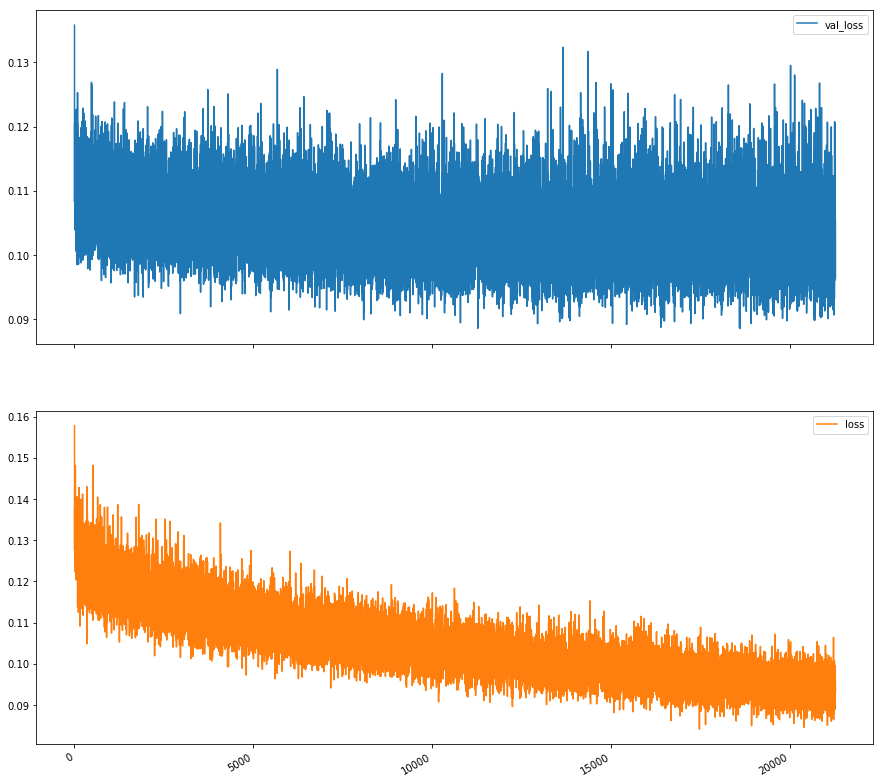

In [15]:
df_hist = pd.DataFrame(hist.history)
df_hist.plot(subplots=True, figsize=(15,15))
print(df_hist['val_loss'].min())
df_hist[df_hist['val_loss']<=0.1054]

In [16]:
# human_features.load_weights('human_features_weights_v2.h5')

In [17]:
# # print(df_hist.columns)
# print(df_hist['val_out_feature_1_acc'].max(), df_hist['val_out_feature_2_acc'].max(),
#        df_hist['val_out_feature_3_acc'].max(), df_hist['val_out_feature_4_acc'].max(),
#        df_hist['val_out_feature_5_acc'].max(), df_hist['val_out_feature_6_acc'].max(),
#        df_hist['val_out_feature_7_acc'].max(), df_hist['val_out_feature_8_acc'].max())
# # df_hist[df_hist['val_acc']>10.2]

In [18]:
test_g = datagen(len(val_list_of_writers)*5,val_path,val_list_of_writers, hshift = (-12,12), vis=True)
vx,vy = next(test_g)

(4440, 64, 64, 1) (4440,)


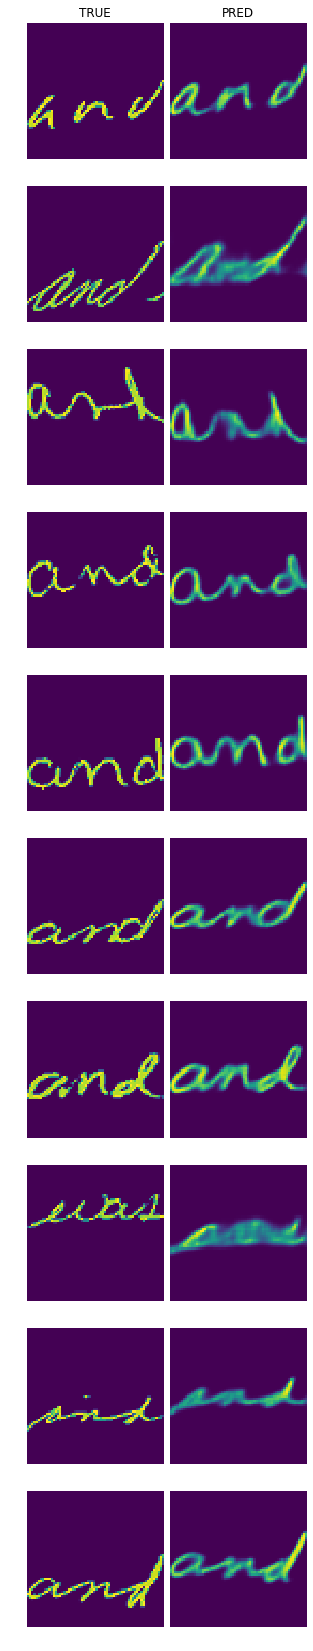

In [19]:

print(vx.shape,vy[0].shape)
py = autoencoder.predict(vx[:10])
f,ax = plt.subplots(len(vx[:10]),2)
f.subplots_adjust(hspace = .00, wspace=.05)
f.set_size_inches(5,len(vx[:10])*3)
ax[0,0].set_title('TRUE')
ax[0,1].set_title('PRED')
for i in range(len(vx[:10])):
#     print(vy[0][i], vy[1][i])
    ax[i,0].imshow(vx[i].reshape((64,64)))
    ax[i,0].axis('off')
    
    ax[i,1].imshow(py[i].reshape((64,64)))
    ax[i,1].axis('off')


In [20]:
encoder = Model(inputs=autoencoder.inputs,outputs=autoencoder.get_layer('encoded').output)


In [21]:
# df_val = pd.DataFrame(vy).T
# df_val.columns = ['identity','id','imagename']
# df_val = df_val.sort_values(by=['identity','imagename'])
# df_val = df_val.drop_duplicates()
# df_val = df_val.drop(columns=['id'])
# df_val

In [22]:
ids = vy[0].reshape(-1,1)
imagenames = vy[1].reshape(-1,1)
preds = encoder.predict(vx).reshape((-1,512))
# print(ids.shape,preds.shape)
# 
data=[]
for i in range(len(vx)):
    data.append([ids[i][0],imagenames[i][0],preds[i]])
df_data = pd.DataFrame(data=data, columns=['identity','imagename','latent'])
# df_outs['ids'] = ids
# df_outs['preds'] = preds 
df_data=df_data.sort_values(by='identity').reset_index()
df_data.shape

(4440, 4)

In [23]:
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm_notebook

In [24]:
cos_dist_out = cosine_similarity(list(df_data['latent'].values))

In [32]:
queried_count, idx_count, tp, tn, fp, fn = 0,0,0,0,0,0
cos_thresh = 0.6
data_result = []
fp_list = []
fn_list = []
r_counter = 0
stop_at = 10
prev_query = ''
prev_given = ''
given_count = 0
# total = cos_dist_out.shape[0]
for row in tqdm_notebook(cos_dist_out):
    c_counter = 0
    given_idx = df_data.iloc[r_counter]['identity']
    given_img = df_data.iloc[r_counter]['imagename']
    for col in row:
        queried_idx = df_data.iloc[c_counter]['identity']
        queried_img = df_data.iloc[c_counter]['imagename']
        if int(given_idx) == int(queried_idx) and cos_dist_out[r_counter][c_counter]>cos_thresh:
            tp += 1
        if int(given_idx) != int(queried_idx) and cos_dist_out[r_counter][c_counter]<cos_thresh:
            tn += 1
        if int(given_idx) != int(queried_idx) and cos_dist_out[r_counter][c_counter]>cos_thresh:
            fp += 1
            fp_list.append(os.path.join(queried_idx,queried_img))
        if int(given_idx) == int(queried_idx) and cos_dist_out[r_counter][c_counter]<cos_thresh:
            fn += 1
            fn_list.append(os.path.join(queried_idx,queried_img))
        if int(given_idx) == int(queried_idx):
            idx_count += 1
#             print('--i--',idx_count,'--i--')
#             print(given_idx,queried_idx)
        if prev_query != queried_idx:
#             print('--q--',queried_count,'--q--')
            queried_count += 1
        c_counter += 1
        prev_query = queried_idx
#         if queried_count == stop_at:
#             break
    precision = tp/(fp+tp)
    recall = tp/(tp+fn)
    f1 = 2*(precision*recall)/(precision+recall)
    total = np.sum((tp,tn,fp,fn))
    accuracy = (tp+tn)/total
    data_result.append([given_idx,given_img, idx_count, tp, tn, fp, fn,precision,recall,f1,accuracy, total, fp_list, fn_list])
    if prev_given != given_idx:
#         print('----',given_count,'-----')
        given_count+=1
    r_counter += 1
    prev_given = given_idx
    queried_count, idx_count, tp, tn, fp, fn = 0, 0, 0, 0, 0, 0
    fp_list = []
    fn_list = []
#     if given_count == stop_at:
#         break

In [37]:
df_cos_dist_out = pd.DataFrame(data_result, columns=['identity','imagename','total_images_identity','TP','TN','FP','FN','precision','recall','f1','accuracy','total_images', 'FP_List','FN_List'])
df_cos_dist_out=df_cos_dist_out.sort_values(by='identity',ascending=True).reset_index().drop(columns=['index'])
df_cos_dist_out.head(50)

,identity,imagename,total_images_identity,TP,TN,FP,FN,precision,recall,f1,accuracy,total_images,FP_List,FN_List
0,1451,1451c_num2.png,57,35,4259,124,22,0.220126,0.614035,0.324074,0.967117,4440,"[1457/1457b_num2.png, 1457/1457b_num2.png, 145...","[1451/1451c_num3.png, 1451/1451a_num3.png, 145..."
1,1451,1451a_num3.png,57,40,4208,175,17,0.186047,0.701754,0.294118,0.956757,4440,"[1452/1452c_num1.png, 1452/1452b_num1.png, 145...","[1451/1451c_num3.png, 1451/1451c_num5.png, 145..."
2,1451,1451c_num5.png,57,4,4335,48,53,0.076923,0.070175,0.073394,0.977252,4440,"[1457/1457c_num1.png, 1461/1461b_num2.png, 146...","[1451/1451c_num2.png, 1451/1451c_num3.png, 145..."
3,1451,1451b_num2.png,57,30,4325,58,27,0.340909,0.526316,0.413793,0.980856,4440,"[1457/1457a_num5.png, 1457/1457c_num2.png, 145...","[1451/1451c_num3.png, 1451/1451a_num2.png, 145..."
4,1451,1451a_num2.png,57,42,4256,127,15,0.248521,0.736842,0.371681,0.968018,4440,"[1452/1452c_num1.png, 1452/1452b_num1.png, 145...","[1451/1451c_num3.png, 1451/1451c_num5.png, 145..."
5,1451,1451c_num1.png,57,34,4278,105,23,0.244604,0.596491,0.346939,0.971171,4440,"[1457/1457b_num2.png, 1457/1457b_num2.png, 145...","[1451/1451c_num3.png, 1451/1451a_num1.png, 145..."
6,1451,1451b_num2.png,57,30,4325,58,27,0.340909,0.526316,0.413793,0.980856,4440,"[1457/1457a_num5.png, 1457/1457c_num2.png, 145...","[1451/1451c_num3.png, 1451/1451a_num2.png, 145..."
7,1451,1451b_num1.png,57,42,4236,147,15,0.222222,0.736842,0.341463,0.963514,4440,"[1452/1452c_num1.png, 1452/1452c_num1.png, 145...","[1451/1451c_num3.png, 1451/1451c_num5.png, 145..."
8,1451,1451a_num1.png,57,38,4198,185,19,0.170404,0.666667,0.271429,0.954054,4440,"[1452/1452c_num1.png, 1452/1452b_num1.png, 145...","[1451/1451c_num3.png, 1451/1451a_num2.png, 145..."
9,1451,1451c_num5.png,57,4,4333,50,53,0.074074,0.070175,0.072072,0.976802,4440,"[1457/1457c_num1.png, 1457/1457c_num1.png, 145...","[1451/1451c_num2.png, 1451/1451c_num3.png, 145..."


In [38]:
df_cos_dist_out.to_csv('results-DL_AE_Maxpool_1x1x512_Unseen.csv')

In [34]:
# print(df_cos_dist_out.keys())
total = df_cos_dist_out.shape[0]
total_images_identity = df_cos_dist_out['total_images_identity']
tps = df_cos_dist_out['TP'].sum()
fps = df_cos_dist_out['FP'].sum()
tns = df_cos_dist_out['TN'].sum()
fns = df_cos_dist_out['FN'].sum()
precision = tps/(fps+tps)
recall = tps/(tps+fns)
f1 = 2*(precision*recall)/(precision+recall)
print('precision:',precision,'\nrecall:',recall,'\nf1:',f1)
acc = df_cos_dist_out['accuracy'].mean()
print('Intra Writer Accuracy (Type 1):',np.mean(df_cos_dist_out['TP']/total_images_identity))
print('Inter Writer Accuracy (Type 2)::',tns/total/total)
print('acc:',acc)

precision: 0.14253974326785507 
recall: 0.6679521537355383 
f1: 0.23494307311569793
Intra Writer Accuracy (Type 1): 0.6731905250800788
Inter Writer Accuracy (Type 2):: 0.9454786543300058
acc: 0.9527358777696615


Text(0.5, 1.0, 'Right Input')

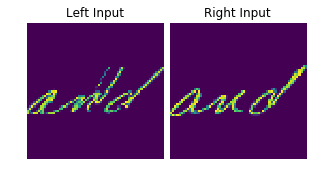

In [28]:
# test_im_shifted=test_im_normal
# test_im_shifted = vx[-2]
# rand = np.random.randint(-12,12)
# test_im_shifted=np.roll(axis=0,a=test_im_shifted,shift=-10)
# test = np.zeros((64,64,1))
# test[0:45]=test_im_shifted
# test_im_normal = vx[1]
# test_im_shifted = vx[2]
# plt.imshow(test_im_shifted.reshape((64,64)))
test_im_normal = 255.0-cv2.imread('../Handwriting/cleaned_AND_data_64x64/0301c_num2.png',0)
test_im_shifted = 255.0-cv2.imread('../Handwriting/cleaned_AND_data_64x64/0301c_num1.png',0)
f,ax = plt.subplots(1,2)
f.subplots_adjust(hspace = .00, wspace=.05)
f.set_size_inches(5,1*3)
ax[0].imshow(test_im_normal.reshape((64,64)))
ax[0].axis('off')

ax[1].imshow(test_im_shifted.reshape((64,64)))
ax[1].axis('off')
ax[0].set_title('Left Input')
ax[1].set_title('Right Input')

In [29]:
py1 = encoder.predict(test_im_normal.reshape((1,64,64,1)))
py2 = encoder.predict(test_im_shifted.reshape((1,64,64,1)))
py1[py1==0].shape,py2[py2==0].shape

((259,), (277,))

In [30]:
py1 = py1.reshape((-1,512))
py2 = py2.reshape((-1,512))
print(py1.shape,py2.shape)
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, euclidean_distances
cosine_similarity(py1,py2), cosine_distances(py1,py2), euclidean_distances(py1,py2)

(1, 512) (1, 512)


(array([[0.767698]], dtype=float32),
 array([[0.23230201]], dtype=float32),
 array([[1968.4119]], dtype=float32))

In [31]:
val_list_of_writers[:2]

['1469b_num3.png', '1453b_num4.png']